# The Project - Vehicle Detection


The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
#All the imports that I will need?


import numpy as np
import cv2
import pickle
import glob
import time
import copy
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from helperfunctions import *

%matplotlib inline

### Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

#### Step 1: Load in all the images

All the images that were provided were of either car or non car. This will be used to train the classifier.

In [2]:
# Read in cars and notcars
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

# Check that number of the images that I can read are not empty
print("Car images = {}".format(len(cars)))
print("Not car images = {}".format(len(notcars)))

Car images = 8792
Not car images = 8968


In [3]:
#Read in all the car and non car images
car_images = []
non_car_images = []

for car in cars:
    car_images.append(mpimg.imread(car))

for notcar in notcars:
    non_car_images.append(mpimg.imread(notcar))

#DEBUG
print(len(car_images))
print(len(non_car_images))

8792
8968


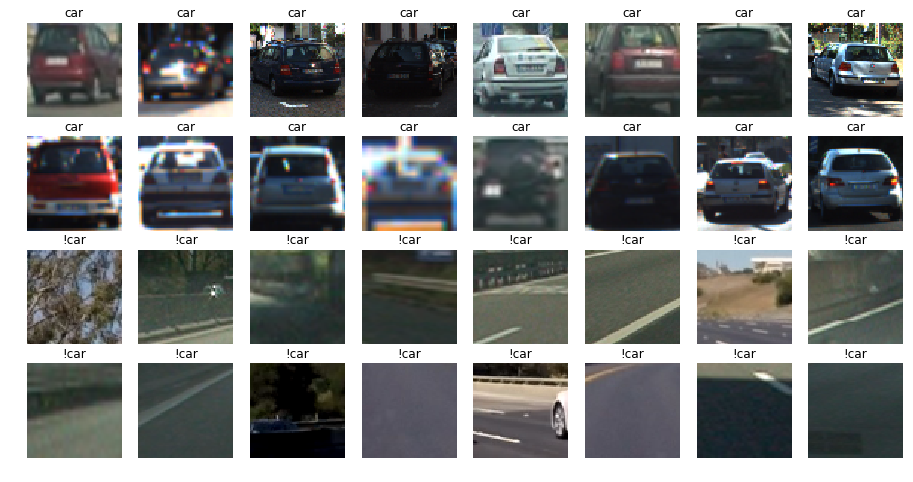

In [4]:
fig, axs = plt.subplots(4,8, figsize=(16, 8))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

#Display some random car and not car images.
for i in range(16):
    axs[i].axis('off')
    axs[i].set_title('car')
    axs[i].imshow(car_images[np.random.randint(0,len(car_images))])

for i in range(16,32):
    axs[i].axis('off')
    axs[i].set_title('!car')
    axs[i].imshow(non_car_images[np.random.randint(0,len(non_car_images))])


#### Step 2: Perform a Histogram of Oriented Gradients (HOG) feature extraction.

Here I will be playing around with the various values that I can use for the SciKit HOG's hyper parameters, and determine which can be a better one.

In [5]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 24    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720] # Min and max in y to search in slide_window()
xy_window_size = (64, 64) # The overlap window for the search
xy_overlap_size = (0.5, 0.5) #The overlap amount for the window

In [6]:
sample_car = [cars[50]]

t = time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

not_car_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

91.21 Seconds to extract HOG features...


Visualize a sample image for the HOG feature extraction:

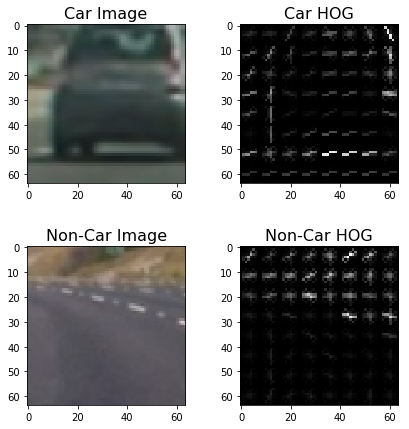

In [7]:

_, car_dst = get_hog_features(car_images[50][:,:,2], 9, 8, 8, vis=True, feature_vec=True)

_, noncar_dst = get_hog_features(non_car_images[50][:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_images[50])
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(non_car_images[50])
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

#### Step 3. Train a Linear SVM classifier.

In [5]:
#RUN THIS BLOCK ONCE YOU HAVE THE FINAL HYPER PARAMETERS YOU WANT
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 24    # Number of histogram bins
spatial_feat = True
hist_feat = True
hog_feat = True
t = time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
timetaken_features = round(t2-t, 2)
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
timetaken_classifier = round(t2-t, 2)

svc_score = round(svc.score(X_test, y_test), 4)


print("Time taken for feature extraction = {} seconds".format(timetaken_features))
print("Time taken for classifier training = {} seconds".format(timetaken_classifier))
print("Classifier accuracy = {}".format(svc_score))

Time taken for feature extraction = 135.42 seconds
Time taken for classifier training = 6.88 seconds
Classifier accuracy = 0.993


**The below block is for exploration. Need not be run everytime**

Now going to do something crazy here. Will be looping through a set of combinations to see what turns out to be a good combo.

In [17]:
possible_color_spaces = ["RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb"]
# Orientations in the range of 8 to 12
possible_hog_channels = [0, 1, 2, "ALL"]

print("| Colorspace | Orientations | pix_per_cell | cell_per_block | hog_channel | spatial_size | hist_bins | Feature_extraction_time | Classifier_train_time | Accuracy |")
print("|------------|--------------|--------------|----------------|-------------|--------------|-----------|-------------------------|-----------------------|----------|")


for clr_space in possible_color_spaces:
    for orien in range(8,13):
        for hog_chan in possible_hog_channels:
            t = time.time()
            car_features = extract_features(cars, color_space=clr_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orien, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_chan, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)
            
            notcar_features = extract_features(notcars, color_space=clr_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orien, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_chan, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)
            t2 = time.time()
            timetaken_features = round(t2-t, 2)
            X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
            # Fit a per-column scaler
            X_scaler = StandardScaler().fit(X)
            # Apply the scaler to X
            scaled_X = X_scaler.transform(X)

            # Define the labels vector
            y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
            
            # Split up data into randomized training and test sets
            rand_state = np.random.randint(0, 100)
            X_train, X_test, y_train, y_test = train_test_split(
                scaled_X, y, test_size=0.2, random_state=rand_state)

            # Use a linear SVC 
            svc = LinearSVC()
            # Check the training time for the SVC
            t=time.time()
            svc.fit(X_train, y_train)
            t2 = time.time()
            timetaken_classifier = round(t2-t, 2)
            
            svc_score = round(svc.score(X_test, y_test), 4)
            
            # Will be saving the scores in the format of:
            # | Colorspace | Orientations | pix_per_cell | cell_per_block | hog_channel | spatial_size | hist_bins | Feature_extraction_time | Classifier_train_time | Accuracy |
            output_string = "| {} | {} | {} | {} | {} | {} | {} | {} | {} | {} |".format(clr_space, orien, pix_per_cell, cell_per_block, hog_chan, spatial_size, hist_bins, timetaken_features, timetaken_classifier, svc_score)
            with open("hog_vis_exploration_logs.md", "a") as f:
                f.write(output_string)
                f.write("\n")
                print(output_string)
            

| Colorspace | Orientations | pix_per_cell | cell_per_block | hog_channel | spatial_size | hist_bins | Feature_extraction_time | Classifier_train_time | Accuracy |
|------------|--------------|--------------|----------------|-------------|--------------|-----------|-------------------------|-----------------------|----------|
| RGB | 8 | 8 | 2 | 0 | (16, 16) | 16 | 46.42 | 12.52 | 0.9696 |
| RGB | 8 | 8 | 2 | 1 | (16, 16) | 16 | 47.18 | 11.32 | 0.9772 |
| RGB | 8 | 8 | 2 | 2 | (16, 16) | 16 | 46.14 | 11.72 | 0.9761 |
| RGB | 8 | 8 | 2 | ALL | (16, 16) | 16 | 141.9 | 30.83 | 0.9766 |
| RGB | 9 | 8 | 2 | 0 | (16, 16) | 16 | 63.48 | 12.35 | 0.9685 |
| RGB | 9 | 8 | 2 | 1 | (16, 16) | 16 | 60.11 | 11.39 | 0.9738 |
| RGB | 9 | 8 | 2 | 2 | (16, 16) | 16 | 57.89 | 12.64 | 0.9738 |
| RGB | 9 | 8 | 2 | ALL | (16, 16) | 16 | 133.98 | 33.7 | 0.9823 |
| RGB | 10 | 8 | 2 | 0 | (16, 16) | 16 | 64.34 | 13.65 | 0.9755 |
| RGB | 10 | 8 | 2 | 1 | (16, 16) | 16 | 61.73 | 14.12 | 0.9794 |
| RGB | 10 | 8 |

| Colorspace | Orientations | pix_per_cell | cell_per_block | hog_channel | spatial_size | hist_bins | Feature_extraction_time | Classifier_train_time | Accuracy |
|------------|--------------|--------------|----------------|-------------|--------------|-----------|-------------------------|-----------------------|----------|
| RGB | 8 | 8 | 2 | 0 | (16, 16) | 16 | 46.42 | 12.52 | 0.9696 |
| RGB | 8 | 8 | 2 | 1 | (16, 16) | 16 | 47.18 | 11.32 | 0.9772 |
| RGB | 8 | 8 | 2 | 2 | (16, 16) | 16 | 46.14 | 11.72 | 0.9761 |
| RGB | 8 | 8 | 2 | ALL | (16, 16) | 16 | 141.9 | 30.83 | 0.9766 |
| RGB | 9 | 8 | 2 | 0 | (16, 16) | 16 | 63.48 | 12.35 | 0.9685 |
| RGB | 9 | 8 | 2 | 1 | (16, 16) | 16 | 60.11 | 11.39 | 0.9738 |
| RGB | 9 | 8 | 2 | 2 | (16, 16) | 16 | 57.89 | 12.64 | 0.9738 |
| RGB | 9 | 8 | 2 | ALL | (16, 16) | 16 | 133.98 | 33.7 | 0.9823 |
| RGB | 10 | 8 | 2 | 0 | (16, 16) | 16 | 64.34 | 13.65 | 0.9755 |
| RGB | 10 | 8 | 2 | 1 | (16, 16) | 16 | 61.73 | 14.12 | 0.9794 |
| RGB | 10 | 8 | 2 | 2 | (16, 16) | 16 | 66.98 | 14.07 | 0.9766 |
| RGB | 10 | 8 | 2 | ALL | (16, 16) | 16 | 131.12 | 39.12 | 0.9766 |
| RGB | 11 | 8 | 2 | 0 | (16, 16) | 16 | 71.25 | 15.51 | 0.9741 |
| RGB | 11 | 8 | 2 | 1 | (16, 16) | 16 | 71.41 | 14.39 | 0.9786 |
| RGB | 11 | 8 | 2 | 2 | (16, 16) | 16 | 70.44 | 14.89 | 0.9744 |
| RGB | 11 | 8 | 2 | ALL | (16, 16) | 16 | 134.92 | 41.26 | 0.9794 |
| RGB | 12 | 8 | 2 | 0 | (16, 16) | 16 | 184.69 | 23.28 | 0.9676 |
| RGB | 12 | 8 | 2 | 1 | (16, 16) | 16 | 305.81 | 20.0 | 0.9716 |
| RGB | 12 | 8 | 2 | 2 | (16, 16) | 16 | 308.21 | 20.09 | 0.9721 |
| RGB | 12 | 8 | 2 | ALL | (16, 16) | 16 | 291.78 | 45.75 | 0.9764 |
| HSV | 8 | 8 | 2 | 0 | (16, 16) | 16 | 47.26 | 12.36 | 0.9702 |
| HSV | 8 | 8 | 2 | 1 | (16, 16) | 16 | 46.01 | 13.13 | 0.9668 |
| HSV | 8 | 8 | 2 | 2 | (16, 16) | 16 | 46.52 | 10.71 | 0.9851 |
| HSV | 8 | 8 | 2 | ALL | (16, 16) | 16 | 138.16 | 11.05 | 0.9924 |
| HSV | 9 | 8 | 2 | 0 | (16, 16) | 16 | 69.22 | 14.06 | 0.9673 |
| HSV | 9 | 8 | 2 | 1 | (16, 16) | 16 | 67.13 | 13.93 | 0.9657 |
| HSV | 9 | 8 | 2 | 2 | (16, 16) | 16 | 62.71 | 11.84 | 0.9848 |
| HSV | 9 | 8 | 2 | ALL | (16, 16) | 16 | 138.37 | 28.57 | 0.9887 |
| HSV | 10 | 8 | 2 | 0 | (16, 16) | 16 | 72.51 | 15.06 | 0.9679 |
| HSV | 10 | 8 | 2 | 1 | (16, 16) | 16 | 67.42 | 14.35 | 0.9707 |
| HSV | 10 | 8 | 2 | 2 | (16, 16) | 16 | 69.44 | 12.62 | 0.989 |
| HSV | 10 | 8 | 2 | ALL | (16, 16) | 16 | 143.22 | 6.87 | 0.991 |
| HSV | 11 | 8 | 2 | 0 | (16, 16) | 16 | 76.75 | 16.88 | 0.9609 |
| HSV | 11 | 8 | 2 | 1 | (16, 16) | 16 | 75.42 | 16.07 | 0.964 |
| HSV | 11 | 8 | 2 | 2 | (16, 16) | 16 | 75.54 | 13.9 | 0.9885 |
| HSV | 11 | 8 | 2 | ALL | (16, 16) | 16 | 133.05 | 7.7 | 0.9887 |
| HSV | 12 | 8 | 2 | 0 | (16, 16) | 16 | 182.61 | 21.63 | 0.9676 |
| HSV | 12 | 8 | 2 | 1 | (16, 16) | 16 | 311.76 | 23.52 | 0.9685 |
| HSV | 12 | 8 | 2 | 2 | (16, 16) | 16 | 306.19 | 19.42 | 0.9825 |
| HSV | 12 | 8 | 2 | ALL | (16, 16) | 16 | 303.26 | 7.82 | 0.9924 |
| LUV | 8 | 8 | 2 | 0 | (16, 16) | 16 | 50.19 | 10.63 | 0.9831 |
| LUV | 8 | 8 | 2 | 1 | (16, 16) | 16 | 47.5 | 12.01 | 0.9676 |
| LUV | 8 | 8 | 2 | 2 | (16, 16) | 16 | 48.36 | 14.91 | 0.9611 |
| LUV | 8 | 8 | 2 | ALL | (16, 16) | 16 | 144.0 | 27.54 | 0.9885 |
| LUV | 9 | 8 | 2 | 0 | (16, 16) | 16 | 68.47 | 11.25 | 0.9848 |
| LUV | 9 | 8 | 2 | 1 | (16, 16) | 16 | 72.21 | 13.17 | 0.9688 |
| LUV | 9 | 8 | 2 | 2 | (16, 16) | 16 | 65.93 | 14.95 | 0.9589 |
| LUV | 9 | 8 | 2 | ALL | (16, 16) | 16 | 143.48 | 32.27 | 0.9887 |
| LUV | 10 | 8 | 2 | 0 | (16, 16) | 16 | 71.6 | 11.77 | 0.9851 |
| LUV | 10 | 8 | 2 | 1 | (16, 16) | 16 | 70.47 | 14.54 | 0.9738 |
| LUV | 10 | 8 | 2 | 2 | (16, 16) | 16 | 69.97 | 16.03 | 0.9611 |
| LUV | 10 | 8 | 2 | ALL | (16, 16) | 16 | 148.28 | 34.8 | 0.987 |
| LUV | 11 | 8 | 2 | 0 | (16, 16) | 16 | 80.28 | 12.67 | 0.9879 |
| LUV | 11 | 8 | 2 | 1 | (16, 16) | 16 | 75.47 | 14.95 | 0.9626 |
| LUV | 11 | 8 | 2 | 2 | (16, 16) | 16 | 76.95 | 17.58 | 0.9645 |
| LUV | 11 | 8 | 2 | ALL | (16, 16) | 16 | 140.04 | 36.55 | 0.9868 |
| LUV | 12 | 8 | 2 | 0 | (16, 16) | 16 | 197.89 | 21.11 | 0.9854 |
| LUV | 12 | 8 | 2 | 1 | (16, 16) | 16 | 319.39 | 22.11 | 0.9676 |
| LUV | 12 | 8 | 2 | 2 | (16, 16) | 16 | 328.19 | 23.61 | 0.9597 |
| LUV | 12 | 8 | 2 | ALL | (16, 16) | 16 | 308.28 | 45.27 | 0.989 |
| HLS | 8 | 8 | 2 | 0 | (16, 16) | 16 | 49.9 | 12.76 | 0.9682 |
| HLS | 8 | 8 | 2 | 1 | (16, 16) | 16 | 46.79 | 10.07 | 0.984 |
| HLS | 8 | 8 | 2 | 2 | (16, 16) | 16 | 46.79 | 14.91 | 0.9586 |
| HLS | 8 | 8 | 2 | ALL | (16, 16) | 16 | 152.45 | 28.96 | 0.9887 |
| HLS | 9 | 8 | 2 | 0 | (16, 16) | 16 | 68.04 | 15.15 | 0.9558 |
| HLS | 9 | 8 | 2 | 1 | (16, 16) | 16 | 71.17 | 11.32 | 0.9809 |
| HLS | 9 | 8 | 2 | 2 | (16, 16) | 16 | 67.48 | 16.47 | 0.9569 |
| HLS | 9 | 8 | 2 | ALL | (16, 16) | 16 | 146.91 | 31.78 | 0.9921 |
| HLS | 10 | 8 | 2 | 0 | (16, 16) | 16 | 75.62 | 15.53 | 0.9645 |
| HLS | 10 | 8 | 2 | 1 | (16, 16) | 16 | 69.51 | 12.35 | 0.9825 |
| HLS | 10 | 8 | 2 | 2 | (16, 16) | 16 | 72.66 | 19.16 | 0.96 |
| HLS | 10 | 8 | 2 | ALL | (16, 16) | 16 | 151.98 | 7.18 | 0.9918 |
| HLS | 11 | 8 | 2 | 0 | (16, 16) | 16 | 81.13 | 18.88 | 0.9628 |
| HLS | 11 | 8 | 2 | 1 | (16, 16) | 16 | 77.85 | 13.25 | 0.9828 |
| HLS | 11 | 8 | 2 | 2 | (16, 16) | 16 | 81.17 | 18.98 | 0.9659 |
| HLS | 11 | 8 | 2 | ALL | (16, 16) | 16 | 141.89 | 15.75 | 0.9893 |
| HLS | 12 | 8 | 2 | 0 | (16, 16) | 16 | 196.22 | 23.4 | 0.962 |
| HLS | 12 | 8 | 2 | 1 | (16, 16) | 16 | 321.8 | 20.04 | 0.9817 |
| HLS | 12 | 8 | 2 | 2 | (16, 16) | 16 | 327.79 | 25.68 | 0.9659 |
| HLS | 12 | 8 | 2 | ALL | (16, 16) | 16 | 316.24 | 7.94 | 0.9941 |
| YUV | 8 | 8 | 2 | 0 | (16, 16) | 16 | 50.51 | 9.71 | 0.9845 |
| YUV | 8 | 8 | 2 | 1 | (16, 16) | 16 | 48.04 | 11.5 | 0.9699 |
| YUV | 8 | 8 | 2 | 2 | (16, 16) | 16 | 48.46 | 12.82 | 0.9603 |
| YUV | 8 | 8 | 2 | ALL | (16, 16) | 16 | 150.52 | 23.28 | 0.9899 |
| YUV | 9 | 8 | 2 | 0 | (16, 16) | 16 | 67.29 | 10.71 | 0.9837 |
| YUV | 9 | 8 | 2 | 1 | (16, 16) | 16 | 73.35 | 12.55 | 0.9673 |
| YUV | 9 | 8 | 2 | 2 | (16, 16) | 16 | 69.02 | 15.42 | 0.9657 |
| YUV | 9 | 8 | 2 | ALL | (16, 16) | 16 | 148.12 | 26.48 | 0.9924 |
| YUV | 10 | 8 | 2 | 0 | (16, 16) | 16 | 73.58 | 11.78 | 0.9862 |
| YUV | 10 | 8 | 2 | 1 | (16, 16) | 16 | 71.9 | 13.6 | 0.9693 |
| YUV | 10 | 8 | 2 | 2 | (16, 16) | 16 | 72.19 | 17.46 | 0.9707 |
| YUV | 10 | 8 | 2 | ALL | (16, 16) | 16 | 151.5 | 29.12 | 0.9901 |
| YUV | 11 | 8 | 2 | 0 | (16, 16) | 16 | 81.49 | 13.29 | 0.9862 |
| YUV | 11 | 8 | 2 | 1 | (16, 16) | 16 | 79.55 | 14.67 | 0.9668 |
| YUV | 11 | 8 | 2 | 2 | (16, 16) | 16 | 80.27 | 17.14 | 0.9623 |
| YUV | 11 | 8 | 2 | ALL | (16, 16) | 16 | 144.63 | 13.62 | 0.9887 |
| YUV | 12 | 8 | 2 | 0 | (16, 16) | 16 | 221.48 | 20.82 | 0.9851 |
| YUV | 12 | 8 | 2 | 1 | (16, 16) | 16 | 331.63 | 21.56 | 0.9668 |
| YUV | 12 | 8 | 2 | 2 | (16, 16) | 16 | 344.98 | 25.13 | 0.9671 |
| YUV | 12 | 8 | 2 | ALL | (16, 16) | 16 | 317.86 | 7.55 | 0.9899 |
| YCrCb | 8 | 8 | 2 | 0 | (16, 16) | 16 | 50.21 | 9.95 | 0.9862 |
| YCrCb | 8 | 8 | 2 | 1 | (16, 16) | 16 | 49.57 | 11.54 | 0.9716 |
| YCrCb | 8 | 8 | 2 | 2 | (16, 16) | 16 | 48.54 | 13.53 | 0.9693 |
| YCrCb | 8 | 8 | 2 | ALL | (16, 16) | 16 | 150.18 | 23.51 | 0.9918 |
| YCrCb | 9 | 8 | 2 | 0 | (16, 16) | 16 | 70.16 | 10.99 | 0.9848 |
| YCrCb | 9 | 8 | 2 | 1 | (16, 16) | 16 | 75.52 | 12.8 | 0.9648 |
| YCrCb | 9 | 8 | 2 | 2 | (16, 16) | 16 | 70.57 | 14.76 | 0.9685 |
| YCrCb | 9 | 8 | 2 | ALL | (16, 16) | 16 | 155.27 | 27.46 | 0.9927 |
| YCrCb | 10 | 8 | 2 | 0 | (16, 16) | 16 | 83.06 | 12.07 | 0.9834 |
| YCrCb | 10 | 8 | 2 | 1 | (16, 16) | 16 | 71.88 | 13.92 | 0.9679 |
| YCrCb | 10 | 8 | 2 | 2 | (16, 16) | 16 | 72.51 | 15.82 | 0.9724 |
| YCrCb | 10 | 8 | 2 | ALL | (16, 16) | 16 | 157.18 | 7.91 | 0.9901 |
| YCrCb | 11 | 8 | 2 | 0 | (16, 16) | 16 | 83.31 | 13.36 | 0.987 |
| YCrCb | 11 | 8 | 2 | 1 | (16, 16) | 16 | 81.62 | 15.18 | 0.969 |
| YCrCb | 11 | 8 | 2 | 2 | (16, 16) | 16 | 82.89 | 17.29 | 0.9654 |
| YCrCb | 11 | 8 | 2 | ALL | (16, 16) | 16 | 144.84 | 34.92 | 0.9893 |
| YCrCb | 12 | 8 | 2 | 0 | (16, 16) | 16 | 194.02 | 22.44 | 0.98 |
| YCrCb | 12 | 8 | 2 | 1 | (16, 16) | 16 | 318.46 | 22.4 | 0.9688 |
| YCrCb | 12 | 8 | 2 | 2 | (16, 16) | 16 | 329.38 | 24.18 | 0.9645 |
| YCrCb | 12 | 8 | 2 | ALL | (16, 16) | 16 | 315.03 | 7.81 | 0.9941 |

From the above table both the ``HLS`` and the ``YCrCb`` colorspaces seem to be the better choice. Escpencially when its hyperparamenters are 12 Orientations and ALL HOG channels. I would at this point proceed with these 2 and see if I can improve the vehicle detection and reduce the false positives by playing around with the bin size and the pixel per cell parameters

### Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [6]:
y_start_stop = [400, 720] # Min and max in y to search in slide_window()
xy_window_size = (64, 64) # The overlap window for the search
xy_overlap_size = (0.5, 0.5) #The overlap amount for the window

In [7]:
svc_copy = copy.copy(svc)

def sliding_process(image):
    draw_image = np.copy(image)
    
    #Since we are reading in the image using mpimg and the images are png images, we need to convert from to a scale of 0-255
    image = image.astype(np.float32)/255
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=xy_window_size, xy_overlap=xy_overlap_size)
    
    hot_windows = search_windows(image, windows, svc_copy, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    #plt.imshow(window_img)
    return window_img

In [8]:
tmp_image = mpimg.imread('./test_images/test4.jpg')

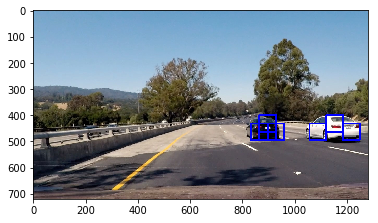

In [9]:
plt.imshow(sliding_process(tmp_image))

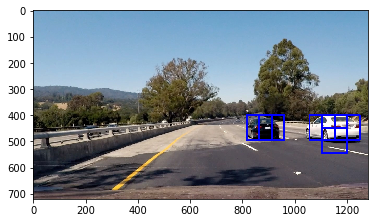

In [10]:
tmp_rects = find_cars(tmp_image, y_start_stop[0], y_start_stop[1], 1.5, svc, 
                      X_scaler, orient, pix_per_cell, cell_per_block, 
                      spatial_size, hist_bins)
tmp_hog_slide = draw_boxes(tmp_image, tmp_rects)
plt.imshow(tmp_hog_slide)



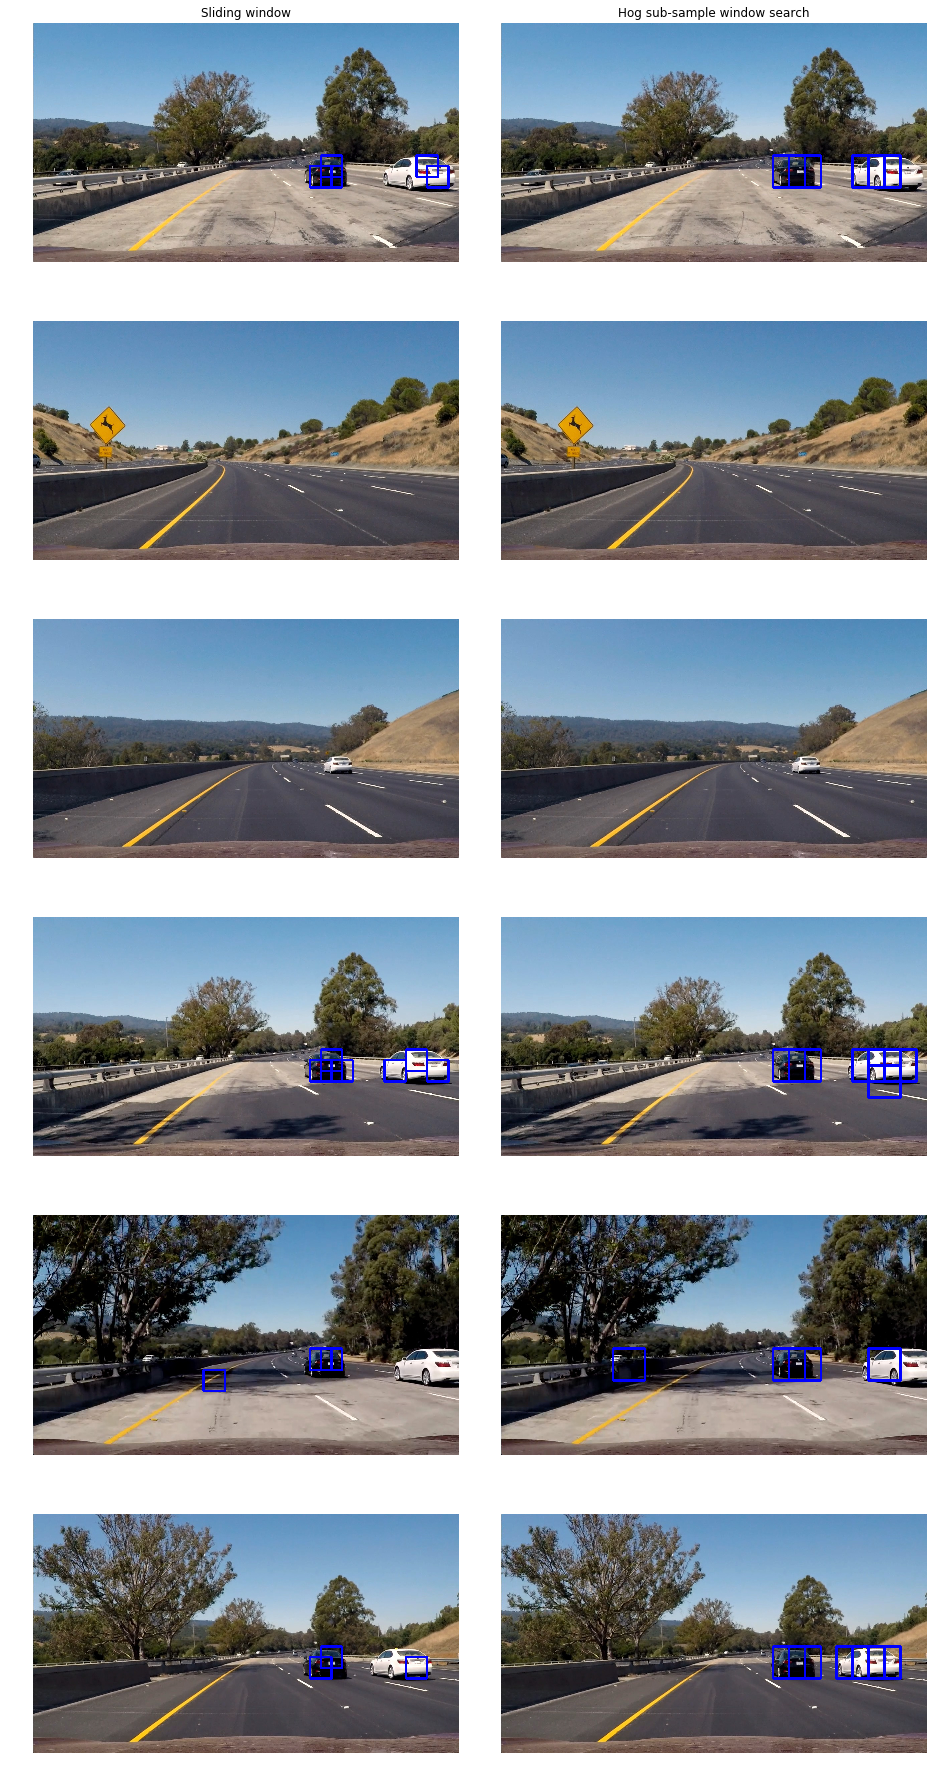

In [11]:
fig, axs = plt.subplots(6,2, figsize=(16, 32))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()
    
tmp_cars = glob.glob('test_images/*.jpg')
tmp_imgs = []
for tmp_car in tmp_cars:
    tmp_image = mpimg.imread(tmp_car)
    tmp_imgs.append(sliding_process(tmp_image))
    tmp_imgs.append(draw_boxes(tmp_image, find_cars(tmp_image, y_start_stop[0], y_start_stop[1], 1.5, 
                               svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                               spatial_size, hist_bins)))

axs[0].set_title('Sliding window')
axs[1].set_title('Hog sub-sample window search')

for i, img in enumerate(tmp_imgs):
    axs[i].axis('off')
    axs[i].imshow(img)
    


As seen above, the Sliding window implementation with the addition of HOG sub sampling on all the three channels helps us determine the white car a bit better. But, this has increased our number of false positives by quite a bit. This needs to be resolved a bit better

### Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

Creating helper functions to create a heatmap and then use this to create the bounding box.

In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

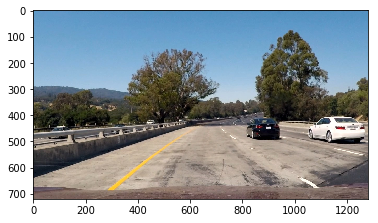

In [13]:
tmp_image = mpimg.imread('./test_images/test1.jpg')

plt.imshow(tmp_image)

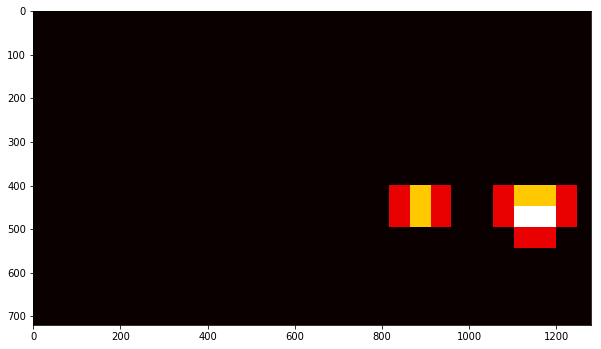

In [14]:
# Test out the heatmap
heatmap_img = np.zeros_like(tmp_image[:,:,0]).astype(np.float)
heatmap_img = add_heat(heatmap_img, tmp_rects)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')


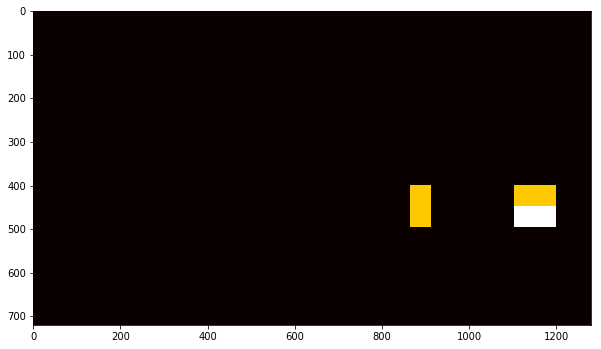

In [15]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

2 cars found


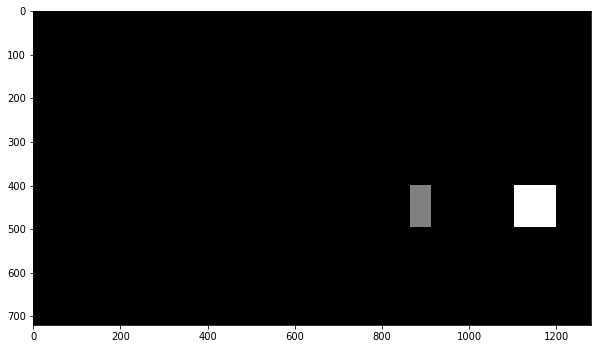

In [16]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

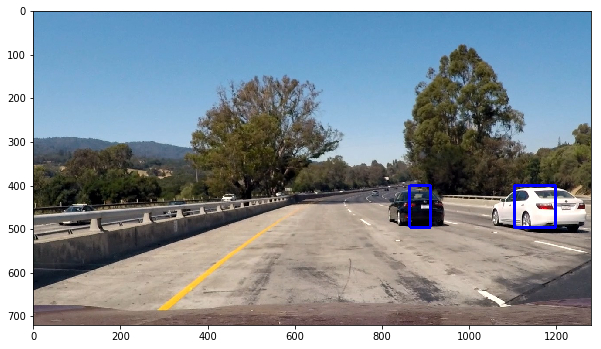

In [17]:
final_image = draw_labeled_bboxes(np.copy(tmp_image), labels)
plt.figure(figsize=(10,10))
plt.imshow(final_image)

In [18]:
def process_image_v1(image):
    tmp_rects = find_cars(image, y_start_stop[0], y_start_stop[1], 1.5, svc, 
                      X_scaler, orient, pix_per_cell, cell_per_block, 
                      spatial_size, hist_bins)
    heatmap_img = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap_img = add_heat(heatmap_img, tmp_rects)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    
    return draw_labeled_bboxes(np.copy(image), labels)

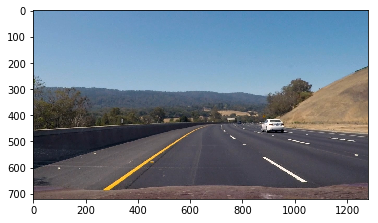

In [37]:
plt.imshow(process_image_v1(mpimg.imread('./test_images/test3.jpg')))

In [23]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_image_v1)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:31<00:00,  1.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 32 s


When testing it out with the final video file, it was apparent that there were still several false positives being reported. One of the ways to mitigate this is to create a boundary based search for the vehicles. This can be bound to certain sections in the video.

For ex, cars appear tinier when they are the farthest. We need not earch for tiny image spaces nearer to the car's hood. Things will appear bigger over there. With this, I think we can reduce the number of false positives.

\[Update\]: As for the jumpy lines, one way to reduce that is to implement a buffer of sorts to remember where the heat map was for the previous frame and apply thresholding to that.

In [19]:
class FrameBuffer():
    def __init__(self):
        self.rect_buffer = []
        self.buffer_size = 10
    
    def set_buffer_size(self, size):
        self.buffer_size = size
    
    def add_rect(self, rects):
        self.rect_buffer.append(rects)
        if len(self.rect_buffer) > self.buffer_size:
            self.rect_buffer = self.rect_buffer[1:]
    
    def pop_older(self):
        if len(self.rect_buffer) > 1:
            self.rect_buffer = self.rect_buffer[1:]
        else:
            self.rect_buffer = []

In [20]:
myFrameBuffer = None

def reinit_buffer():
    global myFrameBuffer;
    myFrameBuffer = FrameBuffer()

### Estimate a bounding box for vehicles detected

The following section contains the pipeline code that will estimate the bounding box for the vehicles detected with the help of a frame buffer. Sample image shown below

In [21]:
def process_image_v2(image):
    
    global myFrameBuffer
    
    rects = []
    
    y_start = 400
    y_stop = 470
    scale = 1.0
    
    rects.append(find_cars(image,y_start, y_stop, scale, svc, 
                      X_scaler, orient, pix_per_cell, cell_per_block, 
                      spatial_size, hist_bins))
    
    y_start = 430
    y_stop = 500
    scale = 1.0
    
    rects.append(find_cars(image,y_start, y_stop, scale, svc, 
                      X_scaler, orient, pix_per_cell, cell_per_block, 
                      spatial_size, hist_bins))
    
    y_start = 400
    y_stop = 580
    scale = 1.5
    
    rects.append(find_cars(image,y_start, y_stop, scale, svc, 
                      X_scaler, orient, pix_per_cell, cell_per_block, 
                      spatial_size, hist_bins))
    
    y_start = 400
    y_stop = 530
    scale = 2.0
    
    rects.append(find_cars(image,y_start, y_stop, scale, svc, 
                      X_scaler, orient, pix_per_cell, cell_per_block, 
                      spatial_size, hist_bins))
    
    y_start = 400
    y_stop = 550
    scale = 2.5
    
    rects.append(find_cars(image,y_start, y_stop, scale, svc, 
                      X_scaler, orient, pix_per_cell, cell_per_block, 
                      spatial_size, hist_bins))
    
    y_start = 460
    y_stop = 660
    scale = 2.5
    
    rects.append(find_cars(image,y_start, y_stop, scale, svc, 
                      X_scaler, orient, pix_per_cell, cell_per_block, 
                      spatial_size, hist_bins))
    
    rects = [item for sublist in rects for item in sublist] 
    print(len(rects))
    if len(rects) > 0:
        myFrameBuffer.add_rect(rects)
    else:
        myFrameBuffer.pop_older()
    
    
    heatmap_img = np.zeros_like(image[:,:,0]).astype(np.float)
    for rect in myFrameBuffer.rect_buffer:
        heatmap_img = add_heat(heatmap_img, rect)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(myFrameBuffer.rect_buffer)/2)
    
    #return heatmap_img
    
    labels = label(heatmap_img)
    
    return draw_labeled_bboxes(np.copy(image), labels)
    

13


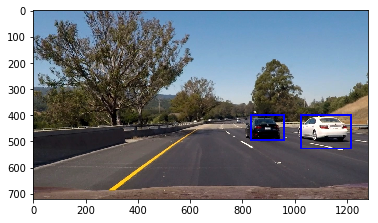

In [22]:
reinit_buffer()

plt.imshow(process_image_v2(mpimg.imread('./test_images/test6.jpg')), cmap='hot')

In [23]:
reinit_buffer()

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_image_v2)
%time clip_test_out.write_videofile(test_out_file, audio=False)

9
[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

9


  3%|██▏                                                                                | 1/39 [00:00<00:31,  1.20it/s]

12


  5%|████▎                                                                              | 2/39 [00:01<00:30,  1.21it/s]

11


  8%|██████▍                                                                            | 3/39 [00:02<00:29,  1.21it/s]

11


 10%|████████▌                                                                          | 4/39 [00:03<00:28,  1.21it/s]

11


 13%|██████████▋                                                                        | 5/39 [00:04<00:28,  1.20it/s]

13


 15%|████████████▊                                                                      | 6/39 [00:04<00:27,  1.20it/s]

11


 18%|██████████████▉                                                                    | 7/39 [00:05<00:26,  1.20it/s]

14


 21%|█████████████████                                                                  | 8/39 [00:06<00:25,  1.19it/s]

10


 23%|███████████████████▏                                                               | 9/39 [00:07<00:25,  1.20it/s]

13


 26%|█████████████████████                                                             | 10/39 [00:08<00:24,  1.19it/s]

11


 28%|███████████████████████▏                                                          | 11/39 [00:09<00:23,  1.20it/s]

11


 31%|█████████████████████████▏                                                        | 12/39 [00:10<00:22,  1.18it/s]

12


 33%|███████████████████████████▎                                                      | 13/39 [00:10<00:21,  1.20it/s]

12


 36%|█████████████████████████████▍                                                    | 14/39 [00:11<00:20,  1.20it/s]

11


 38%|███████████████████████████████▌                                                  | 15/39 [00:12<00:19,  1.20it/s]

11


 41%|█████████████████████████████████▋                                                | 16/39 [00:13<00:19,  1.20it/s]

12


 44%|███████████████████████████████████▋                                              | 17/39 [00:14<00:18,  1.22it/s]

11


 46%|█████████████████████████████████████▊                                            | 18/39 [00:14<00:17,  1.21it/s]

11


 49%|███████████████████████████████████████▉                                          | 19/39 [00:15<00:16,  1.22it/s]

11


 51%|██████████████████████████████████████████                                        | 20/39 [00:16<00:15,  1.22it/s]

11


 54%|████████████████████████████████████████████▏                                     | 21/39 [00:17<00:14,  1.24it/s]

12


 56%|██████████████████████████████████████████████▎                                   | 22/39 [00:18<00:13,  1.25it/s]

12


 59%|████████████████████████████████████████████████▎                                 | 23/39 [00:18<00:12,  1.24it/s]

12


 62%|██████████████████████████████████████████████████▍                               | 24/39 [00:19<00:11,  1.25it/s]

10


 64%|████████████████████████████████████████████████████▌                             | 25/39 [00:20<00:11,  1.26it/s]

11


 67%|██████████████████████████████████████████████████████▋                           | 26/39 [00:21<00:10,  1.25it/s]

12


 69%|████████████████████████████████████████████████████████▊                         | 27/39 [00:22<00:09,  1.24it/s]

10


 72%|██████████████████████████████████████████████████████████▊                       | 28/39 [00:22<00:08,  1.25it/s]

10


 74%|████████████████████████████████████████████████████████████▉                     | 29/39 [00:23<00:07,  1.26it/s]

11


 77%|███████████████████████████████████████████████████████████████                   | 30/39 [00:24<00:07,  1.25it/s]

10


 79%|█████████████████████████████████████████████████████████████████▏                | 31/39 [00:25<00:06,  1.26it/s]

10


 82%|███████████████████████████████████████████████████████████████████▎              | 32/39 [00:26<00:05,  1.27it/s]

11


 85%|█████████████████████████████████████████████████████████████████████▍            | 33/39 [00:26<00:04,  1.28it/s]

10


 87%|███████████████████████████████████████████████████████████████████████▍          | 34/39 [00:27<00:03,  1.28it/s]

12


 90%|█████████████████████████████████████████████████████████████████████████▌        | 35/39 [00:28<00:03,  1.28it/s]

11


 92%|███████████████████████████████████████████████████████████████████████████▋      | 36/39 [00:29<00:02,  1.29it/s]

10


 95%|█████████████████████████████████████████████████████████████████████████████▊    | 37/39 [00:29<00:01,  1.29it/s]

9


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:30<00:00,  1.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 31.3 s


In [24]:
reinit_buffer()

proj_out_file = 'project_video_out_mini.mp4'
clip_proj = VideoFileClip('project_video.mp4').subclip(24,45)
clip_proj_out = clip_proj.fl_image(process_image_v2)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

0
[MoviePy] >>>> Building video project_video_out_mini.mp4
[MoviePy] Writing video project_video_out_mini.mp4


  0%|                                                                                          | 0/526 [00:00<?, ?it/s]

0


  0%|▏                                                                                 | 1/526 [00:00<06:09,  1.42it/s]

1


  0%|▎                                                                                 | 2/526 [00:01<06:12,  1.41it/s]

1


  1%|▍                                                                                 | 3/526 [00:02<06:10,  1.41it/s]

1


  1%|▌                                                                                 | 4/526 [00:02<06:10,  1.41it/s]

1


  1%|▊                                                                                 | 5/526 [00:03<06:08,  1.41it/s]

0


  1%|▉                                                                                 | 6/526 [00:04<06:07,  1.41it/s]

1


  1%|█                                                                                 | 7/526 [00:04<06:06,  1.41it/s]

1


  2%|█▏                                                                                | 8/526 [00:05<06:04,  1.42it/s]

1


  2%|█▍                                                                                | 9/526 [00:06<06:02,  1.43it/s]

1


  2%|█▌                                                                               | 10/526 [00:07<06:02,  1.42it/s]

1


  2%|█▋                                                                               | 11/526 [00:07<06:03,  1.42it/s]

1


  2%|█▊                                                                               | 12/526 [00:08<06:00,  1.42it/s]

1


  2%|██                                                                               | 13/526 [00:09<06:04,  1.41it/s]

1


  3%|██▏                                                                              | 14/526 [00:09<06:00,  1.42it/s]

1


  3%|██▎                                                                              | 15/526 [00:10<05:55,  1.44it/s]

1


  3%|██▍                                                                              | 16/526 [00:11<05:51,  1.45it/s]

1


  3%|██▌                                                                              | 17/526 [00:11<05:48,  1.46it/s]

1


  3%|██▊                                                                              | 18/526 [00:12<05:48,  1.46it/s]

1


  4%|██▉                                                                              | 19/526 [00:13<05:45,  1.47it/s]

2


  4%|███                                                                              | 20/526 [00:13<05:43,  1.47it/s]

1


  4%|███▏                                                                             | 21/526 [00:14<05:44,  1.46it/s]

1


  4%|███▍                                                                             | 22/526 [00:15<05:45,  1.46it/s]

0


  4%|███▌                                                                             | 23/526 [00:16<05:44,  1.46it/s]

0


  5%|███▋                                                                             | 24/526 [00:16<05:42,  1.46it/s]

1


  5%|███▊                                                                             | 25/526 [00:17<05:38,  1.48it/s]

1


  5%|████                                                                             | 26/526 [00:18<05:39,  1.47it/s]

1


  5%|████▏                                                                            | 27/526 [00:18<05:37,  1.48it/s]

1


  5%|████▎                                                                            | 28/526 [00:19<05:41,  1.46it/s]

0


  6%|████▍                                                                            | 29/526 [00:20<05:43,  1.45it/s]

0


  6%|████▌                                                                            | 30/526 [00:20<05:46,  1.43it/s]

0


  6%|████▊                                                                            | 31/526 [00:21<05:55,  1.39it/s]

0


  6%|████▉                                                                            | 32/526 [00:22<06:07,  1.34it/s]

0


  6%|█████                                                                            | 33/526 [00:23<06:02,  1.36it/s]

0


  6%|█████▏                                                                           | 34/526 [00:23<05:55,  1.39it/s]

0


  7%|█████▍                                                                           | 35/526 [00:24<05:44,  1.42it/s]

0


  7%|█████▌                                                                           | 36/526 [00:25<05:45,  1.42it/s]

0


  7%|█████▋                                                                           | 37/526 [00:25<05:48,  1.40it/s]

0


  7%|█████▊                                                                           | 38/526 [00:26<05:48,  1.40it/s]

0


  7%|██████                                                                           | 39/526 [00:27<05:36,  1.45it/s]

0


  8%|██████▏                                                                          | 40/526 [00:27<05:31,  1.47it/s]

1


  8%|██████▎                                                                          | 41/526 [00:28<05:27,  1.48it/s]

0


  8%|██████▍                                                                          | 42/526 [00:29<05:23,  1.49it/s]

0


  8%|██████▌                                                                          | 43/526 [00:29<05:19,  1.51it/s]

0


  8%|██████▊                                                                          | 44/526 [00:30<05:13,  1.54it/s]

0


  9%|██████▉                                                                          | 45/526 [00:31<05:10,  1.55it/s]

1


  9%|███████                                                                          | 46/526 [00:31<05:13,  1.53it/s]

0


  9%|███████▏                                                                         | 47/526 [00:32<05:34,  1.43it/s]

1


  9%|███████▍                                                                         | 48/526 [00:33<05:23,  1.48it/s]

1


  9%|███████▌                                                                         | 49/526 [00:33<05:15,  1.51it/s]

0


 10%|███████▋                                                                         | 50/526 [00:34<05:07,  1.55it/s]

0


 10%|███████▊                                                                         | 51/526 [00:35<05:03,  1.57it/s]

0


 10%|████████                                                                         | 52/526 [00:35<05:02,  1.57it/s]

0


 10%|████████▏                                                                        | 53/526 [00:36<04:57,  1.59it/s]

0


 10%|████████▎                                                                        | 54/526 [00:36<04:56,  1.59it/s]

0


 10%|████████▍                                                                        | 55/526 [00:37<04:50,  1.62it/s]

1


 11%|████████▌                                                                        | 56/526 [00:38<04:51,  1.61it/s]

1


 11%|████████▊                                                                        | 57/526 [00:38<04:52,  1.60it/s]

0


 11%|████████▉                                                                        | 58/526 [00:39<04:48,  1.62it/s]

0


 11%|█████████                                                                        | 59/526 [00:40<04:51,  1.60it/s]

0


 11%|█████████▏                                                                       | 60/526 [00:40<04:48,  1.62it/s]

0


 12%|█████████▍                                                                       | 61/526 [00:41<04:40,  1.66it/s]

0


 12%|█████████▌                                                                       | 62/526 [00:41<04:39,  1.66it/s]

0


 12%|█████████▋                                                                       | 63/526 [00:42<04:34,  1.69it/s]

0


 12%|█████████▊                                                                       | 64/526 [00:42<04:30,  1.71it/s]

0


 12%|██████████                                                                       | 65/526 [00:43<04:27,  1.72it/s]

1


 13%|██████████▏                                                                      | 66/526 [00:44<04:25,  1.73it/s]

1


 13%|██████████▎                                                                      | 67/526 [00:44<04:26,  1.73it/s]

1


 13%|██████████▍                                                                      | 68/526 [00:45<04:21,  1.75it/s]

1


 13%|██████████▋                                                                      | 69/526 [00:45<04:22,  1.74it/s]

1


 13%|██████████▊                                                                      | 70/526 [00:46<04:21,  1.74it/s]

1


 13%|██████████▉                                                                      | 71/526 [00:46<04:20,  1.75it/s]

1


 14%|███████████                                                                      | 72/526 [00:47<04:20,  1.74it/s]

1


 14%|███████████▏                                                                     | 73/526 [00:48<04:18,  1.75it/s]

1


 14%|███████████▍                                                                     | 74/526 [00:48<04:17,  1.76it/s]

1


 14%|███████████▌                                                                     | 75/526 [00:49<04:21,  1.73it/s]

1


 14%|███████████▋                                                                     | 76/526 [00:49<04:17,  1.75it/s]

0


 15%|███████████▊                                                                     | 77/526 [00:50<04:16,  1.75it/s]

1


 15%|████████████                                                                     | 78/526 [00:50<04:15,  1.76it/s]

1


 15%|████████████▏                                                                    | 79/526 [00:51<04:16,  1.75it/s]

1


 15%|████████████▎                                                                    | 80/526 [00:52<04:12,  1.76it/s]

1


 15%|████████████▍                                                                    | 81/526 [00:52<04:12,  1.76it/s]

1


 16%|████████████▋                                                                    | 82/526 [00:53<04:11,  1.77it/s]

1


 16%|████████████▊                                                                    | 83/526 [00:53<04:05,  1.80it/s]

1


 16%|████████████▉                                                                    | 84/526 [00:54<04:04,  1.81it/s]

1


 16%|█████████████                                                                    | 85/526 [00:54<04:00,  1.84it/s]

1


 16%|█████████████▏                                                                   | 86/526 [00:55<04:02,  1.82it/s]

1


 17%|█████████████▍                                                                   | 87/526 [00:55<03:57,  1.85it/s]

1


 17%|█████████████▌                                                                   | 88/526 [00:56<03:58,  1.84it/s]

0


 17%|█████████████▋                                                                   | 89/526 [00:57<03:56,  1.85it/s]

0


 17%|█████████████▊                                                                   | 90/526 [00:57<03:57,  1.83it/s]

0


 17%|██████████████                                                                   | 91/526 [00:58<03:56,  1.84it/s]

0


 17%|██████████████▏                                                                  | 92/526 [00:58<03:54,  1.85it/s]

1


 18%|██████████████▎                                                                  | 93/526 [00:59<03:51,  1.87it/s]

2


 18%|██████████████▍                                                                  | 94/526 [00:59<03:51,  1.87it/s]

2


 18%|██████████████▋                                                                  | 95/526 [01:00<03:51,  1.86it/s]

1


 18%|██████████████▊                                                                  | 96/526 [01:00<03:48,  1.88it/s]

1


 18%|██████████████▉                                                                  | 97/526 [01:01<03:48,  1.87it/s]

1


 19%|███████████████                                                                  | 98/526 [01:01<03:47,  1.88it/s]

2


 19%|███████████████▏                                                                 | 99/526 [01:02<03:45,  1.89it/s]

2


 19%|███████████████▏                                                                | 100/526 [01:02<03:42,  1.91it/s]

3


 19%|███████████████▎                                                                | 101/526 [01:03<03:44,  1.90it/s]

4


 19%|███████████████▌                                                                | 102/526 [01:03<03:43,  1.90it/s]

5


 20%|███████████████▋                                                                | 103/526 [01:04<03:45,  1.88it/s]

4


 20%|███████████████▊                                                                | 104/526 [01:04<03:43,  1.89it/s]

5


 20%|███████████████▉                                                                | 105/526 [01:05<03:41,  1.90it/s]

3


 20%|████████████████                                                                | 106/526 [01:05<03:37,  1.93it/s]

3


 20%|████████████████▎                                                               | 107/526 [01:06<03:36,  1.94it/s]

4


 21%|████████████████▍                                                               | 108/526 [01:07<03:32,  1.96it/s]

5


 21%|████████████████▌                                                               | 109/526 [01:07<03:31,  1.98it/s]

6


 21%|████████████████▋                                                               | 110/526 [01:08<03:30,  1.98it/s]

5


 21%|████████████████▉                                                               | 111/526 [01:08<03:27,  2.00it/s]

5


 21%|█████████████████                                                               | 112/526 [01:08<03:27,  2.00it/s]

7


 21%|█████████████████▏                                                              | 113/526 [01:09<03:27,  1.99it/s]

4


 22%|█████████████████▎                                                              | 114/526 [01:09<03:23,  2.03it/s]

6


 22%|█████████████████▍                                                              | 115/526 [01:10<03:21,  2.04it/s]

6


 22%|█████████████████▋                                                              | 116/526 [01:10<03:17,  2.08it/s]

6


 22%|█████████████████▊                                                              | 117/526 [01:11<03:16,  2.08it/s]

7


 22%|█████████████████▉                                                              | 118/526 [01:11<03:14,  2.09it/s]

6


 23%|██████████████████                                                              | 119/526 [01:12<03:11,  2.12it/s]

5


 23%|██████████████████▎                                                             | 120/526 [01:12<03:08,  2.15it/s]

3


 23%|██████████████████▍                                                             | 121/526 [01:13<03:08,  2.15it/s]

5


 23%|██████████████████▌                                                             | 122/526 [01:13<03:11,  2.11it/s]

8


 23%|██████████████████▋                                                             | 123/526 [01:14<03:13,  2.09it/s]

9


 24%|██████████████████▊                                                             | 124/526 [01:14<03:10,  2.11it/s]

8


 24%|███████████████████                                                             | 125/526 [01:15<03:11,  2.09it/s]

8


 24%|███████████████████▏                                                            | 126/526 [01:15<03:11,  2.09it/s]

9


 24%|███████████████████▎                                                            | 127/526 [01:16<03:11,  2.08it/s]

8


 24%|███████████████████▍                                                            | 128/526 [01:16<03:10,  2.09it/s]

10


 25%|███████████████████▌                                                            | 129/526 [01:17<03:10,  2.08it/s]

11


 25%|███████████████████▊                                                            | 130/526 [01:17<03:08,  2.10it/s]

10


 25%|███████████████████▉                                                            | 131/526 [01:18<03:10,  2.08it/s]

10


 25%|████████████████████                                                            | 132/526 [01:18<03:09,  2.08it/s]

11


 25%|████████████████████▏                                                           | 133/526 [01:19<03:07,  2.09it/s]

9


 25%|████████████████████▍                                                           | 134/526 [01:19<03:06,  2.10it/s]

11


 26%|████████████████████▌                                                           | 135/526 [01:19<03:02,  2.14it/s]

11


 26%|████████████████████▋                                                           | 136/526 [01:20<02:59,  2.17it/s]

12


 26%|████████████████████▊                                                           | 137/526 [01:20<02:56,  2.20it/s]

12


 26%|████████████████████▉                                                           | 138/526 [01:21<02:54,  2.23it/s]

13


 26%|█████████████████████▏                                                          | 139/526 [01:21<02:53,  2.23it/s]

12


 27%|█████████████████████▎                                                          | 140/526 [01:22<02:52,  2.24it/s]

11


 27%|█████████████████████▍                                                          | 141/526 [01:22<02:49,  2.27it/s]

13


 27%|█████████████████████▌                                                          | 142/526 [01:22<02:47,  2.30it/s]

8


 27%|█████████████████████▋                                                          | 143/526 [01:23<02:44,  2.32it/s]

10


 27%|█████████████████████▉                                                          | 144/526 [01:23<02:44,  2.33it/s]

12


 28%|██████████████████████                                                          | 145/526 [01:24<02:42,  2.34it/s]

12


 28%|██████████████████████▏                                                         | 146/526 [01:24<02:40,  2.36it/s]

11


 28%|██████████████████████▎                                                         | 147/526 [01:25<02:41,  2.34it/s]

13


 28%|██████████████████████▌                                                         | 148/526 [01:25<02:41,  2.34it/s]

11


 28%|██████████████████████▋                                                         | 149/526 [01:25<02:40,  2.35it/s]

11


 29%|██████████████████████▊                                                         | 150/526 [01:26<02:38,  2.37it/s]

9


 29%|██████████████████████▉                                                         | 151/526 [01:26<02:36,  2.40it/s]

10


 29%|███████████████████████                                                         | 152/526 [01:27<02:34,  2.42it/s]

10


 29%|███████████████████████▎                                                        | 153/526 [01:27<02:32,  2.44it/s]

9


 29%|███████████████████████▍                                                        | 154/526 [01:27<02:31,  2.46it/s]

10


 29%|███████████████████████▌                                                        | 155/526 [01:28<02:31,  2.45it/s]

12


 30%|███████████████████████▋                                                        | 156/526 [01:28<02:31,  2.44it/s]

11


 30%|███████████████████████▉                                                        | 157/526 [01:29<02:30,  2.45it/s]

11


 30%|████████████████████████                                                        | 158/526 [01:29<02:30,  2.45it/s]

11


 30%|████████████████████████▏                                                       | 159/526 [01:30<02:31,  2.42it/s]

11


 30%|████████████████████████▎                                                       | 160/526 [01:30<02:31,  2.42it/s]

9


 31%|████████████████████████▍                                                       | 161/526 [01:30<02:28,  2.45it/s]

12


 31%|████████████████████████▋                                                       | 162/526 [01:31<02:27,  2.47it/s]

12


 31%|████████████████████████▊                                                       | 163/526 [01:31<02:25,  2.50it/s]

16


 31%|████████████████████████▉                                                       | 164/526 [01:32<02:24,  2.51it/s]

13


 31%|█████████████████████████                                                       | 165/526 [01:32<02:22,  2.53it/s]

12


 32%|█████████████████████████▏                                                      | 166/526 [01:32<02:20,  2.55it/s]

13


 32%|█████████████████████████▍                                                      | 167/526 [01:33<02:22,  2.52it/s]

12


 32%|█████████████████████████▌                                                      | 168/526 [01:33<02:21,  2.54it/s]

10


 32%|█████████████████████████▋                                                      | 169/526 [01:33<02:21,  2.53it/s]

11


 32%|█████████████████████████▊                                                      | 170/526 [01:34<02:20,  2.54it/s]

9


 33%|██████████████████████████                                                      | 171/526 [01:34<02:18,  2.56it/s]

10


 33%|██████████████████████████▏                                                     | 172/526 [01:35<02:17,  2.57it/s]

10


 33%|██████████████████████████▎                                                     | 173/526 [01:35<02:17,  2.57it/s]

10


 33%|██████████████████████████▍                                                     | 174/526 [01:35<02:17,  2.55it/s]

11


 33%|██████████████████████████▌                                                     | 175/526 [01:36<02:16,  2.57it/s]

11


 33%|██████████████████████████▊                                                     | 176/526 [01:36<02:16,  2.55it/s]

11


 34%|██████████████████████████▉                                                     | 177/526 [01:37<02:15,  2.57it/s]

9


 34%|███████████████████████████                                                     | 178/526 [01:37<02:16,  2.54it/s]

12


 34%|███████████████████████████▏                                                    | 179/526 [01:37<02:18,  2.51it/s]

8


 34%|███████████████████████████▍                                                    | 180/526 [01:38<02:16,  2.54it/s]

9


 34%|███████████████████████████▌                                                    | 181/526 [01:38<02:13,  2.58it/s]

6


 35%|███████████████████████████▋                                                    | 182/526 [01:39<02:11,  2.62it/s]

8


 35%|███████████████████████████▊                                                    | 183/526 [01:39<02:11,  2.61it/s]

13


 35%|███████████████████████████▉                                                    | 184/526 [01:39<02:10,  2.62it/s]

8


 35%|████████████████████████████▏                                                   | 185/526 [01:40<02:12,  2.57it/s]

11


 35%|████████████████████████████▎                                                   | 186/526 [01:40<02:14,  2.54it/s]

9


 36%|████████████████████████████▍                                                   | 187/526 [01:41<02:13,  2.54it/s]

11


 36%|████████████████████████████▌                                                   | 188/526 [01:41<02:12,  2.55it/s]

12


 36%|████████████████████████████▋                                                   | 189/526 [01:41<02:10,  2.58it/s]

12


 36%|████████████████████████████▉                                                   | 190/526 [01:42<02:10,  2.57it/s]

12


 36%|█████████████████████████████                                                   | 191/526 [01:42<02:09,  2.58it/s]

12


 37%|█████████████████████████████▏                                                  | 192/526 [01:42<02:08,  2.60it/s]

13


 37%|█████████████████████████████▎                                                  | 193/526 [01:43<02:10,  2.56it/s]

13


 37%|█████████████████████████████▌                                                  | 194/526 [01:43<02:09,  2.56it/s]

13


 37%|█████████████████████████████▋                                                  | 195/526 [01:44<02:07,  2.59it/s]

10


 37%|█████████████████████████████▊                                                  | 196/526 [01:44<02:06,  2.61it/s]

11


 37%|█████████████████████████████▉                                                  | 197/526 [01:44<02:07,  2.58it/s]

10


 38%|██████████████████████████████                                                  | 198/526 [01:45<02:06,  2.60it/s]

9


 38%|██████████████████████████████▎                                                 | 199/526 [01:45<02:05,  2.61it/s]

10


 38%|██████████████████████████████▍                                                 | 200/526 [01:46<02:05,  2.60it/s]

9


 38%|██████████████████████████████▌                                                 | 201/526 [01:46<02:04,  2.62it/s]

10


 38%|██████████████████████████████▋                                                 | 202/526 [01:46<02:02,  2.64it/s]

11


 39%|██████████████████████████████▊                                                 | 203/526 [01:47<02:03,  2.62it/s]

9


 39%|███████████████████████████████                                                 | 204/526 [01:47<02:03,  2.61it/s]

9


 39%|███████████████████████████████▏                                                | 205/526 [01:47<02:01,  2.63it/s]

10


 39%|███████████████████████████████▎                                                | 206/526 [01:48<02:01,  2.64it/s]

10


 39%|███████████████████████████████▍                                                | 207/526 [01:48<02:02,  2.61it/s]

8


 40%|███████████████████████████████▋                                                | 208/526 [01:49<02:03,  2.57it/s]

11


 40%|███████████████████████████████▊                                                | 209/526 [01:49<02:02,  2.58it/s]

9


 40%|███████████████████████████████▉                                                | 210/526 [01:49<02:03,  2.55it/s]

9


 40%|████████████████████████████████                                                | 211/526 [01:50<02:01,  2.59it/s]

8


 40%|████████████████████████████████▏                                               | 212/526 [01:50<01:59,  2.63it/s]

8


 40%|████████████████████████████████▍                                               | 213/526 [01:50<01:59,  2.62it/s]

8


 41%|████████████████████████████████▌                                               | 214/526 [01:51<01:59,  2.61it/s]

8


 41%|████████████████████████████████▋                                               | 215/526 [01:51<02:01,  2.57it/s]

8


 41%|████████████████████████████████▊                                               | 216/526 [01:52<02:00,  2.56it/s]

8


 41%|█████████████████████████████████                                               | 217/526 [01:52<01:59,  2.59it/s]

8


 41%|█████████████████████████████████▏                                              | 218/526 [01:52<01:57,  2.61it/s]

9


 42%|█████████████████████████████████▎                                              | 219/526 [01:53<01:57,  2.62it/s]

9


 42%|█████████████████████████████████▍                                              | 220/526 [01:53<01:55,  2.64it/s]

9


 42%|█████████████████████████████████▌                                              | 221/526 [01:54<01:56,  2.62it/s]

9


 42%|█████████████████████████████████▊                                              | 222/526 [01:54<01:55,  2.64it/s]

8


 42%|█████████████████████████████████▉                                              | 223/526 [01:54<01:56,  2.60it/s]

11


 43%|██████████████████████████████████                                              | 224/526 [01:55<01:57,  2.58it/s]

9


 43%|██████████████████████████████████▏                                             | 225/526 [01:55<01:58,  2.53it/s]

9


 43%|██████████████████████████████████▎                                             | 226/526 [01:56<01:57,  2.54it/s]

9


 43%|██████████████████████████████████▌                                             | 227/526 [01:56<01:59,  2.51it/s]

10


 43%|██████████████████████████████████▋                                             | 228/526 [01:56<01:57,  2.54it/s]

10


 44%|██████████████████████████████████▊                                             | 229/526 [01:57<01:55,  2.57it/s]

10


 44%|██████████████████████████████████▉                                             | 230/526 [01:57<01:55,  2.57it/s]

10


 44%|███████████████████████████████████▏                                            | 231/526 [01:58<01:57,  2.51it/s]

10


 44%|███████████████████████████████████▎                                            | 232/526 [01:58<02:06,  2.32it/s]

10


 44%|███████████████████████████████████▍                                            | 233/526 [01:58<02:02,  2.39it/s]

7


 44%|███████████████████████████████████▌                                            | 234/526 [01:59<01:59,  2.45it/s]

9


 45%|███████████████████████████████████▋                                            | 235/526 [01:59<01:59,  2.43it/s]

7


 45%|███████████████████████████████████▉                                            | 236/526 [02:00<01:59,  2.42it/s]

7


 45%|████████████████████████████████████                                            | 237/526 [02:00<01:58,  2.44it/s]

9


 45%|████████████████████████████████████▏                                           | 238/526 [02:00<02:01,  2.38it/s]

6


 45%|████████████████████████████████████▎                                           | 239/526 [02:01<02:02,  2.34it/s]

7


 46%|████████████████████████████████████▌                                           | 240/526 [02:01<02:06,  2.26it/s]

7


 46%|████████████████████████████████████▋                                           | 241/526 [02:02<02:05,  2.27it/s]

7


 46%|████████████████████████████████████▊                                           | 242/526 [02:02<02:00,  2.36it/s]

9


 46%|████████████████████████████████████▉                                           | 243/526 [02:03<01:58,  2.39it/s]

8


 46%|█████████████████████████████████████                                           | 244/526 [02:03<01:57,  2.39it/s]

8


 47%|█████████████████████████████████████▎                                          | 245/526 [02:03<01:59,  2.36it/s]

9


 47%|█████████████████████████████████████▍                                          | 246/526 [02:04<02:04,  2.25it/s]

7


 47%|█████████████████████████████████████▌                                          | 247/526 [02:04<02:06,  2.20it/s]

7


 47%|█████████████████████████████████████▋                                          | 248/526 [02:05<02:08,  2.17it/s]

7


 47%|█████████████████████████████████████▊                                          | 249/526 [02:05<02:03,  2.24it/s]

8


 48%|██████████████████████████████████████                                          | 250/526 [02:06<02:03,  2.23it/s]

8


 48%|██████████████████████████████████████▏                                         | 251/526 [02:06<02:01,  2.27it/s]

5


 48%|██████████████████████████████████████▎                                         | 252/526 [02:07<02:00,  2.27it/s]

6


 48%|██████████████████████████████████████▍                                         | 253/526 [02:07<01:57,  2.32it/s]

7


 48%|██████████████████████████████████████▋                                         | 254/526 [02:07<01:54,  2.37it/s]

7


 48%|██████████████████████████████████████▊                                         | 255/526 [02:08<01:53,  2.40it/s]

6


 49%|██████████████████████████████████████▉                                         | 256/526 [02:08<01:50,  2.44it/s]

9


 49%|███████████████████████████████████████                                         | 257/526 [02:09<01:50,  2.43it/s]

9


 49%|███████████████████████████████████████▏                                        | 258/526 [02:09<01:50,  2.43it/s]

9


 49%|███████████████████████████████████████▍                                        | 259/526 [02:10<01:49,  2.43it/s]

9


 49%|███████████████████████████████████████▌                                        | 260/526 [02:10<01:48,  2.44it/s]

9


 50%|███████████████████████████████████████▋                                        | 261/526 [02:10<01:49,  2.42it/s]

7


 50%|███████████████████████████████████████▊                                        | 262/526 [02:11<01:50,  2.39it/s]

10


 50%|████████████████████████████████████████                                        | 263/526 [02:11<01:48,  2.42it/s]

9


 50%|████████████████████████████████████████▏                                       | 264/526 [02:12<01:46,  2.46it/s]

9


 50%|████████████████████████████████████████▎                                       | 265/526 [02:12<01:46,  2.46it/s]

11


 51%|████████████████████████████████████████▍                                       | 266/526 [02:12<01:44,  2.49it/s]

9


 51%|████████████████████████████████████████▌                                       | 267/526 [02:13<01:43,  2.50it/s]

11


 51%|████████████████████████████████████████▊                                       | 268/526 [02:13<01:41,  2.54it/s]

11


 51%|████████████████████████████████████████▉                                       | 269/526 [02:14<01:41,  2.54it/s]

11


 51%|█████████████████████████████████████████                                       | 270/526 [02:14<01:39,  2.57it/s]

10


 52%|█████████████████████████████████████████▏                                      | 271/526 [02:14<01:38,  2.60it/s]

10


 52%|█████████████████████████████████████████▎                                      | 272/526 [02:15<01:37,  2.61it/s]

9


 52%|█████████████████████████████████████████▌                                      | 273/526 [02:15<01:37,  2.59it/s]

9


 52%|█████████████████████████████████████████▋                                      | 274/526 [02:15<01:38,  2.55it/s]

9


 52%|█████████████████████████████████████████▊                                      | 275/526 [02:16<01:38,  2.56it/s]

9


 52%|█████████████████████████████████████████▉                                      | 276/526 [02:16<01:36,  2.59it/s]

8


 53%|██████████████████████████████████████████▏                                     | 277/526 [02:17<01:35,  2.62it/s]

9


 53%|██████████████████████████████████████████▎                                     | 278/526 [02:17<01:34,  2.63it/s]

9


 53%|██████████████████████████████████████████▍                                     | 279/526 [02:17<01:34,  2.62it/s]

12


 53%|██████████████████████████████████████████▌                                     | 280/526 [02:18<01:35,  2.58it/s]

8


 53%|██████████████████████████████████████████▋                                     | 281/526 [02:18<01:39,  2.46it/s]

8


 54%|██████████████████████████████████████████▉                                     | 282/526 [02:19<01:37,  2.51it/s]

5


 54%|███████████████████████████████████████████                                     | 283/526 [02:19<01:36,  2.51it/s]

7


 54%|███████████████████████████████████████████▏                                    | 284/526 [02:19<01:35,  2.53it/s]

9


 54%|███████████████████████████████████████████▎                                    | 285/526 [02:20<01:34,  2.56it/s]

7


 54%|███████████████████████████████████████████▍                                    | 286/526 [02:20<01:32,  2.59it/s]

8


 55%|███████████████████████████████████████████▋                                    | 287/526 [02:21<01:31,  2.61it/s]

7


 55%|███████████████████████████████████████████▊                                    | 288/526 [02:21<01:31,  2.59it/s]

8


 55%|███████████████████████████████████████████▉                                    | 289/526 [02:21<01:31,  2.60it/s]

9


 55%|████████████████████████████████████████████                                    | 290/526 [02:22<01:31,  2.57it/s]

10


 55%|████████████████████████████████████████████▎                                   | 291/526 [02:22<01:30,  2.59it/s]

9


 56%|████████████████████████████████████████████▍                                   | 292/526 [02:22<01:30,  2.60it/s]

10


 56%|████████████████████████████████████████████▌                                   | 293/526 [02:23<01:30,  2.58it/s]

10


 56%|████████████████████████████████████████████▋                                   | 294/526 [02:23<01:30,  2.55it/s]

11


 56%|████████████████████████████████████████████▊                                   | 295/526 [02:24<01:34,  2.45it/s]

10


 56%|█████████████████████████████████████████████                                   | 296/526 [02:24<01:32,  2.50it/s]

13


 56%|█████████████████████████████████████████████▏                                  | 297/526 [02:24<01:30,  2.54it/s]

11


 57%|█████████████████████████████████████████████▎                                  | 298/526 [02:25<01:29,  2.55it/s]

9


 57%|█████████████████████████████████████████████▍                                  | 299/526 [02:25<01:28,  2.57it/s]

10


 57%|█████████████████████████████████████████████▋                                  | 300/526 [02:26<01:27,  2.60it/s]

8


 57%|█████████████████████████████████████████████▊                                  | 301/526 [02:26<01:26,  2.61it/s]

13


 57%|█████████████████████████████████████████████▉                                  | 302/526 [02:26<01:25,  2.64it/s]

9


 58%|██████████████████████████████████████████████                                  | 303/526 [02:27<01:24,  2.65it/s]

12


 58%|██████████████████████████████████████████████▏                                 | 304/526 [02:27<01:25,  2.60it/s]

13


 58%|██████████████████████████████████████████████▍                                 | 305/526 [02:27<01:24,  2.62it/s]

12


 58%|██████████████████████████████████████████████▌                                 | 306/526 [02:28<01:25,  2.56it/s]

14


 58%|██████████████████████████████████████████████▋                                 | 307/526 [02:28<01:25,  2.57it/s]

13


 59%|██████████████████████████████████████████████▊                                 | 308/526 [02:29<01:24,  2.58it/s]

14


 59%|██████████████████████████████████████████████▉                                 | 309/526 [02:29<01:24,  2.57it/s]

13


 59%|███████████████████████████████████████████████▏                                | 310/526 [02:29<01:23,  2.58it/s]

11


 59%|███████████████████████████████████████████████▎                                | 311/526 [02:30<01:22,  2.60it/s]

12


 59%|███████████████████████████████████████████████▍                                | 312/526 [02:30<01:22,  2.60it/s]

12


 60%|███████████████████████████████████████████████▌                                | 313/526 [02:31<01:22,  2.59it/s]

14


 60%|███████████████████████████████████████████████▊                                | 314/526 [02:31<01:21,  2.60it/s]

12


 60%|███████████████████████████████████████████████▉                                | 315/526 [02:31<01:20,  2.62it/s]

14


 60%|████████████████████████████████████████████████                                | 316/526 [02:32<01:21,  2.58it/s]

13


 60%|████████████████████████████████████████████████▏                               | 317/526 [02:32<01:20,  2.61it/s]

16


 60%|████████████████████████████████████████████████▎                               | 318/526 [02:33<01:20,  2.59it/s]

14


 61%|████████████████████████████████████████████████▌                               | 319/526 [02:33<01:19,  2.60it/s]

13


 61%|████████████████████████████████████████████████▋                               | 320/526 [02:33<01:20,  2.57it/s]

11


 61%|████████████████████████████████████████████████▊                               | 321/526 [02:34<01:19,  2.57it/s]

12


 61%|████████████████████████████████████████████████▉                               | 322/526 [02:34<01:18,  2.60it/s]

12


 61%|█████████████████████████████████████████████████▏                              | 323/526 [02:34<01:17,  2.60it/s]

11


 62%|█████████████████████████████████████████████████▎                              | 324/526 [02:35<01:17,  2.59it/s]

11


 62%|█████████████████████████████████████████████████▍                              | 325/526 [02:35<01:17,  2.60it/s]

10


 62%|█████████████████████████████████████████████████▌                              | 326/526 [02:36<01:16,  2.61it/s]

12


 62%|█████████████████████████████████████████████████▋                              | 327/526 [02:36<01:17,  2.56it/s]

12


 62%|█████████████████████████████████████████████████▉                              | 328/526 [02:36<01:17,  2.54it/s]

12


 63%|██████████████████████████████████████████████████                              | 329/526 [02:37<01:17,  2.56it/s]

13


 63%|██████████████████████████████████████████████████▏                             | 330/526 [02:37<01:16,  2.56it/s]

11


 63%|██████████████████████████████████████████████████▎                             | 331/526 [02:38<01:15,  2.59it/s]

12


 63%|██████████████████████████████████████████████████▍                             | 332/526 [02:38<01:14,  2.61it/s]

12


 63%|██████████████████████████████████████████████████▋                             | 333/526 [02:38<01:13,  2.64it/s]

12


 63%|██████████████████████████████████████████████████▊                             | 334/526 [02:39<01:13,  2.62it/s]

14


 64%|██████████████████████████████████████████████████▉                             | 335/526 [02:39<01:13,  2.61it/s]

13


 64%|███████████████████████████████████████████████████                             | 336/526 [02:39<01:13,  2.58it/s]

13


 64%|███████████████████████████████████████████████████▎                            | 337/526 [02:40<01:14,  2.55it/s]

12


 64%|███████████████████████████████████████████████████▍                            | 338/526 [02:40<01:13,  2.55it/s]

11


 64%|███████████████████████████████████████████████████▌                            | 339/526 [02:41<01:12,  2.58it/s]

11


 65%|███████████████████████████████████████████████████▋                            | 340/526 [02:41<01:11,  2.61it/s]

11


 65%|███████████████████████████████████████████████████▊                            | 341/526 [02:41<01:11,  2.60it/s]

10


 65%|████████████████████████████████████████████████████                            | 342/526 [02:42<01:10,  2.61it/s]

11


 65%|████████████████████████████████████████████████████▏                           | 343/526 [02:42<01:09,  2.62it/s]

10


 65%|████████████████████████████████████████████████████▎                           | 344/526 [02:43<01:10,  2.57it/s]

8


 66%|████████████████████████████████████████████████████▍                           | 345/526 [02:43<01:10,  2.58it/s]

10


 66%|████████████████████████████████████████████████████▌                           | 346/526 [02:43<01:09,  2.61it/s]

9


 66%|████████████████████████████████████████████████████▊                           | 347/526 [02:44<01:08,  2.62it/s]

10


 66%|████████████████████████████████████████████████████▉                           | 348/526 [02:44<01:08,  2.61it/s]

11


 66%|█████████████████████████████████████████████████████                           | 349/526 [02:44<01:08,  2.59it/s]

12


 67%|█████████████████████████████████████████████████████▏                          | 350/526 [02:45<01:08,  2.58it/s]

10


 67%|█████████████████████████████████████████████████████▍                          | 351/526 [02:45<01:07,  2.60it/s]

10


 67%|█████████████████████████████████████████████████████▌                          | 352/526 [02:46<01:07,  2.60it/s]

13


 67%|█████████████████████████████████████████████████████▋                          | 353/526 [02:46<01:06,  2.59it/s]

11


 67%|█████████████████████████████████████████████████████▊                          | 354/526 [02:46<01:06,  2.58it/s]

11


 67%|█████████████████████████████████████████████████████▉                          | 355/526 [02:47<01:05,  2.60it/s]

10


 68%|██████████████████████████████████████████████████████▏                         | 356/526 [02:47<01:05,  2.61it/s]

12


 68%|██████████████████████████████████████████████████████▎                         | 357/526 [02:48<01:04,  2.62it/s]

12


 68%|██████████████████████████████████████████████████████▍                         | 358/526 [02:48<01:04,  2.62it/s]

10


 68%|██████████████████████████████████████████████████████▌                         | 359/526 [02:48<01:03,  2.63it/s]

11


 68%|██████████████████████████████████████████████████████▊                         | 360/526 [02:49<01:03,  2.61it/s]

9


 69%|██████████████████████████████████████████████████████▉                         | 361/526 [02:49<01:02,  2.62it/s]

11


 69%|███████████████████████████████████████████████████████                         | 362/526 [02:49<01:02,  2.64it/s]

12


 69%|███████████████████████████████████████████████████████▏                        | 363/526 [02:50<01:02,  2.63it/s]

13


 69%|███████████████████████████████████████████████████████▎                        | 364/526 [02:50<01:02,  2.61it/s]

13


 69%|███████████████████████████████████████████████████████▌                        | 365/526 [02:51<01:01,  2.61it/s]

13


 70%|███████████████████████████████████████████████████████▋                        | 366/526 [02:51<01:01,  2.61it/s]

11


 70%|███████████████████████████████████████████████████████▊                        | 367/526 [02:51<01:00,  2.63it/s]

13


 70%|███████████████████████████████████████████████████████▉                        | 368/526 [02:52<01:02,  2.54it/s]

13


 70%|████████████████████████████████████████████████████████                        | 369/526 [02:52<01:01,  2.56it/s]

10


 70%|████████████████████████████████████████████████████████▎                       | 370/526 [02:53<01:01,  2.55it/s]

12


 71%|████████████████████████████████████████████████████████▍                       | 371/526 [02:53<01:00,  2.57it/s]

12


 71%|████████████████████████████████████████████████████████▌                       | 372/526 [02:53<00:59,  2.59it/s]

12


 71%|████████████████████████████████████████████████████████▋                       | 373/526 [02:54<00:58,  2.60it/s]

12


 71%|████████████████████████████████████████████████████████▉                       | 374/526 [02:54<00:59,  2.56it/s]

11


 71%|█████████████████████████████████████████████████████████                       | 375/526 [02:55<00:59,  2.54it/s]

12


 71%|█████████████████████████████████████████████████████████▏                      | 376/526 [02:55<00:59,  2.51it/s]

11


 72%|█████████████████████████████████████████████████████████▎                      | 377/526 [02:55<00:58,  2.54it/s]

12


 72%|█████████████████████████████████████████████████████████▍                      | 378/526 [02:56<00:58,  2.55it/s]

11


 72%|█████████████████████████████████████████████████████████▋                      | 379/526 [02:56<00:57,  2.57it/s]

11


 72%|█████████████████████████████████████████████████████████▊                      | 380/526 [02:56<00:56,  2.57it/s]

9


 72%|█████████████████████████████████████████████████████████▉                      | 381/526 [02:57<00:55,  2.59it/s]

13


 73%|██████████████████████████████████████████████████████████                      | 382/526 [02:57<00:55,  2.60it/s]

13


 73%|██████████████████████████████████████████████████████████▎                     | 383/526 [02:58<00:55,  2.60it/s]

12


 73%|██████████████████████████████████████████████████████████▍                     | 384/526 [02:58<00:54,  2.58it/s]

14


 73%|██████████████████████████████████████████████████████████▌                     | 385/526 [02:58<00:54,  2.60it/s]

12


 73%|██████████████████████████████████████████████████████████▋                     | 386/526 [02:59<00:54,  2.58it/s]

12


 74%|██████████████████████████████████████████████████████████▊                     | 387/526 [02:59<00:53,  2.60it/s]

12


 74%|███████████████████████████████████████████████████████████                     | 388/526 [03:00<00:53,  2.60it/s]

14


 74%|███████████████████████████████████████████████████████████▏                    | 389/526 [03:00<00:54,  2.52it/s]

13


 74%|███████████████████████████████████████████████████████████▎                    | 390/526 [03:00<00:54,  2.51it/s]

8


 74%|███████████████████████████████████████████████████████████▍                    | 391/526 [03:01<00:53,  2.52it/s]

11


 75%|███████████████████████████████████████████████████████████▌                    | 392/526 [03:01<00:52,  2.53it/s]

10


 75%|███████████████████████████████████████████████████████████▊                    | 393/526 [03:02<00:55,  2.39it/s]

10


 75%|███████████████████████████████████████████████████████████▉                    | 394/526 [03:02<00:57,  2.28it/s]

12


 75%|████████████████████████████████████████████████████████████                    | 395/526 [03:03<01:00,  2.16it/s]

14


 75%|████████████████████████████████████████████████████████████▏                   | 396/526 [03:03<00:59,  2.17it/s]

11


 75%|████████████████████████████████████████████████████████████▍                   | 397/526 [03:04<00:59,  2.16it/s]

11


 76%|████████████████████████████████████████████████████████████▌                   | 398/526 [03:04<00:57,  2.23it/s]

11


 76%|████████████████████████████████████████████████████████████▋                   | 399/526 [03:04<00:55,  2.30it/s]

11


 76%|████████████████████████████████████████████████████████████▊                   | 400/526 [03:05<00:53,  2.37it/s]

11


 76%|████████████████████████████████████████████████████████████▉                   | 401/526 [03:05<00:52,  2.40it/s]

15


 76%|█████████████████████████████████████████████████████████████▏                  | 402/526 [03:06<00:51,  2.43it/s]

14


 77%|█████████████████████████████████████████████████████████████▎                  | 403/526 [03:06<00:50,  2.43it/s]

12


 77%|█████████████████████████████████████████████████████████████▍                  | 404/526 [03:06<00:49,  2.46it/s]

12


 77%|█████████████████████████████████████████████████████████████▌                  | 405/526 [03:07<00:49,  2.44it/s]

13


 77%|█████████████████████████████████████████████████████████████▋                  | 406/526 [03:07<00:48,  2.48it/s]

13


 77%|█████████████████████████████████████████████████████████████▉                  | 407/526 [03:08<00:47,  2.48it/s]

11


 78%|██████████████████████████████████████████████████████████████                  | 408/526 [03:08<00:47,  2.50it/s]

10


 78%|██████████████████████████████████████████████████████████████▏                 | 409/526 [03:08<00:46,  2.50it/s]

10


 78%|██████████████████████████████████████████████████████████████▎                 | 410/526 [03:09<00:46,  2.51it/s]

9


 78%|██████████████████████████████████████████████████████████████▌                 | 411/526 [03:09<00:46,  2.48it/s]

9


 78%|██████████████████████████████████████████████████████████████▋                 | 412/526 [03:10<00:46,  2.46it/s]

10


 79%|██████████████████████████████████████████████████████████████▊                 | 413/526 [03:10<00:45,  2.46it/s]

9


 79%|██████████████████████████████████████████████████████████████▉                 | 414/526 [03:10<00:45,  2.46it/s]

9


 79%|███████████████████████████████████████████████████████████████                 | 415/526 [03:11<00:45,  2.44it/s]

9


 79%|███████████████████████████████████████████████████████████████▎                | 416/526 [03:11<00:44,  2.46it/s]

11


 79%|███████████████████████████████████████████████████████████████▍                | 417/526 [03:12<00:43,  2.49it/s]

11


 79%|███████████████████████████████████████████████████████████████▌                | 418/526 [03:12<00:44,  2.45it/s]

12


 80%|███████████████████████████████████████████████████████████████▋                | 419/526 [03:12<00:43,  2.47it/s]

11


 80%|███████████████████████████████████████████████████████████████▉                | 420/526 [03:13<00:42,  2.47it/s]

8


 80%|████████████████████████████████████████████████████████████████                | 421/526 [03:13<00:41,  2.53it/s]

11


 80%|████████████████████████████████████████████████████████████████▏               | 422/526 [03:14<00:40,  2.56it/s]

9


 80%|████████████████████████████████████████████████████████████████▎               | 423/526 [03:14<00:40,  2.57it/s]

10


 81%|████████████████████████████████████████████████████████████████▍               | 424/526 [03:14<00:39,  2.56it/s]

9


 81%|████████████████████████████████████████████████████████████████▋               | 425/526 [03:15<00:39,  2.57it/s]

11


 81%|████████████████████████████████████████████████████████████████▊               | 426/526 [03:15<00:39,  2.54it/s]

10


 81%|████████████████████████████████████████████████████████████████▉               | 427/526 [03:16<00:38,  2.55it/s]

11


 81%|█████████████████████████████████████████████████████████████████               | 428/526 [03:16<00:39,  2.50it/s]

10


 82%|█████████████████████████████████████████████████████████████████▏              | 429/526 [03:16<00:38,  2.53it/s]

10


 82%|█████████████████████████████████████████████████████████████████▍              | 430/526 [03:17<00:38,  2.52it/s]

9


 82%|█████████████████████████████████████████████████████████████████▌              | 431/526 [03:17<00:37,  2.56it/s]

9


 82%|█████████████████████████████████████████████████████████████████▋              | 432/526 [03:18<00:36,  2.59it/s]

10


 82%|█████████████████████████████████████████████████████████████████▊              | 433/526 [03:18<00:36,  2.57it/s]

12


 83%|██████████████████████████████████████████████████████████████████              | 434/526 [03:18<00:35,  2.57it/s]

11


 83%|██████████████████████████████████████████████████████████████████▏             | 435/526 [03:19<00:35,  2.53it/s]

12


 83%|██████████████████████████████████████████████████████████████████▎             | 436/526 [03:19<00:35,  2.53it/s]

12


 83%|██████████████████████████████████████████████████████████████████▍             | 437/526 [03:20<00:36,  2.47it/s]

14


 83%|██████████████████████████████████████████████████████████████████▌             | 438/526 [03:20<00:35,  2.47it/s]

13


 83%|██████████████████████████████████████████████████████████████████▊             | 439/526 [03:20<00:34,  2.52it/s]

10


 84%|██████████████████████████████████████████████████████████████████▉             | 440/526 [03:21<00:34,  2.53it/s]

11


 84%|███████████████████████████████████████████████████████████████████             | 441/526 [03:21<00:34,  2.48it/s]

12


 84%|███████████████████████████████████████████████████████████████████▏            | 442/526 [03:22<00:33,  2.53it/s]

15


 84%|███████████████████████████████████████████████████████████████████▍            | 443/526 [03:22<00:32,  2.55it/s]

14


 84%|███████████████████████████████████████████████████████████████████▌            | 444/526 [03:22<00:31,  2.58it/s]

14


 85%|███████████████████████████████████████████████████████████████████▋            | 445/526 [03:23<00:31,  2.60it/s]

13


 85%|███████████████████████████████████████████████████████████████████▊            | 446/526 [03:23<00:30,  2.59it/s]

12


 85%|███████████████████████████████████████████████████████████████████▉            | 447/526 [03:23<00:30,  2.61it/s]

11


 85%|████████████████████████████████████████████████████████████████████▏           | 448/526 [03:24<00:29,  2.62it/s]

11


 85%|████████████████████████████████████████████████████████████████████▎           | 449/526 [03:24<00:29,  2.61it/s]

11


 86%|████████████████████████████████████████████████████████████████████▍           | 450/526 [03:25<00:29,  2.61it/s]

6


 86%|████████████████████████████████████████████████████████████████████▌           | 451/526 [03:25<00:28,  2.61it/s]

7


 86%|████████████████████████████████████████████████████████████████████▋           | 452/526 [03:25<00:28,  2.63it/s]

8


 86%|████████████████████████████████████████████████████████████████████▉           | 453/526 [03:26<00:27,  2.64it/s]

9


 86%|█████████████████████████████████████████████████████████████████████           | 454/526 [03:26<00:27,  2.64it/s]

10


 87%|█████████████████████████████████████████████████████████████████████▏          | 455/526 [03:26<00:26,  2.64it/s]

10


 87%|█████████████████████████████████████████████████████████████████████▎          | 456/526 [03:27<00:26,  2.62it/s]

10


 87%|█████████████████████████████████████████████████████████████████████▌          | 457/526 [03:27<00:26,  2.63it/s]

9


 87%|█████████████████████████████████████████████████████████████████████▋          | 458/526 [03:28<00:26,  2.57it/s]

9


 87%|█████████████████████████████████████████████████████████████████████▊          | 459/526 [03:28<00:26,  2.57it/s]

8


 87%|█████████████████████████████████████████████████████████████████████▉          | 460/526 [03:28<00:25,  2.60it/s]

7


 88%|██████████████████████████████████████████████████████████████████████          | 461/526 [03:29<00:25,  2.58it/s]

8


 88%|██████████████████████████████████████████████████████████████████████▎         | 462/526 [03:29<00:24,  2.60it/s]

7


 88%|██████████████████████████████████████████████████████████████████████▍         | 463/526 [03:30<00:24,  2.59it/s]

8


 88%|██████████████████████████████████████████████████████████████████████▌         | 464/526 [03:30<00:23,  2.60it/s]

8


 88%|██████████████████████████████████████████████████████████████████████▋         | 465/526 [03:30<00:23,  2.62it/s]

10


 89%|██████████████████████████████████████████████████████████████████████▊         | 466/526 [03:31<00:23,  2.60it/s]

7


 89%|███████████████████████████████████████████████████████████████████████         | 467/526 [03:31<00:22,  2.60it/s]

9


 89%|███████████████████████████████████████████████████████████████████████▏        | 468/526 [03:31<00:22,  2.56it/s]

9


 89%|███████████████████████████████████████████████████████████████████████▎        | 469/526 [03:32<00:22,  2.57it/s]

9


 89%|███████████████████████████████████████████████████████████████████████▍        | 470/526 [03:32<00:21,  2.57it/s]

10


 90%|███████████████████████████████████████████████████████████████████████▋        | 471/526 [03:33<00:21,  2.56it/s]

6


 90%|███████████████████████████████████████████████████████████████████████▊        | 472/526 [03:33<00:20,  2.57it/s]

6


 90%|███████████████████████████████████████████████████████████████████████▉        | 473/526 [03:33<00:20,  2.57it/s]

6


 90%|████████████████████████████████████████████████████████████████████████        | 474/526 [03:34<00:20,  2.57it/s]

6


 90%|████████████████████████████████████████████████████████████████████████▏       | 475/526 [03:34<00:19,  2.57it/s]

6


 90%|████████████████████████████████████████████████████████████████████████▍       | 476/526 [03:35<00:19,  2.58it/s]

8


 91%|████████████████████████████████████████████████████████████████████████▌       | 477/526 [03:35<00:18,  2.59it/s]

8


 91%|████████████████████████████████████████████████████████████████████████▋       | 478/526 [03:35<00:18,  2.60it/s]

8


 91%|████████████████████████████████████████████████████████████████████████▊       | 479/526 [03:36<00:18,  2.60it/s]

8


 91%|█████████████████████████████████████████████████████████████████████████       | 480/526 [03:36<00:17,  2.61it/s]

3


 91%|█████████████████████████████████████████████████████████████████████████▏      | 481/526 [03:36<00:17,  2.62it/s]

7


 92%|█████████████████████████████████████████████████████████████████████████▎      | 482/526 [03:37<00:16,  2.62it/s]

8


 92%|█████████████████████████████████████████████████████████████████████████▍      | 483/526 [03:37<00:16,  2.63it/s]

8


 92%|█████████████████████████████████████████████████████████████████████████▌      | 484/526 [03:38<00:16,  2.62it/s]

7


 92%|█████████████████████████████████████████████████████████████████████████▊      | 485/526 [03:38<00:15,  2.63it/s]

7


 92%|█████████████████████████████████████████████████████████████████████████▉      | 486/526 [03:38<00:15,  2.64it/s]

8


 93%|██████████████████████████████████████████████████████████████████████████      | 487/526 [03:39<00:14,  2.64it/s]

7


 93%|██████████████████████████████████████████████████████████████████████████▏     | 488/526 [03:39<00:14,  2.62it/s]

7


 93%|██████████████████████████████████████████████████████████████████████████▎     | 489/526 [03:40<00:14,  2.58it/s]

8


 93%|██████████████████████████████████████████████████████████████████████████▌     | 490/526 [03:40<00:13,  2.58it/s]

6


 93%|██████████████████████████████████████████████████████████████████████████▋     | 491/526 [03:40<00:13,  2.61it/s]

7


 94%|██████████████████████████████████████████████████████████████████████████▊     | 492/526 [03:41<00:13,  2.61it/s]

7


 94%|██████████████████████████████████████████████████████████████████████████▉     | 493/526 [03:41<00:12,  2.60it/s]

5


 94%|███████████████████████████████████████████████████████████████████████████▏    | 494/526 [03:41<00:12,  2.55it/s]

7


 94%|███████████████████████████████████████████████████████████████████████████▎    | 495/526 [03:42<00:12,  2.54it/s]

6


 94%|███████████████████████████████████████████████████████████████████████████▍    | 496/526 [03:42<00:11,  2.57it/s]

8


 94%|███████████████████████████████████████████████████████████████████████████▌    | 497/526 [03:43<00:11,  2.57it/s]

8


 95%|███████████████████████████████████████████████████████████████████████████▋    | 498/526 [03:43<00:10,  2.59it/s]

8


 95%|███████████████████████████████████████████████████████████████████████████▉    | 499/526 [03:43<00:10,  2.59it/s]

8


 95%|████████████████████████████████████████████████████████████████████████████    | 500/526 [03:44<00:10,  2.60it/s]

8


 95%|████████████████████████████████████████████████████████████████████████████▏   | 501/526 [03:44<00:09,  2.56it/s]

7


 95%|████████████████████████████████████████████████████████████████████████████▎   | 502/526 [03:45<00:09,  2.52it/s]

8


 96%|████████████████████████████████████████████████████████████████████████████▌   | 503/526 [03:45<00:09,  2.55it/s]

6


 96%|████████████████████████████████████████████████████████████████████████████▋   | 504/526 [03:45<00:08,  2.58it/s]

6


 96%|████████████████████████████████████████████████████████████████████████████▊   | 505/526 [03:46<00:08,  2.57it/s]

6


 96%|████████████████████████████████████████████████████████████████████████████▉   | 506/526 [03:46<00:07,  2.58it/s]

5


 96%|█████████████████████████████████████████████████████████████████████████████   | 507/526 [03:47<00:07,  2.60it/s]

7


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 508/526 [03:47<00:06,  2.58it/s]

6


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 509/526 [03:47<00:06,  2.60it/s]

6


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 510/526 [03:48<00:06,  2.59it/s]

3


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 511/526 [03:48<00:05,  2.61it/s]

4


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 512/526 [03:48<00:05,  2.60it/s]

3


 98%|██████████████████████████████████████████████████████████████████████████████  | 513/526 [03:49<00:04,  2.61it/s]

3


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 514/526 [03:49<00:04,  2.63it/s]

5


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 515/526 [03:50<00:04,  2.63it/s]

6


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 516/526 [03:50<00:03,  2.58it/s]

4


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 517/526 [03:50<00:03,  2.60it/s]

3


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 518/526 [03:51<00:03,  2.62it/s]

4


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 519/526 [03:51<00:02,  2.61it/s]

5


 99%|███████████████████████████████████████████████████████████████████████████████ | 520/526 [03:52<00:02,  2.63it/s]

5


 99%|███████████████████████████████████████████████████████████████████████████████▏| 521/526 [03:52<00:01,  2.62it/s]

5


 99%|███████████████████████████████████████████████████████████████████████████████▍| 522/526 [03:52<00:01,  2.64it/s]

5


 99%|███████████████████████████████████████████████████████████████████████████████▌| 523/526 [03:53<00:01,  2.59it/s]

8


100%|███████████████████████████████████████████████████████████████████████████████▋| 524/526 [03:53<00:00,  2.61it/s]

5


100%|███████████████████████████████████████████████████████████████████████████████▊| 525/526 [03:53<00:00,  2.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_mini.mp4 

Wall time: 3min 54s


In [25]:
reinit_buffer()

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4')
clip_proj_out = clip_proj.fl_image(process_image_v2)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

0
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

0


  0%|                                                                                 | 1/1261 [00:00<08:18,  2.53it/s]

0


  0%|▏                                                                                | 2/1261 [00:00<08:35,  2.44it/s]

0


  0%|▏                                                                                | 3/1261 [00:01<08:35,  2.44it/s]

0


  0%|▎                                                                                | 4/1261 [00:01<08:24,  2.49it/s]

0


  0%|▎                                                                                | 5/1261 [00:02<08:18,  2.52it/s]

0


  0%|▍                                                                                | 6/1261 [00:02<08:12,  2.55it/s]

0


  1%|▍                                                                                | 7/1261 [00:02<08:12,  2.55it/s]

0


  1%|▌                                                                                | 8/1261 [00:03<08:16,  2.52it/s]

0


  1%|▌                                                                                | 9/1261 [00:03<08:08,  2.57it/s]

0


  1%|▋                                                                               | 10/1261 [00:03<07:58,  2.61it/s]

0


  1%|▋                                                                               | 11/1261 [00:04<07:52,  2.64it/s]

0


  1%|▊                                                                               | 12/1261 [00:04<07:49,  2.66it/s]

0


  1%|▊                                                                               | 13/1261 [00:05<07:52,  2.64it/s]

0


  1%|▉                                                                               | 14/1261 [00:05<07:47,  2.67it/s]

0


  1%|▉                                                                               | 15/1261 [00:05<07:54,  2.62it/s]

0


  1%|█                                                                               | 16/1261 [00:06<07:54,  2.62it/s]

0


  1%|█                                                                               | 17/1261 [00:06<07:54,  2.62it/s]

0


  1%|█▏                                                                              | 18/1261 [00:06<08:00,  2.58it/s]

0


  2%|█▏                                                                              | 19/1261 [00:07<08:03,  2.57it/s]

0


  2%|█▎                                                                              | 20/1261 [00:07<07:57,  2.60it/s]

0


  2%|█▎                                                                              | 21/1261 [00:08<07:56,  2.60it/s]

0


  2%|█▍                                                                              | 22/1261 [00:08<07:49,  2.64it/s]

0


  2%|█▍                                                                              | 23/1261 [00:08<07:47,  2.65it/s]

0


  2%|█▌                                                                              | 24/1261 [00:09<07:46,  2.65it/s]

0


  2%|█▌                                                                              | 25/1261 [00:09<07:50,  2.63it/s]

0


  2%|█▋                                                                              | 26/1261 [00:10<07:51,  2.62it/s]

0


  2%|█▋                                                                              | 27/1261 [00:10<07:45,  2.65it/s]

0


  2%|█▊                                                                              | 28/1261 [00:10<07:47,  2.64it/s]

0


  2%|█▊                                                                              | 29/1261 [00:11<07:44,  2.65it/s]

0


  2%|█▉                                                                              | 30/1261 [00:11<07:38,  2.68it/s]

0


  2%|█▉                                                                              | 31/1261 [00:11<07:36,  2.69it/s]

0


  3%|██                                                                              | 32/1261 [00:12<07:38,  2.68it/s]

0


  3%|██                                                                              | 33/1261 [00:12<07:43,  2.65it/s]

0


  3%|██▏                                                                             | 34/1261 [00:13<07:43,  2.65it/s]

0


  3%|██▏                                                                             | 35/1261 [00:13<07:38,  2.67it/s]

0


  3%|██▎                                                                             | 36/1261 [00:13<07:43,  2.64it/s]

0


  3%|██▎                                                                             | 37/1261 [00:14<07:44,  2.64it/s]

0


  3%|██▍                                                                             | 38/1261 [00:14<07:38,  2.67it/s]

0


  3%|██▍                                                                             | 39/1261 [00:14<07:38,  2.67it/s]

0


  3%|██▌                                                                             | 40/1261 [00:15<07:42,  2.64it/s]

0


  3%|██▌                                                                             | 41/1261 [00:15<07:38,  2.66it/s]

0


  3%|██▋                                                                             | 42/1261 [00:16<07:46,  2.61it/s]

0


  3%|██▋                                                                             | 43/1261 [00:16<07:40,  2.64it/s]

0


  3%|██▊                                                                             | 44/1261 [00:16<07:42,  2.63it/s]

0


  4%|██▊                                                                             | 45/1261 [00:17<07:45,  2.61it/s]

0


  4%|██▉                                                                             | 46/1261 [00:17<07:45,  2.61it/s]

0


  4%|██▉                                                                             | 47/1261 [00:17<07:45,  2.61it/s]

0


  4%|███                                                                             | 48/1261 [00:18<07:50,  2.58it/s]

0


  4%|███                                                                             | 49/1261 [00:18<07:45,  2.60it/s]

0


  4%|███▏                                                                            | 50/1261 [00:19<07:47,  2.59it/s]

0


  4%|███▏                                                                            | 51/1261 [00:19<07:43,  2.61it/s]

0


  4%|███▎                                                                            | 52/1261 [00:19<07:44,  2.60it/s]

0


  4%|███▎                                                                            | 53/1261 [00:20<07:38,  2.64it/s]

0


  4%|███▍                                                                            | 54/1261 [00:20<07:32,  2.67it/s]

0


  4%|███▍                                                                            | 55/1261 [00:21<07:41,  2.62it/s]

0


  4%|███▌                                                                            | 56/1261 [00:21<07:39,  2.62it/s]

0


  5%|███▌                                                                            | 57/1261 [00:21<07:40,  2.62it/s]

0


  5%|███▋                                                                            | 58/1261 [00:22<07:35,  2.64it/s]

0


  5%|███▋                                                                            | 59/1261 [00:22<07:39,  2.62it/s]

0


  5%|███▊                                                                            | 60/1261 [00:22<07:35,  2.64it/s]

0


  5%|███▊                                                                            | 61/1261 [00:23<07:34,  2.64it/s]

0


  5%|███▉                                                                            | 62/1261 [00:23<07:28,  2.68it/s]

0


  5%|███▉                                                                            | 63/1261 [00:24<07:35,  2.63it/s]

0


  5%|████                                                                            | 64/1261 [00:24<07:34,  2.64it/s]

0


  5%|████                                                                            | 65/1261 [00:24<07:35,  2.63it/s]

0


  5%|████▏                                                                           | 66/1261 [00:25<07:33,  2.64it/s]

0


  5%|████▎                                                                           | 67/1261 [00:25<07:29,  2.66it/s]

0


  5%|████▎                                                                           | 68/1261 [00:25<07:34,  2.63it/s]

0


  5%|████▍                                                                           | 69/1261 [00:26<07:29,  2.65it/s]

0


  6%|████▍                                                                           | 70/1261 [00:26<07:28,  2.66it/s]

0


  6%|████▌                                                                           | 71/1261 [00:27<07:31,  2.63it/s]

0


  6%|████▌                                                                           | 72/1261 [00:27<07:32,  2.63it/s]

0


  6%|████▋                                                                           | 73/1261 [00:27<07:32,  2.63it/s]

0


  6%|████▋                                                                           | 74/1261 [00:28<07:28,  2.64it/s]

0


  6%|████▊                                                                           | 75/1261 [00:28<07:27,  2.65it/s]

0


  6%|████▊                                                                           | 76/1261 [00:28<07:26,  2.65it/s]

0


  6%|████▉                                                                           | 77/1261 [00:29<07:26,  2.65it/s]

0


  6%|████▉                                                                           | 78/1261 [00:29<07:25,  2.65it/s]

1


  6%|█████                                                                           | 79/1261 [00:30<07:23,  2.66it/s]

0


  6%|█████                                                                           | 80/1261 [00:30<07:28,  2.63it/s]

0


  6%|█████▏                                                                          | 81/1261 [00:30<07:24,  2.65it/s]

0


  7%|█████▏                                                                          | 82/1261 [00:31<07:25,  2.65it/s]

0


  7%|█████▎                                                                          | 83/1261 [00:31<07:27,  2.63it/s]

0


  7%|█████▎                                                                          | 84/1261 [00:32<07:34,  2.59it/s]

0


  7%|█████▍                                                                          | 85/1261 [00:32<07:34,  2.59it/s]

0


  7%|█████▍                                                                          | 86/1261 [00:32<07:28,  2.62it/s]

0


  7%|█████▌                                                                          | 87/1261 [00:33<07:29,  2.61it/s]

0


  7%|█████▌                                                                          | 88/1261 [00:33<07:32,  2.59it/s]

0


  7%|█████▋                                                                          | 89/1261 [00:33<07:38,  2.56it/s]

0


  7%|█████▋                                                                          | 90/1261 [00:34<07:36,  2.57it/s]

0


  7%|█████▊                                                                          | 91/1261 [00:34<07:35,  2.57it/s]

0


  7%|█████▊                                                                          | 92/1261 [00:35<07:29,  2.60it/s]

0


  7%|█████▉                                                                          | 93/1261 [00:35<07:26,  2.62it/s]

0


  7%|█████▉                                                                          | 94/1261 [00:35<07:40,  2.54it/s]

0


  8%|██████                                                                          | 95/1261 [00:36<07:32,  2.58it/s]

0


  8%|██████                                                                          | 96/1261 [00:36<07:37,  2.54it/s]

0


  8%|██████▏                                                                         | 97/1261 [00:37<07:32,  2.57it/s]

0


  8%|██████▏                                                                         | 98/1261 [00:37<07:29,  2.59it/s]

0


  8%|██████▎                                                                         | 99/1261 [00:37<07:38,  2.53it/s]

0


  8%|██████▎                                                                        | 100/1261 [00:38<07:42,  2.51it/s]

0


  8%|██████▎                                                                        | 101/1261 [00:38<07:46,  2.49it/s]

0


  8%|██████▍                                                                        | 102/1261 [00:39<07:44,  2.50it/s]

0


  8%|██████▍                                                                        | 103/1261 [00:39<07:39,  2.52it/s]

0


  8%|██████▌                                                                        | 104/1261 [00:39<07:38,  2.52it/s]

0


  8%|██████▌                                                                        | 105/1261 [00:40<07:43,  2.49it/s]

0


  8%|██████▋                                                                        | 106/1261 [00:40<07:48,  2.46it/s]

0


  8%|██████▋                                                                        | 107/1261 [00:41<07:53,  2.44it/s]

0


  9%|██████▊                                                                        | 108/1261 [00:41<07:47,  2.47it/s]

0


  9%|██████▊                                                                        | 109/1261 [00:41<07:45,  2.47it/s]

0


  9%|██████▉                                                                        | 110/1261 [00:42<07:51,  2.44it/s]

0


  9%|██████▉                                                                        | 111/1261 [00:42<07:51,  2.44it/s]

0


  9%|███████                                                                        | 112/1261 [00:43<07:58,  2.40it/s]

0


  9%|███████                                                                        | 113/1261 [00:43<07:48,  2.45it/s]

0


  9%|███████▏                                                                       | 114/1261 [00:43<07:44,  2.47it/s]

0


  9%|███████▏                                                                       | 115/1261 [00:44<08:01,  2.38it/s]

0


  9%|███████▎                                                                       | 116/1261 [00:44<07:56,  2.40it/s]

1


  9%|███████▎                                                                       | 117/1261 [00:45<07:52,  2.42it/s]

0


  9%|███████▍                                                                       | 118/1261 [00:45<07:48,  2.44it/s]

0


  9%|███████▍                                                                       | 119/1261 [00:46<07:42,  2.47it/s]

0


 10%|███████▌                                                                       | 120/1261 [00:46<07:32,  2.52it/s]

0


 10%|███████▌                                                                       | 121/1261 [00:46<07:32,  2.52it/s]

0


 10%|███████▋                                                                       | 122/1261 [00:47<07:27,  2.55it/s]

0


 10%|███████▋                                                                       | 123/1261 [00:47<07:25,  2.55it/s]

0


 10%|███████▊                                                                       | 124/1261 [00:47<07:30,  2.52it/s]

0


 10%|███████▊                                                                       | 125/1261 [00:48<07:23,  2.56it/s]

1


 10%|███████▉                                                                       | 126/1261 [00:48<07:29,  2.52it/s]

0


 10%|███████▉                                                                       | 127/1261 [00:49<07:32,  2.50it/s]

0


 10%|████████                                                                       | 128/1261 [00:49<07:35,  2.49it/s]

1


 10%|████████                                                                       | 129/1261 [00:50<07:43,  2.44it/s]

0


 10%|████████▏                                                                      | 130/1261 [00:50<07:38,  2.47it/s]

1


 10%|████████▏                                                                      | 131/1261 [00:50<07:42,  2.44it/s]

1


 10%|████████▎                                                                      | 132/1261 [00:51<07:35,  2.48it/s]

1


 11%|████████▎                                                                      | 133/1261 [00:51<07:37,  2.47it/s]

1


 11%|████████▍                                                                      | 134/1261 [00:52<07:42,  2.44it/s]

1


 11%|████████▍                                                                      | 135/1261 [00:52<07:37,  2.46it/s]

2


 11%|████████▌                                                                      | 136/1261 [00:52<07:34,  2.47it/s]

1


 11%|████████▌                                                                      | 137/1261 [00:53<07:38,  2.45it/s]

2


 11%|████████▋                                                                      | 138/1261 [00:53<07:29,  2.50it/s]

1


 11%|████████▋                                                                      | 139/1261 [00:54<07:22,  2.54it/s]

0


 11%|████████▊                                                                      | 140/1261 [00:54<07:14,  2.58it/s]

0


 11%|████████▊                                                                      | 141/1261 [00:54<07:10,  2.60it/s]

0


 11%|████████▉                                                                      | 142/1261 [00:55<07:11,  2.59it/s]

0


 11%|████████▉                                                                      | 143/1261 [00:55<07:11,  2.59it/s]

0


 11%|█████████                                                                      | 144/1261 [00:55<07:14,  2.57it/s]

0


 11%|█████████                                                                      | 145/1261 [00:56<07:23,  2.52it/s]

0


 12%|█████████▏                                                                     | 146/1261 [00:56<07:25,  2.50it/s]

0


 12%|█████████▏                                                                     | 147/1261 [00:57<07:28,  2.48it/s]

0


 12%|█████████▎                                                                     | 148/1261 [00:57<07:24,  2.51it/s]

0


 12%|█████████▎                                                                     | 149/1261 [00:57<07:19,  2.53it/s]

0


 12%|█████████▍                                                                     | 150/1261 [00:58<07:18,  2.54it/s]

0


 12%|█████████▍                                                                     | 151/1261 [00:58<07:16,  2.54it/s]

0


 12%|█████████▌                                                                     | 152/1261 [00:59<07:14,  2.55it/s]

0


 12%|█████████▌                                                                     | 153/1261 [00:59<07:18,  2.52it/s]

0


 12%|█████████▋                                                                     | 154/1261 [00:59<07:21,  2.51it/s]

0


 12%|█████████▋                                                                     | 155/1261 [01:00<07:22,  2.50it/s]

1


 12%|█████████▊                                                                     | 156/1261 [01:00<07:21,  2.50it/s]

1


 12%|█████████▊                                                                     | 157/1261 [01:01<07:21,  2.50it/s]

1


 13%|█████████▉                                                                     | 158/1261 [01:01<07:17,  2.52it/s]

1


 13%|█████████▉                                                                     | 159/1261 [01:01<07:11,  2.55it/s]

1


 13%|██████████                                                                     | 160/1261 [01:02<07:06,  2.58it/s]

2


 13%|██████████                                                                     | 161/1261 [01:02<07:10,  2.56it/s]

2


 13%|██████████▏                                                                    | 162/1261 [01:03<07:10,  2.55it/s]

1


 13%|██████████▏                                                                    | 163/1261 [01:03<07:16,  2.52it/s]

1


 13%|██████████▎                                                                    | 164/1261 [01:03<07:09,  2.55it/s]

2


 13%|██████████▎                                                                    | 165/1261 [01:04<07:09,  2.55it/s]

2


 13%|██████████▍                                                                    | 166/1261 [01:04<07:06,  2.57it/s]

2


 13%|██████████▍                                                                    | 167/1261 [01:05<07:03,  2.59it/s]

2


 13%|██████████▌                                                                    | 168/1261 [01:05<07:10,  2.54it/s]

2


 13%|██████████▌                                                                    | 169/1261 [01:05<07:08,  2.55it/s]

2


 13%|██████████▋                                                                    | 170/1261 [01:06<07:09,  2.54it/s]

2


 14%|██████████▋                                                                    | 171/1261 [01:06<07:18,  2.48it/s]

2


 14%|██████████▊                                                                    | 172/1261 [01:07<07:37,  2.38it/s]

2


 14%|██████████▊                                                                    | 173/1261 [01:07<07:46,  2.33it/s]

2


 14%|██████████▉                                                                    | 174/1261 [01:08<08:00,  2.26it/s]

2


 14%|██████████▉                                                                    | 175/1261 [01:08<08:02,  2.25it/s]

2


 14%|███████████                                                                    | 176/1261 [01:08<07:46,  2.33it/s]

1


 14%|███████████                                                                    | 177/1261 [01:09<07:32,  2.39it/s]

2


 14%|███████████▏                                                                   | 178/1261 [01:09<07:18,  2.47it/s]

1


 14%|███████████▏                                                                   | 179/1261 [01:10<07:15,  2.48it/s]

1


 14%|███████████▎                                                                   | 180/1261 [01:10<07:12,  2.50it/s]

1


 14%|███████████▎                                                                   | 181/1261 [01:10<07:03,  2.55it/s]

1


 14%|███████████▍                                                                   | 182/1261 [01:11<07:07,  2.52it/s]

1


 15%|███████████▍                                                                   | 183/1261 [01:11<07:00,  2.56it/s]

2


 15%|███████████▌                                                                   | 184/1261 [01:11<07:01,  2.56it/s]

3


 15%|███████████▌                                                                   | 185/1261 [01:12<06:57,  2.58it/s]

3


 15%|███████████▋                                                                   | 186/1261 [01:12<06:54,  2.59it/s]

3


 15%|███████████▋                                                                   | 187/1261 [01:13<06:53,  2.60it/s]

3


 15%|███████████▊                                                                   | 188/1261 [01:13<06:50,  2.61it/s]

3


 15%|███████████▊                                                                   | 189/1261 [01:13<06:50,  2.61it/s]

3


 15%|███████████▉                                                                   | 190/1261 [01:14<06:54,  2.58it/s]

3


 15%|███████████▉                                                                   | 191/1261 [01:14<06:54,  2.58it/s]

3


 15%|████████████                                                                   | 192/1261 [01:15<06:53,  2.58it/s]

3


 15%|████████████                                                                   | 193/1261 [01:15<06:53,  2.58it/s]

4


 15%|████████████▏                                                                  | 194/1261 [01:15<06:54,  2.57it/s]

4


 15%|████████████▏                                                                  | 195/1261 [01:16<06:53,  2.58it/s]

4


 16%|████████████▎                                                                  | 196/1261 [01:16<06:48,  2.61it/s]

4


 16%|████████████▎                                                                  | 197/1261 [01:16<06:45,  2.62it/s]

3


 16%|████████████▍                                                                  | 198/1261 [01:17<06:47,  2.61it/s]

2


 16%|████████████▍                                                                  | 199/1261 [01:17<06:45,  2.62it/s]

3


 16%|████████████▌                                                                  | 200/1261 [01:18<06:44,  2.62it/s]

3


 16%|████████████▌                                                                  | 201/1261 [01:18<06:44,  2.62it/s]

4


 16%|████████████▋                                                                  | 202/1261 [01:18<06:58,  2.53it/s]

5


 16%|████████████▋                                                                  | 203/1261 [01:19<06:55,  2.55it/s]

5


 16%|████████████▊                                                                  | 204/1261 [01:19<06:52,  2.56it/s]

5


 16%|████████████▊                                                                  | 205/1261 [01:20<06:46,  2.60it/s]

5


 16%|████████████▉                                                                  | 206/1261 [01:20<06:45,  2.60it/s]

5


 16%|████████████▉                                                                  | 207/1261 [01:20<06:49,  2.57it/s]

5


 16%|█████████████                                                                  | 208/1261 [01:21<06:49,  2.57it/s]

5


 17%|█████████████                                                                  | 209/1261 [01:21<06:49,  2.57it/s]

5


 17%|█████████████▏                                                                 | 210/1261 [01:21<06:46,  2.59it/s]

3


 17%|█████████████▏                                                                 | 211/1261 [01:22<06:50,  2.56it/s]

3


 17%|█████████████▎                                                                 | 212/1261 [01:22<06:45,  2.59it/s]

4


 17%|█████████████▎                                                                 | 213/1261 [01:23<06:42,  2.60it/s]

4


 17%|█████████████▍                                                                 | 214/1261 [01:23<06:46,  2.58it/s]

5


 17%|█████████████▍                                                                 | 215/1261 [01:23<06:43,  2.59it/s]

7


 17%|█████████████▌                                                                 | 216/1261 [01:24<06:40,  2.61it/s]

6


 17%|█████████████▌                                                                 | 217/1261 [01:24<06:41,  2.60it/s]

6


 17%|█████████████▋                                                                 | 218/1261 [01:25<06:39,  2.61it/s]

5


 17%|█████████████▋                                                                 | 219/1261 [01:25<06:41,  2.60it/s]

5


 17%|█████████████▊                                                                 | 220/1261 [01:25<06:47,  2.55it/s]

4


 18%|█████████████▊                                                                 | 221/1261 [01:26<06:44,  2.57it/s]

5


 18%|█████████████▉                                                                 | 222/1261 [01:26<06:39,  2.60it/s]

6


 18%|█████████████▉                                                                 | 223/1261 [01:27<06:46,  2.55it/s]

4


 18%|██████████████                                                                 | 224/1261 [01:27<06:43,  2.57it/s]

4


 18%|██████████████                                                                 | 225/1261 [01:27<06:41,  2.58it/s]

5


 18%|██████████████▏                                                                | 226/1261 [01:28<06:39,  2.59it/s]

4


 18%|██████████████▏                                                                | 227/1261 [01:28<06:39,  2.59it/s]

5


 18%|██████████████▎                                                                | 228/1261 [01:28<06:39,  2.58it/s]

5


 18%|██████████████▎                                                                | 229/1261 [01:29<06:41,  2.57it/s]

3


 18%|██████████████▍                                                                | 230/1261 [01:29<06:47,  2.53it/s]

6


 18%|██████████████▍                                                                | 231/1261 [01:30<06:44,  2.54it/s]

4


 18%|██████████████▌                                                                | 232/1261 [01:30<06:40,  2.57it/s]

4


 18%|██████████████▌                                                                | 233/1261 [01:30<06:44,  2.54it/s]

5


 19%|██████████████▋                                                                | 234/1261 [01:31<06:37,  2.58it/s]

4


 19%|██████████████▋                                                                | 235/1261 [01:31<06:42,  2.55it/s]

5


 19%|██████████████▊                                                                | 236/1261 [01:32<06:36,  2.58it/s]

7


 19%|██████████████▊                                                                | 237/1261 [01:32<06:37,  2.57it/s]

6


 19%|██████████████▉                                                                | 238/1261 [01:32<06:40,  2.55it/s]

5


 19%|██████████████▉                                                                | 239/1261 [01:33<06:39,  2.56it/s]

7


 19%|███████████████                                                                | 240/1261 [01:33<06:34,  2.59it/s]

4


 19%|███████████████                                                                | 241/1261 [01:34<06:33,  2.59it/s]

6


 19%|███████████████▏                                                               | 242/1261 [01:34<06:33,  2.59it/s]

6


 19%|███████████████▏                                                               | 243/1261 [01:34<06:31,  2.60it/s]

7


 19%|███████████████▎                                                               | 244/1261 [01:35<06:27,  2.63it/s]

6


 19%|███████████████▎                                                               | 245/1261 [01:35<06:24,  2.64it/s]

8


 20%|███████████████▍                                                               | 246/1261 [01:35<06:24,  2.64it/s]

7


 20%|███████████████▍                                                               | 247/1261 [01:36<06:25,  2.63it/s]

4


 20%|███████████████▌                                                               | 248/1261 [01:36<06:32,  2.58it/s]

5


 20%|███████████████▌                                                               | 249/1261 [01:37<06:32,  2.58it/s]

5


 20%|███████████████▋                                                               | 250/1261 [01:37<06:31,  2.58it/s]

5


 20%|███████████████▋                                                               | 251/1261 [01:38<07:22,  2.28it/s]

7


 20%|███████████████▊                                                               | 252/1261 [01:38<07:09,  2.35it/s]

6


 20%|███████████████▊                                                               | 253/1261 [01:38<07:01,  2.39it/s]

5


 20%|███████████████▉                                                               | 254/1261 [01:39<06:51,  2.45it/s]

5


 20%|███████████████▉                                                               | 255/1261 [01:39<06:46,  2.47it/s]

6


 20%|████████████████                                                               | 256/1261 [01:40<06:42,  2.50it/s]

6


 20%|████████████████                                                               | 257/1261 [01:40<06:46,  2.47it/s]

6


 20%|████████████████▏                                                              | 258/1261 [01:40<06:38,  2.52it/s]

6


 21%|████████████████▏                                                              | 259/1261 [01:41<06:34,  2.54it/s]

5


 21%|████████████████▎                                                              | 260/1261 [01:41<06:34,  2.54it/s]

5


 21%|████████████████▎                                                              | 261/1261 [01:41<06:34,  2.53it/s]

6


 21%|████████████████▍                                                              | 262/1261 [01:42<06:32,  2.54it/s]

7


 21%|████████████████▍                                                              | 263/1261 [01:42<06:37,  2.51it/s]

8


 21%|████████████████▌                                                              | 264/1261 [01:43<06:31,  2.55it/s]

6


 21%|████████████████▌                                                              | 265/1261 [01:43<06:29,  2.56it/s]

6


 21%|████████████████▋                                                              | 266/1261 [01:43<06:28,  2.56it/s]

8


 21%|████████████████▋                                                              | 267/1261 [01:44<06:30,  2.55it/s]

7


 21%|████████████████▊                                                              | 268/1261 [01:44<06:33,  2.52it/s]

7


 21%|████████████████▊                                                              | 269/1261 [01:45<06:36,  2.50it/s]

6


 21%|████████████████▉                                                              | 270/1261 [01:45<06:28,  2.55it/s]

5


 21%|████████████████▉                                                              | 271/1261 [01:45<06:28,  2.55it/s]

6


 22%|█████████████████                                                              | 272/1261 [01:46<06:21,  2.59it/s]

7


 22%|█████████████████                                                              | 273/1261 [01:46<06:17,  2.61it/s]

7


 22%|█████████████████▏                                                             | 274/1261 [01:47<06:15,  2.63it/s]

7


 22%|█████████████████▏                                                             | 275/1261 [01:47<06:14,  2.63it/s]

6


 22%|█████████████████▎                                                             | 276/1261 [01:47<06:19,  2.60it/s]

5


 22%|█████████████████▎                                                             | 277/1261 [01:48<06:17,  2.61it/s]

5


 22%|█████████████████▍                                                             | 278/1261 [01:48<06:18,  2.59it/s]

5


 22%|█████████████████▍                                                             | 279/1261 [01:48<06:19,  2.59it/s]

6


 22%|█████████████████▌                                                             | 280/1261 [01:49<06:19,  2.59it/s]

6


 22%|█████████████████▌                                                             | 281/1261 [01:49<06:20,  2.58it/s]

5


 22%|█████████████████▋                                                             | 282/1261 [01:50<06:16,  2.60it/s]

5


 22%|█████████████████▋                                                             | 283/1261 [01:50<06:16,  2.60it/s]

5


 23%|█████████████████▊                                                             | 284/1261 [01:50<06:19,  2.58it/s]

6


 23%|█████████████████▊                                                             | 285/1261 [01:51<06:18,  2.58it/s]

6


 23%|█████████████████▉                                                             | 286/1261 [01:51<06:24,  2.53it/s]

5


 23%|█████████████████▉                                                             | 287/1261 [01:52<06:22,  2.55it/s]

6


 23%|██████████████████                                                             | 288/1261 [01:52<06:16,  2.58it/s]

5


 23%|██████████████████                                                             | 289/1261 [01:52<06:16,  2.58it/s]

5


 23%|██████████████████▏                                                            | 290/1261 [01:53<06:16,  2.58it/s]

4


 23%|██████████████████▏                                                            | 291/1261 [01:53<06:12,  2.60it/s]

5


 23%|██████████████████▎                                                            | 292/1261 [01:54<06:16,  2.57it/s]

6


 23%|██████████████████▎                                                            | 293/1261 [01:54<06:15,  2.58it/s]

5


 23%|██████████████████▍                                                            | 294/1261 [01:54<06:19,  2.55it/s]

5


 23%|██████████████████▍                                                            | 295/1261 [01:55<06:16,  2.56it/s]

5


 23%|██████████████████▌                                                            | 296/1261 [01:55<06:14,  2.58it/s]

4


 24%|██████████████████▌                                                            | 297/1261 [01:55<06:13,  2.58it/s]

5


 24%|██████████████████▋                                                            | 298/1261 [01:56<06:09,  2.60it/s]

6


 24%|██████████████████▋                                                            | 299/1261 [01:56<06:11,  2.59it/s]

7


 24%|██████████████████▊                                                            | 300/1261 [01:57<06:11,  2.59it/s]

4


 24%|██████████████████▊                                                            | 301/1261 [01:57<06:11,  2.58it/s]

5


 24%|██████████████████▉                                                            | 302/1261 [01:57<06:07,  2.61it/s]

5


 24%|██████████████████▉                                                            | 303/1261 [01:58<06:07,  2.60it/s]

6


 24%|███████████████████                                                            | 304/1261 [01:58<06:06,  2.61it/s]

5


 24%|███████████████████                                                            | 305/1261 [01:59<06:09,  2.58it/s]

6


 24%|███████████████████▏                                                           | 306/1261 [01:59<06:15,  2.54it/s]

6


 24%|███████████████████▏                                                           | 307/1261 [01:59<06:14,  2.55it/s]

6


 24%|███████████████████▎                                                           | 308/1261 [02:00<06:11,  2.56it/s]

7


 25%|███████████████████▎                                                           | 309/1261 [02:00<06:10,  2.57it/s]

7


 25%|███████████████████▍                                                           | 310/1261 [02:00<06:07,  2.59it/s]

8


 25%|███████████████████▍                                                           | 311/1261 [02:01<06:09,  2.57it/s]

6


 25%|███████████████████▌                                                           | 312/1261 [02:01<06:12,  2.55it/s]

4


 25%|███████████████████▌                                                           | 313/1261 [02:02<06:11,  2.55it/s]

4


 25%|███████████████████▋                                                           | 314/1261 [02:02<06:16,  2.52it/s]

5


 25%|███████████████████▋                                                           | 315/1261 [02:02<06:18,  2.50it/s]

4


 25%|███████████████████▊                                                           | 316/1261 [02:03<06:12,  2.54it/s]

4


 25%|███████████████████▊                                                           | 317/1261 [02:03<06:11,  2.54it/s]

5


 25%|███████████████████▉                                                           | 318/1261 [02:04<06:10,  2.55it/s]

6


 25%|███████████████████▉                                                           | 319/1261 [02:04<06:10,  2.54it/s]

4


 25%|████████████████████                                                           | 320/1261 [02:04<06:11,  2.53it/s]

7


 25%|████████████████████                                                           | 321/1261 [02:05<06:06,  2.57it/s]

6


 26%|████████████████████▏                                                          | 322/1261 [02:05<06:08,  2.55it/s]

7


 26%|████████████████████▏                                                          | 323/1261 [02:06<06:07,  2.55it/s]

7


 26%|████████████████████▎                                                          | 324/1261 [02:06<06:05,  2.57it/s]

6


 26%|████████████████████▎                                                          | 325/1261 [02:06<06:01,  2.59it/s]

5


 26%|████████████████████▍                                                          | 326/1261 [02:07<05:58,  2.61it/s]

5


 26%|████████████████████▍                                                          | 327/1261 [02:07<05:58,  2.60it/s]

6


 26%|████████████████████▌                                                          | 328/1261 [02:08<06:03,  2.56it/s]

6


 26%|████████████████████▌                                                          | 329/1261 [02:08<06:03,  2.56it/s]

5


 26%|████████████████████▋                                                          | 330/1261 [02:08<05:59,  2.59it/s]

3


 26%|████████████████████▋                                                          | 331/1261 [02:09<05:57,  2.60it/s]

4


 26%|████████████████████▊                                                          | 332/1261 [02:09<05:58,  2.59it/s]

7


 26%|████████████████████▊                                                          | 333/1261 [02:09<06:00,  2.57it/s]

7


 26%|████████████████████▉                                                          | 334/1261 [02:10<05:59,  2.58it/s]

6


 27%|████████████████████▉                                                          | 335/1261 [02:10<05:55,  2.61it/s]

8


 27%|█████████████████████                                                          | 336/1261 [02:11<05:52,  2.62it/s]

8


 27%|█████████████████████                                                          | 337/1261 [02:11<05:50,  2.64it/s]

7


 27%|█████████████████████▏                                                         | 338/1261 [02:11<05:53,  2.61it/s]

6


 27%|█████████████████████▏                                                         | 339/1261 [02:12<05:50,  2.63it/s]

5


 27%|█████████████████████▎                                                         | 340/1261 [02:12<05:52,  2.61it/s]

6


 27%|█████████████████████▎                                                         | 341/1261 [02:13<05:54,  2.59it/s]

7


 27%|█████████████████████▍                                                         | 342/1261 [02:13<05:56,  2.58it/s]

9


 27%|█████████████████████▍                                                         | 343/1261 [02:13<05:57,  2.57it/s]

6


 27%|█████████████████████▌                                                         | 344/1261 [02:14<05:55,  2.58it/s]

8


 27%|█████████████████████▌                                                         | 345/1261 [02:14<05:51,  2.60it/s]

6


 27%|█████████████████████▋                                                         | 346/1261 [02:14<05:51,  2.60it/s]

6


 28%|█████████████████████▋                                                         | 347/1261 [02:15<05:50,  2.61it/s]

4


 28%|█████████████████████▊                                                         | 348/1261 [02:15<05:54,  2.57it/s]

4


 28%|█████████████████████▊                                                         | 349/1261 [02:16<05:54,  2.57it/s]

5


 28%|█████████████████████▉                                                         | 350/1261 [02:16<05:50,  2.60it/s]

6


 28%|█████████████████████▉                                                         | 351/1261 [02:16<05:47,  2.62it/s]

5


 28%|██████████████████████                                                         | 352/1261 [02:17<05:46,  2.63it/s]

6


 28%|██████████████████████                                                         | 353/1261 [02:17<05:47,  2.61it/s]

5


 28%|██████████████████████▏                                                        | 354/1261 [02:18<05:54,  2.56it/s]

6


 28%|██████████████████████▏                                                        | 355/1261 [02:18<05:51,  2.58it/s]

6


 28%|██████████████████████▎                                                        | 356/1261 [02:18<05:47,  2.60it/s]

5


 28%|██████████████████████▎                                                        | 357/1261 [02:19<05:47,  2.60it/s]

4


 28%|██████████████████████▍                                                        | 358/1261 [02:19<05:47,  2.60it/s]

4


 28%|██████████████████████▍                                                        | 359/1261 [02:19<05:50,  2.57it/s]

5


 29%|██████████████████████▌                                                        | 360/1261 [02:20<05:47,  2.59it/s]

5


 29%|██████████████████████▌                                                        | 361/1261 [02:20<05:43,  2.62it/s]

6


 29%|██████████████████████▋                                                        | 362/1261 [02:21<05:43,  2.62it/s]

6


 29%|██████████████████████▋                                                        | 363/1261 [02:21<05:39,  2.65it/s]

6


 29%|██████████████████████▊                                                        | 364/1261 [02:21<05:41,  2.63it/s]

5


 29%|██████████████████████▊                                                        | 365/1261 [02:22<05:39,  2.64it/s]

6


 29%|██████████████████████▉                                                        | 366/1261 [02:22<05:41,  2.62it/s]

5


 29%|██████████████████████▉                                                        | 367/1261 [02:23<05:46,  2.58it/s]

5


 29%|███████████████████████                                                        | 368/1261 [02:23<05:42,  2.61it/s]

5


 29%|███████████████████████                                                        | 369/1261 [02:23<05:40,  2.62it/s]

4


 29%|███████████████████████▏                                                       | 370/1261 [02:24<05:40,  2.62it/s]

4


 29%|███████████████████████▏                                                       | 371/1261 [02:24<05:40,  2.62it/s]

5


 30%|███████████████████████▎                                                       | 372/1261 [02:24<05:39,  2.62it/s]

4


 30%|███████████████████████▎                                                       | 373/1261 [02:25<05:37,  2.63it/s]

5


 30%|███████████████████████▍                                                       | 374/1261 [02:25<05:41,  2.60it/s]

5


 30%|███████████████████████▍                                                       | 375/1261 [02:26<05:44,  2.57it/s]

5


 30%|███████████████████████▌                                                       | 376/1261 [02:26<05:41,  2.60it/s]

5


 30%|███████████████████████▌                                                       | 377/1261 [02:26<05:43,  2.58it/s]

5


 30%|███████████████████████▋                                                       | 378/1261 [02:27<05:43,  2.57it/s]

5


 30%|███████████████████████▋                                                       | 379/1261 [02:27<05:39,  2.60it/s]

5


 30%|███████████████████████▊                                                       | 380/1261 [02:28<05:40,  2.59it/s]

5


 30%|███████████████████████▊                                                       | 381/1261 [02:28<05:40,  2.58it/s]

4


 30%|███████████████████████▉                                                       | 382/1261 [02:28<05:36,  2.61it/s]

5


 30%|███████████████████████▉                                                       | 383/1261 [02:29<05:33,  2.63it/s]

5


 30%|████████████████████████                                                       | 384/1261 [02:29<05:32,  2.64it/s]

2


 31%|████████████████████████                                                       | 385/1261 [02:29<05:39,  2.58it/s]

5


 31%|████████████████████████▏                                                      | 386/1261 [02:30<05:37,  2.59it/s]

4


 31%|████████████████████████▏                                                      | 387/1261 [02:30<05:36,  2.60it/s]

5


 31%|████████████████████████▎                                                      | 388/1261 [02:31<05:37,  2.58it/s]

5


 31%|████████████████████████▎                                                      | 389/1261 [02:31<05:36,  2.60it/s]

5


 31%|████████████████████████▍                                                      | 390/1261 [02:31<05:35,  2.60it/s]

3


 31%|████████████████████████▍                                                      | 391/1261 [02:32<05:31,  2.62it/s]

5


 31%|████████████████████████▌                                                      | 392/1261 [02:32<05:31,  2.62it/s]

5


 31%|████████████████████████▌                                                      | 393/1261 [02:33<05:34,  2.59it/s]

6


 31%|████████████████████████▋                                                      | 394/1261 [02:33<05:31,  2.62it/s]

5


 31%|████████████████████████▋                                                      | 395/1261 [02:33<05:34,  2.59it/s]

5


 31%|████████████████████████▊                                                      | 396/1261 [02:34<05:35,  2.58it/s]

5


 31%|████████████████████████▊                                                      | 397/1261 [02:34<05:36,  2.57it/s]

5


 32%|████████████████████████▉                                                      | 398/1261 [02:34<05:32,  2.60it/s]

4


 32%|████████████████████████▉                                                      | 399/1261 [02:35<05:28,  2.62it/s]

5


 32%|█████████████████████████                                                      | 400/1261 [02:35<05:26,  2.64it/s]

5


 32%|█████████████████████████                                                      | 401/1261 [02:36<05:26,  2.63it/s]

4


 32%|█████████████████████████▏                                                     | 402/1261 [02:36<05:24,  2.65it/s]

4


 32%|█████████████████████████▏                                                     | 403/1261 [02:36<05:23,  2.65it/s]

4


 32%|█████████████████████████▎                                                     | 404/1261 [02:37<05:23,  2.65it/s]

3


 32%|█████████████████████████▎                                                     | 405/1261 [02:37<05:28,  2.61it/s]

3


 32%|█████████████████████████▍                                                     | 406/1261 [02:37<05:26,  2.62it/s]

3


 32%|█████████████████████████▍                                                     | 407/1261 [02:38<05:23,  2.64it/s]

3


 32%|█████████████████████████▌                                                     | 408/1261 [02:38<05:25,  2.62it/s]

5


 32%|█████████████████████████▌                                                     | 409/1261 [02:39<05:24,  2.62it/s]

5


 33%|█████████████████████████▋                                                     | 410/1261 [02:39<05:23,  2.63it/s]

4


 33%|█████████████████████████▋                                                     | 411/1261 [02:39<05:23,  2.62it/s]

3


 33%|█████████████████████████▊                                                     | 412/1261 [02:40<05:22,  2.64it/s]

5


 33%|█████████████████████████▊                                                     | 413/1261 [02:40<05:26,  2.59it/s]

5


 33%|█████████████████████████▉                                                     | 414/1261 [02:41<05:26,  2.60it/s]

5


 33%|█████████████████████████▉                                                     | 415/1261 [02:41<05:27,  2.58it/s]

5


 33%|██████████████████████████                                                     | 416/1261 [02:41<05:24,  2.60it/s]

4


 33%|██████████████████████████                                                     | 417/1261 [02:42<05:23,  2.61it/s]

4


 33%|██████████████████████████▏                                                    | 418/1261 [02:42<05:23,  2.60it/s]

3


 33%|██████████████████████████▏                                                    | 419/1261 [02:42<05:24,  2.60it/s]

3


 33%|██████████████████████████▎                                                    | 420/1261 [02:43<05:26,  2.58it/s]

4


 33%|██████████████████████████▍                                                    | 421/1261 [02:43<05:25,  2.58it/s]

2


 33%|██████████████████████████▍                                                    | 422/1261 [02:44<05:25,  2.58it/s]

3


 34%|██████████████████████████▌                                                    | 423/1261 [02:44<05:21,  2.61it/s]

4


 34%|██████████████████████████▌                                                    | 424/1261 [02:44<05:26,  2.57it/s]

2


 34%|██████████████████████████▋                                                    | 425/1261 [02:45<05:22,  2.60it/s]

3


 34%|██████████████████████████▋                                                    | 426/1261 [02:45<05:22,  2.59it/s]

4


 34%|██████████████████████████▊                                                    | 427/1261 [02:46<05:18,  2.62it/s]

5


 34%|██████████████████████████▊                                                    | 428/1261 [02:46<05:18,  2.62it/s]

4


 34%|██████████████████████████▉                                                    | 429/1261 [02:46<05:17,  2.62it/s]

4


 34%|██████████████████████████▉                                                    | 430/1261 [02:47<05:18,  2.61it/s]

4


 34%|███████████████████████████                                                    | 431/1261 [02:47<05:14,  2.64it/s]

4


 34%|███████████████████████████                                                    | 432/1261 [02:47<05:16,  2.62it/s]

4


 34%|███████████████████████████▏                                                   | 433/1261 [02:48<05:18,  2.60it/s]

4


 34%|███████████████████████████▏                                                   | 434/1261 [02:48<05:18,  2.60it/s]

4


 34%|███████████████████████████▎                                                   | 435/1261 [02:49<05:22,  2.56it/s]

3


 35%|███████████████████████████▎                                                   | 436/1261 [02:49<05:23,  2.55it/s]

4


 35%|███████████████████████████▍                                                   | 437/1261 [02:49<05:25,  2.53it/s]

3


 35%|███████████████████████████▍                                                   | 438/1261 [02:50<05:24,  2.54it/s]

4


 35%|███████████████████████████▌                                                   | 439/1261 [02:50<05:19,  2.57it/s]

4


 35%|███████████████████████████▌                                                   | 440/1261 [02:51<05:20,  2.56it/s]

3


 35%|███████████████████████████▋                                                   | 441/1261 [02:51<05:19,  2.56it/s]

3


 35%|███████████████████████████▋                                                   | 442/1261 [02:51<05:16,  2.59it/s]

3


 35%|███████████████████████████▊                                                   | 443/1261 [02:52<05:15,  2.60it/s]

3


 35%|███████████████████████████▊                                                   | 444/1261 [02:52<05:14,  2.60it/s]

3


 35%|███████████████████████████▉                                                   | 445/1261 [02:52<05:10,  2.63it/s]

3


 35%|███████████████████████████▉                                                   | 446/1261 [02:53<05:13,  2.60it/s]

3


 35%|████████████████████████████                                                   | 447/1261 [02:53<05:10,  2.62it/s]

4


 36%|████████████████████████████                                                   | 448/1261 [02:54<05:10,  2.62it/s]

3


 36%|████████████████████████████▏                                                  | 449/1261 [02:54<05:10,  2.62it/s]

3


 36%|████████████████████████████▏                                                  | 450/1261 [02:54<05:12,  2.60it/s]

3


 36%|████████████████████████████▎                                                  | 451/1261 [02:55<05:09,  2.62it/s]

2


 36%|████████████████████████████▎                                                  | 452/1261 [02:55<05:12,  2.59it/s]

2


 36%|████████████████████████████▍                                                  | 453/1261 [02:56<05:08,  2.62it/s]

3


 36%|████████████████████████████▍                                                  | 454/1261 [02:56<05:10,  2.60it/s]

2


 36%|████████████████████████████▌                                                  | 455/1261 [02:56<05:13,  2.57it/s]

4


 36%|████████████████████████████▌                                                  | 456/1261 [02:57<05:13,  2.57it/s]

4


 36%|████████████████████████████▋                                                  | 457/1261 [02:57<05:14,  2.56it/s]

4


 36%|████████████████████████████▋                                                  | 458/1261 [02:58<05:15,  2.54it/s]

3


 36%|████████████████████████████▊                                                  | 459/1261 [02:58<05:19,  2.51it/s]

3


 36%|████████████████████████████▊                                                  | 460/1261 [02:58<05:14,  2.54it/s]

4


 37%|████████████████████████████▉                                                  | 461/1261 [02:59<05:10,  2.57it/s]

4


 37%|████████████████████████████▉                                                  | 462/1261 [02:59<05:10,  2.57it/s]

4


 37%|█████████████████████████████                                                  | 463/1261 [03:00<05:14,  2.54it/s]

5


 37%|█████████████████████████████                                                  | 464/1261 [03:00<05:13,  2.55it/s]

5


 37%|█████████████████████████████▏                                                 | 465/1261 [03:00<05:11,  2.56it/s]

5


 37%|█████████████████████████████▏                                                 | 466/1261 [03:01<05:09,  2.57it/s]

5


 37%|█████████████████████████████▎                                                 | 467/1261 [03:01<05:07,  2.58it/s]

6


 37%|█████████████████████████████▎                                                 | 468/1261 [03:01<05:11,  2.54it/s]

5


 37%|█████████████████████████████▍                                                 | 469/1261 [03:02<05:07,  2.57it/s]

6


 37%|█████████████████████████████▍                                                 | 470/1261 [03:02<05:14,  2.52it/s]

6


 37%|█████████████████████████████▌                                                 | 471/1261 [03:03<05:21,  2.46it/s]

5


 37%|█████████████████████████████▌                                                 | 472/1261 [03:03<05:11,  2.53it/s]

6


 38%|█████████████████████████████▋                                                 | 473/1261 [03:03<05:16,  2.49it/s]

6


 38%|█████████████████████████████▋                                                 | 474/1261 [03:04<05:14,  2.50it/s]

5


 38%|█████████████████████████████▊                                                 | 475/1261 [03:04<05:16,  2.49it/s]

7


 38%|█████████████████████████████▊                                                 | 476/1261 [03:05<05:11,  2.52it/s]

4


 38%|█████████████████████████████▉                                                 | 477/1261 [03:05<05:07,  2.55it/s]

4


 38%|█████████████████████████████▉                                                 | 478/1261 [03:05<05:09,  2.53it/s]

4


 38%|██████████████████████████████                                                 | 479/1261 [03:06<05:06,  2.55it/s]

4


 38%|██████████████████████████████                                                 | 480/1261 [03:06<05:09,  2.52it/s]

2


 38%|██████████████████████████████▏                                                | 481/1261 [03:07<05:27,  2.38it/s]

4


 38%|██████████████████████████████▏                                                | 482/1261 [03:07<05:32,  2.34it/s]

5


 38%|██████████████████████████████▎                                                | 483/1261 [03:08<05:36,  2.31it/s]

2


 38%|██████████████████████████████▎                                                | 484/1261 [03:08<05:36,  2.31it/s]

2


 38%|██████████████████████████████▍                                                | 485/1261 [03:08<05:24,  2.39it/s]

3


 39%|██████████████████████████████▍                                                | 486/1261 [03:09<05:15,  2.45it/s]

4


 39%|██████████████████████████████▌                                                | 487/1261 [03:09<05:08,  2.51it/s]

1


 39%|██████████████████████████████▌                                                | 488/1261 [03:10<05:02,  2.56it/s]

1


 39%|██████████████████████████████▋                                                | 489/1261 [03:10<05:01,  2.56it/s]

2


 39%|██████████████████████████████▋                                                | 490/1261 [03:10<05:02,  2.55it/s]

3


 39%|██████████████████████████████▊                                                | 491/1261 [03:11<04:57,  2.59it/s]

4


 39%|██████████████████████████████▊                                                | 492/1261 [03:11<04:55,  2.60it/s]

2


 39%|██████████████████████████████▉                                                | 493/1261 [03:11<04:57,  2.58it/s]

2


 39%|██████████████████████████████▉                                                | 494/1261 [03:12<04:53,  2.61it/s]

4


 39%|███████████████████████████████                                                | 495/1261 [03:12<04:59,  2.56it/s]

2


 39%|███████████████████████████████                                                | 496/1261 [03:13<04:55,  2.59it/s]

2


 39%|███████████████████████████████▏                                               | 497/1261 [03:13<04:51,  2.62it/s]

2


 39%|███████████████████████████████▏                                               | 498/1261 [03:13<04:48,  2.64it/s]

4


 40%|███████████████████████████████▎                                               | 499/1261 [03:14<04:51,  2.62it/s]

3


 40%|███████████████████████████████▎                                               | 500/1261 [03:14<04:52,  2.60it/s]

3


 40%|███████████████████████████████▍                                               | 501/1261 [03:15<04:57,  2.56it/s]

3


 40%|███████████████████████████████▍                                               | 502/1261 [03:15<04:54,  2.58it/s]

3


 40%|███████████████████████████████▌                                               | 503/1261 [03:15<04:50,  2.61it/s]

3


 40%|███████████████████████████████▌                                               | 504/1261 [03:16<04:47,  2.63it/s]

3


 40%|███████████████████████████████▋                                               | 505/1261 [03:16<04:45,  2.64it/s]

2


 40%|███████████████████████████████▋                                               | 506/1261 [03:16<04:47,  2.62it/s]

3


 40%|███████████████████████████████▊                                               | 507/1261 [03:17<04:48,  2.62it/s]

2


 40%|███████████████████████████████▊                                               | 508/1261 [03:17<04:50,  2.60it/s]

3


 40%|███████████████████████████████▉                                               | 509/1261 [03:18<04:50,  2.59it/s]

2


 40%|███████████████████████████████▉                                               | 510/1261 [03:18<04:49,  2.59it/s]

1


 41%|████████████████████████████████                                               | 511/1261 [03:18<04:48,  2.60it/s]

2


 41%|████████████████████████████████                                               | 512/1261 [03:19<04:44,  2.63it/s]

3


 41%|████████████████████████████████▏                                              | 513/1261 [03:19<04:42,  2.65it/s]

3


 41%|████████████████████████████████▏                                              | 514/1261 [03:19<04:41,  2.65it/s]

2


 41%|████████████████████████████████▎                                              | 515/1261 [03:20<04:41,  2.65it/s]

2


 41%|████████████████████████████████▎                                              | 516/1261 [03:20<04:41,  2.64it/s]

3


 41%|████████████████████████████████▍                                              | 517/1261 [03:21<04:43,  2.62it/s]

3


 41%|████████████████████████████████▍                                              | 518/1261 [03:21<04:44,  2.61it/s]

1


 41%|████████████████████████████████▌                                              | 519/1261 [03:21<04:42,  2.63it/s]

3


 41%|████████████████████████████████▌                                              | 520/1261 [03:22<04:40,  2.64it/s]

2


 41%|████████████████████████████████▋                                              | 521/1261 [03:22<04:42,  2.62it/s]

2


 41%|████████████████████████████████▋                                              | 522/1261 [03:23<04:43,  2.61it/s]

1


 41%|████████████████████████████████▊                                              | 523/1261 [03:23<04:40,  2.63it/s]

2


 42%|████████████████████████████████▊                                              | 524/1261 [03:23<04:42,  2.61it/s]

2


 42%|████████████████████████████████▉                                              | 525/1261 [03:24<04:42,  2.61it/s]

1


 42%|████████████████████████████████▉                                              | 526/1261 [03:24<04:38,  2.64it/s]

1


 42%|█████████████████████████████████                                              | 527/1261 [03:24<04:37,  2.64it/s]

3


 42%|█████████████████████████████████                                              | 528/1261 [03:25<04:40,  2.62it/s]

2


 42%|█████████████████████████████████▏                                             | 529/1261 [03:25<04:41,  2.60it/s]

3


 42%|█████████████████████████████████▏                                             | 530/1261 [03:26<04:39,  2.61it/s]

3


 42%|█████████████████████████████████▎                                             | 531/1261 [03:26<04:38,  2.63it/s]

4


 42%|█████████████████████████████████▎                                             | 532/1261 [03:26<04:37,  2.63it/s]

4


 42%|█████████████████████████████████▍                                             | 533/1261 [03:27<04:37,  2.63it/s]

3


 42%|█████████████████████████████████▍                                             | 534/1261 [03:27<04:35,  2.64it/s]

3


 42%|█████████████████████████████████▌                                             | 535/1261 [03:28<04:38,  2.60it/s]

3


 43%|█████████████████████████████████▌                                             | 536/1261 [03:28<04:40,  2.58it/s]

3


 43%|█████████████████████████████████▋                                             | 537/1261 [03:28<04:43,  2.55it/s]

3


 43%|█████████████████████████████████▋                                             | 538/1261 [03:29<04:39,  2.59it/s]

3


 43%|█████████████████████████████████▊                                             | 539/1261 [03:29<04:36,  2.61it/s]

2


 43%|█████████████████████████████████▊                                             | 540/1261 [03:29<04:40,  2.57it/s]

3


 43%|█████████████████████████████████▉                                             | 541/1261 [03:30<04:37,  2.60it/s]

4


 43%|█████████████████████████████████▉                                             | 542/1261 [03:30<04:41,  2.55it/s]

4


 43%|██████████████████████████████████                                             | 543/1261 [03:31<04:40,  2.56it/s]

4


 43%|██████████████████████████████████                                             | 544/1261 [03:31<04:37,  2.58it/s]

4


 43%|██████████████████████████████████▏                                            | 545/1261 [03:31<04:38,  2.57it/s]

4


 43%|██████████████████████████████████▏                                            | 546/1261 [03:32<04:36,  2.58it/s]

4


 43%|██████████████████████████████████▎                                            | 547/1261 [03:32<04:37,  2.58it/s]

4


 43%|██████████████████████████████████▎                                            | 548/1261 [03:33<04:37,  2.57it/s]

4


 44%|██████████████████████████████████▍                                            | 549/1261 [03:33<04:37,  2.57it/s]

4


 44%|██████████████████████████████████▍                                            | 550/1261 [03:33<04:34,  2.59it/s]

3


 44%|██████████████████████████████████▌                                            | 551/1261 [03:34<04:33,  2.60it/s]

4


 44%|██████████████████████████████████▌                                            | 552/1261 [03:34<04:31,  2.61it/s]

3


 44%|██████████████████████████████████▋                                            | 553/1261 [03:34<04:32,  2.60it/s]

5


 44%|██████████████████████████████████▋                                            | 554/1261 [03:35<04:32,  2.59it/s]

4


 44%|██████████████████████████████████▊                                            | 555/1261 [03:35<04:38,  2.54it/s]

2


 44%|██████████████████████████████████▊                                            | 556/1261 [03:36<04:39,  2.52it/s]

3


 44%|██████████████████████████████████▉                                            | 557/1261 [03:36<04:38,  2.53it/s]

3


 44%|██████████████████████████████████▉                                            | 558/1261 [03:36<04:37,  2.53it/s]

3


 44%|███████████████████████████████████                                            | 559/1261 [03:37<04:35,  2.55it/s]

3


 44%|███████████████████████████████████                                            | 560/1261 [03:37<04:37,  2.53it/s]

4


 44%|███████████████████████████████████▏                                           | 561/1261 [03:38<04:35,  2.54it/s]

3


 45%|███████████████████████████████████▏                                           | 562/1261 [03:38<04:32,  2.56it/s]

4


 45%|███████████████████████████████████▎                                           | 563/1261 [03:38<04:31,  2.57it/s]

2


 45%|███████████████████████████████████▎                                           | 564/1261 [03:39<04:32,  2.56it/s]

2


 45%|███████████████████████████████████▍                                           | 565/1261 [03:39<04:32,  2.55it/s]

2


 45%|███████████████████████████████████▍                                           | 566/1261 [03:40<04:30,  2.57it/s]

2


 45%|███████████████████████████████████▌                                           | 567/1261 [03:40<04:28,  2.58it/s]

2


 45%|███████████████████████████████████▌                                           | 568/1261 [03:40<04:34,  2.53it/s]

2


 45%|███████████████████████████████████▋                                           | 569/1261 [03:41<04:34,  2.52it/s]

2


 45%|███████████████████████████████████▋                                           | 570/1261 [03:41<04:30,  2.56it/s]

1


 45%|███████████████████████████████████▊                                           | 571/1261 [03:42<04:29,  2.56it/s]

2


 45%|███████████████████████████████████▊                                           | 572/1261 [03:42<04:25,  2.59it/s]

2


 45%|███████████████████████████████████▉                                           | 573/1261 [03:42<04:27,  2.57it/s]

1


 46%|███████████████████████████████████▉                                           | 574/1261 [03:43<04:34,  2.51it/s]

1


 46%|████████████████████████████████████                                           | 575/1261 [03:43<04:34,  2.50it/s]

1


 46%|████████████████████████████████████                                           | 576/1261 [03:44<04:30,  2.53it/s]

1


 46%|████████████████████████████████████▏                                          | 577/1261 [03:44<04:28,  2.55it/s]

1


 46%|████████████████████████████████████▏                                          | 578/1261 [03:44<04:30,  2.53it/s]

2


 46%|████████████████████████████████████▎                                          | 579/1261 [03:45<04:29,  2.53it/s]

2


 46%|████████████████████████████████████▎                                          | 580/1261 [03:45<04:24,  2.57it/s]

2


 46%|████████████████████████████████████▍                                          | 581/1261 [03:45<04:26,  2.55it/s]

2


 46%|████████████████████████████████████▍                                          | 582/1261 [03:46<04:29,  2.52it/s]

2


 46%|████████████████████████████████████▌                                          | 583/1261 [03:46<04:30,  2.51it/s]

2


 46%|████████████████████████████████████▌                                          | 584/1261 [03:47<04:28,  2.52it/s]

3


 46%|████████████████████████████████████▋                                          | 585/1261 [03:47<04:26,  2.53it/s]

2


 46%|████████████████████████████████████▋                                          | 586/1261 [03:47<04:28,  2.51it/s]

2


 47%|████████████████████████████████████▊                                          | 587/1261 [03:48<04:25,  2.54it/s]

2


 47%|████████████████████████████████████▊                                          | 588/1261 [03:48<04:28,  2.51it/s]

2


 47%|████████████████████████████████████▉                                          | 589/1261 [03:49<04:25,  2.53it/s]

2


 47%|████████████████████████████████████▉                                          | 590/1261 [03:49<04:21,  2.57it/s]

1


 47%|█████████████████████████████████████                                          | 591/1261 [03:49<04:19,  2.58it/s]

2


 47%|█████████████████████████████████████                                          | 592/1261 [03:50<04:18,  2.59it/s]

2


 47%|█████████████████████████████████████▏                                         | 593/1261 [03:50<04:18,  2.58it/s]

2


 47%|█████████████████████████████████████▏                                         | 594/1261 [03:51<04:25,  2.51it/s]

2


 47%|█████████████████████████████████████▎                                         | 595/1261 [03:51<04:22,  2.54it/s]

2


 47%|█████████████████████████████████████▎                                         | 596/1261 [03:51<04:22,  2.53it/s]

2


 47%|█████████████████████████████████████▍                                         | 597/1261 [03:52<04:20,  2.55it/s]

2


 47%|█████████████████████████████████████▍                                         | 598/1261 [03:52<04:22,  2.53it/s]

1


 48%|█████████████████████████████████████▌                                         | 599/1261 [03:53<04:19,  2.56it/s]

1


 48%|█████████████████████████████████████▌                                         | 600/1261 [03:53<04:17,  2.56it/s]

0


 48%|█████████████████████████████████████▋                                         | 601/1261 [03:53<04:14,  2.60it/s]

1


 48%|█████████████████████████████████████▋                                         | 602/1261 [03:54<04:14,  2.59it/s]

1


 48%|█████████████████████████████████████▊                                         | 603/1261 [03:54<04:11,  2.61it/s]

1


 48%|█████████████████████████████████████▊                                         | 604/1261 [03:55<04:17,  2.56it/s]

1


 48%|█████████████████████████████████████▉                                         | 605/1261 [03:55<04:17,  2.54it/s]

0


 48%|█████████████████████████████████████▉                                         | 606/1261 [03:55<04:14,  2.57it/s]

1


 48%|██████████████████████████████████████                                         | 607/1261 [03:56<04:13,  2.58it/s]

1


 48%|██████████████████████████████████████                                         | 608/1261 [03:56<04:12,  2.59it/s]

1


 48%|██████████████████████████████████████▏                                        | 609/1261 [03:56<04:11,  2.60it/s]

1


 48%|██████████████████████████████████████▏                                        | 610/1261 [03:57<04:11,  2.58it/s]

1


 48%|██████████████████████████████████████▎                                        | 611/1261 [03:57<04:09,  2.60it/s]

1


 49%|██████████████████████████████████████▎                                        | 612/1261 [03:58<04:12,  2.57it/s]

1


 49%|██████████████████████████████████████▍                                        | 613/1261 [03:58<04:10,  2.59it/s]

1


 49%|██████████████████████████████████████▍                                        | 614/1261 [03:58<04:07,  2.61it/s]

1


 49%|██████████████████████████████████████▌                                        | 615/1261 [03:59<04:05,  2.63it/s]

1


 49%|██████████████████████████████████████▌                                        | 616/1261 [03:59<04:04,  2.64it/s]

1


 49%|██████████████████████████████████████▋                                        | 617/1261 [04:00<04:06,  2.61it/s]

1


 49%|██████████████████████████████████████▋                                        | 618/1261 [04:00<04:07,  2.60it/s]

1


 49%|██████████████████████████████████████▊                                        | 619/1261 [04:00<04:04,  2.62it/s]

2


 49%|██████████████████████████████████████▊                                        | 620/1261 [04:01<04:03,  2.63it/s]

1


 49%|██████████████████████████████████████▉                                        | 621/1261 [04:01<04:02,  2.64it/s]

1


 49%|██████████████████████████████████████▉                                        | 622/1261 [04:01<04:05,  2.60it/s]

0


 49%|███████████████████████████████████████                                        | 623/1261 [04:02<04:05,  2.60it/s]

0


 49%|███████████████████████████████████████                                        | 624/1261 [04:02<04:04,  2.61it/s]

1


 50%|███████████████████████████████████████▏                                       | 625/1261 [04:03<04:05,  2.59it/s]

1


 50%|███████████████████████████████████████▏                                       | 626/1261 [04:03<04:04,  2.59it/s]

1


 50%|███████████████████████████████████████▎                                       | 627/1261 [04:03<04:02,  2.62it/s]

1


 50%|███████████████████████████████████████▎                                       | 628/1261 [04:04<04:00,  2.63it/s]

0


 50%|███████████████████████████████████████▍                                       | 629/1261 [04:04<04:00,  2.62it/s]

0


 50%|███████████████████████████████████████▍                                       | 630/1261 [04:04<04:01,  2.62it/s]

0


 50%|███████████████████████████████████████▌                                       | 631/1261 [04:05<03:58,  2.64it/s]

0


 50%|███████████████████████████████████████▌                                       | 632/1261 [04:05<03:56,  2.66it/s]

0


 50%|███████████████████████████████████████▋                                       | 633/1261 [04:06<03:58,  2.64it/s]

0


 50%|███████████████████████████████████████▋                                       | 634/1261 [04:06<03:56,  2.65it/s]

0


 50%|███████████████████████████████████████▊                                       | 635/1261 [04:06<03:54,  2.67it/s]

0


 50%|███████████████████████████████████████▊                                       | 636/1261 [04:07<03:56,  2.64it/s]

0


 51%|███████████████████████████████████████▉                                       | 637/1261 [04:07<03:55,  2.65it/s]

0


 51%|███████████████████████████████████████▉                                       | 638/1261 [04:08<04:12,  2.47it/s]

0


 51%|████████████████████████████████████████                                       | 639/1261 [04:08<04:20,  2.39it/s]

0


 51%|████████████████████████████████████████                                       | 640/1261 [04:08<04:16,  2.42it/s]

1


 51%|████████████████████████████████████████▏                                      | 641/1261 [04:09<04:09,  2.48it/s]

0


 51%|████████████████████████████████████████▏                                      | 642/1261 [04:09<04:07,  2.51it/s]

0


 51%|████████████████████████████████████████▎                                      | 643/1261 [04:10<04:03,  2.54it/s]

0


 51%|████████████████████████████████████████▎                                      | 644/1261 [04:10<04:00,  2.57it/s]

0


 51%|████████████████████████████████████████▍                                      | 645/1261 [04:10<03:56,  2.60it/s]

1


 51%|████████████████████████████████████████▍                                      | 646/1261 [04:11<03:54,  2.63it/s]

0


 51%|████████████████████████████████████████▌                                      | 647/1261 [04:11<03:52,  2.64it/s]

1


 51%|████████████████████████████████████████▌                                      | 648/1261 [04:11<03:52,  2.63it/s]

1


 51%|████████████████████████████████████████▋                                      | 649/1261 [04:12<03:53,  2.62it/s]

0


 52%|████████████████████████████████████████▋                                      | 650/1261 [04:12<03:54,  2.61it/s]

0


 52%|████████████████████████████████████████▊                                      | 651/1261 [04:13<03:52,  2.62it/s]

0


 52%|████████████████████████████████████████▊                                      | 652/1261 [04:13<03:50,  2.64it/s]

0


 52%|████████████████████████████████████████▉                                      | 653/1261 [04:13<03:48,  2.66it/s]

0


 52%|████████████████████████████████████████▉                                      | 654/1261 [04:14<03:48,  2.66it/s]

0


 52%|█████████████████████████████████████████                                      | 655/1261 [04:14<03:48,  2.65it/s]

1


 52%|█████████████████████████████████████████                                      | 656/1261 [04:15<03:51,  2.62it/s]

1


 52%|█████████████████████████████████████████▏                                     | 657/1261 [04:15<03:50,  2.63it/s]

0


 52%|█████████████████████████████████████████▏                                     | 658/1261 [04:15<03:48,  2.64it/s]

0


 52%|█████████████████████████████████████████▎                                     | 659/1261 [04:16<03:45,  2.66it/s]

0


 52%|█████████████████████████████████████████▎                                     | 660/1261 [04:16<03:46,  2.66it/s]

0


 52%|█████████████████████████████████████████▍                                     | 661/1261 [04:16<03:43,  2.69it/s]

0


 52%|█████████████████████████████████████████▍                                     | 662/1261 [04:17<03:43,  2.68it/s]

0


 53%|█████████████████████████████████████████▌                                     | 663/1261 [04:17<03:42,  2.69it/s]

0


 53%|█████████████████████████████████████████▌                                     | 664/1261 [04:17<03:43,  2.67it/s]

0


 53%|█████████████████████████████████████████▋                                     | 665/1261 [04:18<03:43,  2.67it/s]

1


 53%|█████████████████████████████████████████▋                                     | 666/1261 [04:18<03:41,  2.68it/s]

1


 53%|█████████████████████████████████████████▊                                     | 667/1261 [04:19<03:45,  2.64it/s]

1


 53%|█████████████████████████████████████████▊                                     | 668/1261 [04:19<03:43,  2.65it/s]

1


 53%|█████████████████████████████████████████▉                                     | 669/1261 [04:19<03:42,  2.66it/s]

1


 53%|█████████████████████████████████████████▉                                     | 670/1261 [04:20<03:42,  2.65it/s]

1


 53%|██████████████████████████████████████████                                     | 671/1261 [04:20<03:41,  2.67it/s]

1


 53%|██████████████████████████████████████████                                     | 672/1261 [04:21<03:40,  2.67it/s]

1


 53%|██████████████████████████████████████████▏                                    | 673/1261 [04:21<03:43,  2.63it/s]

1


 53%|██████████████████████████████████████████▏                                    | 674/1261 [04:21<03:42,  2.64it/s]

1


 54%|██████████████████████████████████████████▎                                    | 675/1261 [04:22<03:40,  2.65it/s]

1


 54%|██████████████████████████████████████████▎                                    | 676/1261 [04:22<03:39,  2.67it/s]

0


 54%|██████████████████████████████████████████▍                                    | 677/1261 [04:22<03:38,  2.67it/s]

1


 54%|██████████████████████████████████████████▍                                    | 678/1261 [04:23<03:39,  2.66it/s]

1


 54%|██████████████████████████████████████████▌                                    | 679/1261 [04:23<03:39,  2.65it/s]

1


 54%|██████████████████████████████████████████▌                                    | 680/1261 [04:24<03:41,  2.63it/s]

1


 54%|██████████████████████████████████████████▋                                    | 681/1261 [04:24<03:39,  2.64it/s]

1


 54%|██████████████████████████████████████████▋                                    | 682/1261 [04:24<03:41,  2.61it/s]

1


 54%|██████████████████████████████████████████▊                                    | 683/1261 [04:25<03:46,  2.55it/s]

1


 54%|██████████████████████████████████████████▊                                    | 684/1261 [04:25<03:47,  2.54it/s]

1


 54%|██████████████████████████████████████████▉                                    | 685/1261 [04:26<03:47,  2.54it/s]

1


 54%|██████████████████████████████████████████▉                                    | 686/1261 [04:26<03:42,  2.58it/s]

1


 54%|███████████████████████████████████████████                                    | 687/1261 [04:26<03:42,  2.58it/s]

1


 55%|███████████████████████████████████████████                                    | 688/1261 [04:27<03:41,  2.59it/s]

0


 55%|███████████████████████████████████████████▏                                   | 689/1261 [04:27<03:42,  2.58it/s]

0


 55%|███████████████████████████████████████████▏                                   | 690/1261 [04:27<03:41,  2.58it/s]

0


 55%|███████████████████████████████████████████▎                                   | 691/1261 [04:28<03:38,  2.61it/s]

0


 55%|███████████████████████████████████████████▎                                   | 692/1261 [04:28<03:36,  2.63it/s]

1


 55%|███████████████████████████████████████████▍                                   | 693/1261 [04:29<03:36,  2.62it/s]

2


 55%|███████████████████████████████████████████▍                                   | 694/1261 [04:29<03:35,  2.64it/s]

2


 55%|███████████████████████████████████████████▌                                   | 695/1261 [04:29<03:35,  2.62it/s]

1


 55%|███████████████████████████████████████████▌                                   | 696/1261 [04:30<03:35,  2.62it/s]

1


 55%|███████████████████████████████████████████▋                                   | 697/1261 [04:30<03:34,  2.63it/s]

1


 55%|███████████████████████████████████████████▋                                   | 698/1261 [04:30<03:35,  2.61it/s]

2


 55%|███████████████████████████████████████████▊                                   | 699/1261 [04:31<03:34,  2.62it/s]

2


 56%|███████████████████████████████████████████▊                                   | 700/1261 [04:31<03:33,  2.62it/s]

3


 56%|███████████████████████████████████████████▉                                   | 701/1261 [04:32<03:32,  2.64it/s]

4


 56%|███████████████████████████████████████████▉                                   | 702/1261 [04:32<03:33,  2.61it/s]

5


 56%|████████████████████████████████████████████                                   | 703/1261 [04:32<03:32,  2.63it/s]

4


 56%|████████████████████████████████████████████                                   | 704/1261 [04:33<03:34,  2.60it/s]

5


 56%|████████████████████████████████████████████▏                                  | 705/1261 [04:33<03:32,  2.61it/s]

3


 56%|████████████████████████████████████████████▏                                  | 706/1261 [04:34<03:35,  2.58it/s]

3


 56%|████████████████████████████████████████████▎                                  | 707/1261 [04:34<03:34,  2.59it/s]

4


 56%|████████████████████████████████████████████▎                                  | 708/1261 [04:34<03:32,  2.60it/s]

5


 56%|████████████████████████████████████████████▍                                  | 709/1261 [04:35<03:31,  2.61it/s]

6


 56%|████████████████████████████████████████████▍                                  | 710/1261 [04:35<03:32,  2.59it/s]

5


 56%|████████████████████████████████████████████▌                                  | 711/1261 [04:35<03:35,  2.55it/s]

5


 56%|████████████████████████████████████████████▌                                  | 712/1261 [04:36<03:33,  2.57it/s]

7


 57%|████████████████████████████████████████████▋                                  | 713/1261 [04:36<03:35,  2.54it/s]

4


 57%|████████████████████████████████████████████▋                                  | 714/1261 [04:37<03:32,  2.57it/s]

6


 57%|████████████████████████████████████████████▊                                  | 715/1261 [04:37<03:31,  2.58it/s]

6


 57%|████████████████████████████████████████████▊                                  | 716/1261 [04:37<03:31,  2.57it/s]

6


 57%|████████████████████████████████████████████▉                                  | 717/1261 [04:38<03:29,  2.60it/s]

7


 57%|████████████████████████████████████████████▉                                  | 718/1261 [04:38<03:29,  2.60it/s]

6


 57%|█████████████████████████████████████████████                                  | 719/1261 [04:39<03:31,  2.56it/s]

5


 57%|█████████████████████████████████████████████                                  | 720/1261 [04:39<03:34,  2.52it/s]

3


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [04:39<03:35,  2.51it/s]

5


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [04:40<03:34,  2.52it/s]

8


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [04:40<03:34,  2.50it/s]

9


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [04:41<03:32,  2.53it/s]

8


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [04:41<03:34,  2.50it/s]

8


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [04:41<03:34,  2.49it/s]

9


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [04:42<03:32,  2.52it/s]

8


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [04:42<03:29,  2.54it/s]

10


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [04:43<03:28,  2.55it/s]

11


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [04:43<03:27,  2.56it/s]

10


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [04:43<03:28,  2.54it/s]

10


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [04:44<03:27,  2.55it/s]

11


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [04:44<03:30,  2.51it/s]

9


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [04:45<03:29,  2.51it/s]

11


 58%|██████████████████████████████████████████████                                 | 735/1261 [04:45<03:26,  2.55it/s]

11


 58%|██████████████████████████████████████████████                                 | 736/1261 [04:45<03:25,  2.56it/s]

12


 58%|██████████████████████████████████████████████▏                                | 737/1261 [04:46<03:27,  2.52it/s]

12


 59%|██████████████████████████████████████████████▏                                | 738/1261 [04:46<03:25,  2.54it/s]

13


 59%|██████████████████████████████████████████████▎                                | 739/1261 [04:47<03:24,  2.55it/s]

12


 59%|██████████████████████████████████████████████▎                                | 740/1261 [04:47<03:25,  2.54it/s]

11


 59%|██████████████████████████████████████████████▍                                | 741/1261 [04:47<03:25,  2.53it/s]

13


 59%|██████████████████████████████████████████████▍                                | 742/1261 [04:48<03:27,  2.50it/s]

8


 59%|██████████████████████████████████████████████▌                                | 743/1261 [04:48<03:25,  2.52it/s]

10


 59%|██████████████████████████████████████████████▌                                | 744/1261 [04:48<03:23,  2.54it/s]

12


 59%|██████████████████████████████████████████████▋                                | 745/1261 [04:49<03:20,  2.57it/s]

12


 59%|██████████████████████████████████████████████▋                                | 746/1261 [04:49<03:23,  2.53it/s]

11


 59%|██████████████████████████████████████████████▊                                | 747/1261 [04:50<03:21,  2.55it/s]

13


 59%|██████████████████████████████████████████████▊                                | 748/1261 [04:50<03:21,  2.55it/s]

11


 59%|██████████████████████████████████████████████▉                                | 749/1261 [04:50<03:23,  2.51it/s]

11


 59%|██████████████████████████████████████████████▉                                | 750/1261 [04:51<03:21,  2.54it/s]

9


 60%|███████████████████████████████████████████████                                | 751/1261 [04:51<03:20,  2.55it/s]

10


 60%|███████████████████████████████████████████████                                | 752/1261 [04:52<03:20,  2.54it/s]

10


 60%|███████████████████████████████████████████████▏                               | 753/1261 [04:52<03:17,  2.58it/s]

9


 60%|███████████████████████████████████████████████▏                               | 754/1261 [04:52<03:16,  2.58it/s]

10


 60%|███████████████████████████████████████████████▎                               | 755/1261 [04:53<03:14,  2.60it/s]

12


 60%|███████████████████████████████████████████████▎                               | 756/1261 [04:53<03:13,  2.60it/s]

11


 60%|███████████████████████████████████████████████▍                               | 757/1261 [04:54<03:17,  2.55it/s]

11


 60%|███████████████████████████████████████████████▍                               | 758/1261 [04:54<03:16,  2.55it/s]

11


 60%|███████████████████████████████████████████████▌                               | 759/1261 [04:54<03:17,  2.54it/s]

11


 60%|███████████████████████████████████████████████▌                               | 760/1261 [04:55<03:14,  2.58it/s]

9


 60%|███████████████████████████████████████████████▋                               | 761/1261 [04:55<03:12,  2.60it/s]

12


 60%|███████████████████████████████████████████████▋                               | 762/1261 [04:56<03:12,  2.59it/s]

12


 61%|███████████████████████████████████████████████▊                               | 763/1261 [04:56<03:10,  2.61it/s]

16


 61%|███████████████████████████████████████████████▊                               | 764/1261 [04:56<03:12,  2.58it/s]

13


 61%|███████████████████████████████████████████████▉                               | 765/1261 [04:57<03:12,  2.58it/s]

12


 61%|███████████████████████████████████████████████▉                               | 766/1261 [04:57<03:11,  2.59it/s]

13


 61%|████████████████████████████████████████████████                               | 767/1261 [04:57<03:12,  2.57it/s]

12


 61%|████████████████████████████████████████████████                               | 768/1261 [04:58<03:11,  2.57it/s]

10


 61%|████████████████████████████████████████████████▏                              | 769/1261 [04:58<03:14,  2.54it/s]

11


 61%|████████████████████████████████████████████████▏                              | 770/1261 [04:59<03:15,  2.51it/s]

9


 61%|████████████████████████████████████████████████▎                              | 771/1261 [04:59<03:15,  2.50it/s]

10


 61%|████████████████████████████████████████████████▎                              | 772/1261 [04:59<03:14,  2.51it/s]

10


 61%|████████████████████████████████████████████████▍                              | 773/1261 [05:00<03:14,  2.51it/s]

10


 61%|████████████████████████████████████████████████▍                              | 774/1261 [05:00<03:12,  2.53it/s]

11


 61%|████████████████████████████████████████████████▌                              | 775/1261 [05:01<03:10,  2.55it/s]

11


 62%|████████████████████████████████████████████████▌                              | 776/1261 [05:01<03:11,  2.53it/s]

11


 62%|████████████████████████████████████████████████▋                              | 777/1261 [05:01<03:10,  2.54it/s]

9


 62%|████████████████████████████████████████████████▋                              | 778/1261 [05:02<03:08,  2.56it/s]

12


 62%|████████████████████████████████████████████████▊                              | 779/1261 [05:02<03:10,  2.54it/s]

8


 62%|████████████████████████████████████████████████▊                              | 780/1261 [05:03<03:10,  2.52it/s]

9


 62%|████████████████████████████████████████████████▉                              | 781/1261 [05:03<03:12,  2.50it/s]

6


 62%|████████████████████████████████████████████████▉                              | 782/1261 [05:03<03:12,  2.49it/s]

8


 62%|█████████████████████████████████████████████████                              | 783/1261 [05:04<03:09,  2.52it/s]

13


 62%|█████████████████████████████████████████████████                              | 784/1261 [05:04<03:06,  2.56it/s]

8


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [05:05<03:06,  2.55it/s]

11


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [05:05<03:05,  2.56it/s]

9


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [05:05<03:04,  2.56it/s]

11


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [05:06<03:04,  2.57it/s]

12


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [05:06<03:08,  2.51it/s]

12


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [05:07<03:15,  2.41it/s]

12


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [05:07<03:19,  2.36it/s]

12


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [05:08<03:23,  2.30it/s]

13


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [05:08<03:25,  2.27it/s]

13


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [05:08<03:16,  2.38it/s]

13


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [05:09<03:14,  2.40it/s]

10


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [05:09<03:10,  2.44it/s]

11


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [05:10<03:07,  2.48it/s]

10


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [05:10<03:06,  2.49it/s]

9


 63%|██████████████████████████████████████████████████                             | 799/1261 [05:10<03:05,  2.50it/s]

10


 63%|██████████████████████████████████████████████████                             | 800/1261 [05:11<03:03,  2.51it/s]

9


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [05:11<03:00,  2.54it/s]

10


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [05:11<03:01,  2.53it/s]

11


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [05:12<03:00,  2.54it/s]

9


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [05:12<03:01,  2.52it/s]

9


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [05:13<03:04,  2.47it/s]

10


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [05:13<03:08,  2.42it/s]

10


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [05:14<03:04,  2.46it/s]

8


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [05:14<03:00,  2.50it/s]

11


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [05:14<02:59,  2.51it/s]

9


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [05:15<02:57,  2.53it/s]

9


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [05:15<02:56,  2.56it/s]

8


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [05:15<02:53,  2.59it/s]

8


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [05:16<02:53,  2.58it/s]

8


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [05:16<02:51,  2.60it/s]

8


 65%|███████████████████████████████████████████████████                            | 815/1261 [05:17<02:53,  2.57it/s]

8


 65%|███████████████████████████████████████████████████                            | 816/1261 [05:17<02:52,  2.58it/s]

8


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [05:17<02:51,  2.59it/s]

8


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [05:18<02:53,  2.56it/s]

9


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [05:18<02:51,  2.58it/s]

9


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [05:19<02:50,  2.59it/s]

9


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [05:19<02:50,  2.58it/s]

9


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [05:19<02:50,  2.58it/s]

8


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [05:20<02:50,  2.57it/s]

11


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [05:20<02:49,  2.57it/s]

9


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [05:21<02:49,  2.57it/s]

9


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [05:21<02:48,  2.58it/s]

9


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [05:21<02:49,  2.57it/s]

10


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [05:22<02:47,  2.59it/s]

10


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [05:22<02:47,  2.58it/s]

10


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [05:22<02:47,  2.58it/s]

10


 66%|████████████████████████████████████████████████████                           | 831/1261 [05:23<02:46,  2.58it/s]

10


 66%|████████████████████████████████████████████████████                           | 832/1261 [05:23<02:49,  2.53it/s]

10


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [05:24<02:48,  2.55it/s]

7


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [05:24<02:47,  2.55it/s]

9


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [05:24<02:46,  2.56it/s]

7


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [05:25<02:44,  2.59it/s]

7


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [05:25<02:44,  2.58it/s]

9


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [05:26<02:43,  2.59it/s]

6


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [05:26<02:43,  2.58it/s]

7


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [05:26<02:44,  2.55it/s]

7


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [05:27<02:43,  2.56it/s]

7


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [05:27<02:43,  2.57it/s]

9


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [05:28<02:44,  2.54it/s]

8


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [05:28<02:44,  2.53it/s]

8


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [05:28<02:43,  2.54it/s]

9


 67%|█████████████████████████████████████████████████████                          | 846/1261 [05:29<02:42,  2.55it/s]

7


 67%|█████████████████████████████████████████████████████                          | 847/1261 [05:29<02:43,  2.53it/s]

7


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [05:30<02:44,  2.51it/s]

7


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [05:30<02:41,  2.54it/s]

8


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [05:30<02:45,  2.49it/s]

8


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [05:31<02:45,  2.48it/s]

5


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [05:31<02:41,  2.53it/s]

6


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [05:31<02:39,  2.56it/s]

7


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [05:32<02:37,  2.58it/s]

7


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [05:32<02:35,  2.61it/s]

6


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [05:33<02:34,  2.61it/s]

9


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [05:33<02:33,  2.63it/s]

9


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [05:33<02:33,  2.63it/s]

9


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [05:34<02:32,  2.64it/s]

9


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [05:34<02:32,  2.63it/s]

9


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [05:35<02:33,  2.60it/s]

7


 68%|██████████████████████████████████████████████████████                         | 862/1261 [05:35<02:33,  2.59it/s]

10


 68%|██████████████████████████████████████████████████████                         | 863/1261 [05:35<02:34,  2.57it/s]

9


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [05:36<02:39,  2.49it/s]

9


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [05:36<02:36,  2.53it/s]

11


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [05:37<02:35,  2.53it/s]

9


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [05:37<02:34,  2.55it/s]

11


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [05:37<02:33,  2.56it/s]

11


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [05:38<02:33,  2.55it/s]

11


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [05:38<02:32,  2.56it/s]

10


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [05:38<02:30,  2.59it/s]

10


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [05:39<02:28,  2.61it/s]

9


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [05:39<02:28,  2.61it/s]

9


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [05:40<02:28,  2.61it/s]

9


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [05:40<02:28,  2.60it/s]

9


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [05:40<02:27,  2.62it/s]

8


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [05:41<02:26,  2.61it/s]

9


 70%|███████████████████████████████████████████████████████                        | 878/1261 [05:41<02:27,  2.59it/s]

9


 70%|███████████████████████████████████████████████████████                        | 879/1261 [05:42<02:28,  2.57it/s]

12


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [05:42<02:27,  2.59it/s]

8


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [05:42<02:27,  2.57it/s]

8


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [05:43<02:26,  2.58it/s]

5


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [05:43<02:24,  2.61it/s]

7


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [05:43<02:25,  2.59it/s]

9


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [05:44<02:25,  2.59it/s]

7


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [05:44<02:25,  2.59it/s]

8


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [05:45<02:25,  2.57it/s]

7


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [05:45<02:24,  2.58it/s]

8


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [05:45<02:23,  2.60it/s]

9


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [05:46<02:21,  2.63it/s]

10


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [05:46<02:20,  2.63it/s]

9


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [05:47<02:21,  2.60it/s]

10


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [05:47<02:21,  2.60it/s]

10


 71%|████████████████████████████████████████████████████████                       | 894/1261 [05:47<02:21,  2.58it/s]

11


 71%|████████████████████████████████████████████████████████                       | 895/1261 [05:48<02:22,  2.58it/s]

10


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [05:48<02:21,  2.58it/s]

13


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [05:48<02:21,  2.57it/s]

11


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [05:49<02:19,  2.59it/s]

9


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [05:49<02:21,  2.56it/s]

10


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [05:50<02:20,  2.56it/s]

8


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [05:50<02:19,  2.57it/s]

13


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [05:50<02:19,  2.57it/s]

9


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [05:51<02:17,  2.60it/s]

12


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [05:51<02:15,  2.63it/s]

13


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [05:52<02:17,  2.59it/s]

12


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [05:52<02:15,  2.62it/s]

14


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [05:52<02:14,  2.62it/s]

13


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [05:53<02:15,  2.61it/s]

14


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [05:53<02:13,  2.63it/s]

13


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [05:53<02:14,  2.61it/s]

11


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [05:54<02:13,  2.61it/s]

12


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [05:54<02:14,  2.60it/s]

12


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [05:55<02:13,  2.61it/s]

14


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [05:55<02:12,  2.62it/s]

12


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [05:55<02:11,  2.63it/s]

14


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [05:56<02:10,  2.64it/s]

13


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [05:56<02:10,  2.64it/s]

16


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [05:57<02:12,  2.60it/s]

14


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [05:57<02:12,  2.59it/s]

13


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [05:57<02:12,  2.58it/s]

11


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [05:58<02:12,  2.57it/s]

12


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [05:58<02:11,  2.58it/s]

12


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [05:58<02:10,  2.59it/s]

11


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [05:59<02:08,  2.62it/s]

11


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [05:59<02:08,  2.62it/s]

10


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [06:00<02:09,  2.60it/s]

12


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [06:00<02:08,  2.60it/s]

12


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [06:00<02:09,  2.57it/s]

12


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [06:01<02:08,  2.59it/s]

13


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [06:01<02:07,  2.60it/s]

11


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [06:02<02:07,  2.59it/s]

12


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [06:02<02:06,  2.61it/s]

12


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [06:02<02:07,  2.56it/s]

12


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [06:03<02:07,  2.56it/s]

14


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [06:03<02:05,  2.59it/s]

13


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [06:03<02:06,  2.58it/s]

13


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [06:04<02:06,  2.57it/s]

12


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [06:04<02:05,  2.58it/s]

11


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [06:05<02:04,  2.59it/s]

11


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [06:05<02:03,  2.60it/s]

11


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [06:05<02:02,  2.62it/s]

10


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [06:06<02:02,  2.60it/s]

11


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [06:06<02:01,  2.62it/s]

10


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [06:07<02:00,  2.63it/s]

8


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [06:07<02:03,  2.56it/s]

10


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [06:07<02:02,  2.58it/s]

9


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [06:08<02:00,  2.60it/s]

10


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [06:08<02:00,  2.59it/s]

11


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [06:09<02:03,  2.53it/s]

12


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [06:09<02:02,  2.55it/s]

10


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [06:09<02:01,  2.56it/s]

10


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [06:10<02:00,  2.56it/s]

13


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [06:10<02:00,  2.56it/s]

11


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [06:10<02:00,  2.55it/s]

11


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [06:11<01:59,  2.55it/s]

10


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [06:11<01:59,  2.54it/s]

12


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [06:12<02:00,  2.53it/s]

12


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [06:12<01:58,  2.57it/s]

10


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [06:12<01:56,  2.59it/s]

11


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [06:13<01:55,  2.61it/s]

9


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [06:13<01:56,  2.57it/s]

11


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [06:14<01:56,  2.57it/s]

12


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [06:14<01:56,  2.57it/s]

13


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [06:14<01:56,  2.55it/s]

13


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [06:15<01:55,  2.56it/s]

13


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [06:15<01:54,  2.57it/s]

11


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [06:16<01:56,  2.53it/s]

13


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [06:16<01:54,  2.56it/s]

13


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [06:16<01:54,  2.56it/s]

10


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [06:17<01:54,  2.55it/s]

12


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [06:17<01:52,  2.57it/s]

12


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [06:18<01:53,  2.55it/s]

12


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [06:18<01:53,  2.53it/s]

12


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [06:18<01:55,  2.48it/s]

11


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [06:19<01:54,  2.49it/s]

12


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [06:19<01:53,  2.52it/s]

11


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [06:19<01:51,  2.54it/s]

12


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [06:20<01:50,  2.56it/s]

11


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [06:20<01:50,  2.56it/s]

11


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [06:21<01:50,  2.55it/s]

9


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [06:21<01:49,  2.57it/s]

13


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [06:21<01:49,  2.55it/s]

13


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [06:22<01:48,  2.57it/s]

12


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [06:22<01:47,  2.58it/s]

14


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [06:23<01:47,  2.56it/s]

12


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [06:23<01:46,  2.58it/s]

12


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [06:23<01:45,  2.60it/s]

12


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [06:24<01:46,  2.56it/s]

14


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [06:24<01:47,  2.53it/s]

13


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [06:25<01:49,  2.47it/s]

8


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [06:25<01:48,  2.48it/s]

11


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [06:25<01:46,  2.53it/s]

10


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [06:26<01:45,  2.54it/s]

10


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [06:26<01:43,  2.57it/s]

12


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [06:27<01:44,  2.55it/s]

14


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [06:27<01:43,  2.55it/s]

11


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [06:27<01:43,  2.56it/s]

11


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [06:28<01:44,  2.52it/s]

11


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [06:28<01:45,  2.48it/s]

11


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [06:29<01:43,  2.51it/s]

11


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [06:29<01:43,  2.51it/s]

15


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [06:29<01:43,  2.50it/s]

14


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [06:30<01:43,  2.48it/s]

12


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [06:30<01:43,  2.49it/s]

12


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [06:31<01:42,  2.51it/s]

13


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [06:31<01:40,  2.54it/s]

13


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [06:31<01:41,  2.50it/s]

11


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [06:32<01:40,  2.52it/s]

10


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [06:32<01:39,  2.53it/s]

10


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [06:33<01:38,  2.54it/s]

9


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [06:33<01:40,  2.50it/s]

9


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [06:33<01:40,  2.48it/s]

10


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [06:34<01:38,  2.51it/s]

9


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [06:34<01:39,  2.47it/s]

9


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [06:35<01:38,  2.51it/s]

9


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [06:35<01:37,  2.51it/s]

11


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [06:35<01:36,  2.52it/s]

11


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [06:36<01:37,  2.50it/s]

12


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [06:36<01:37,  2.47it/s]

11


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [06:37<01:35,  2.51it/s]

8


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [06:37<01:34,  2.53it/s]

11


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [06:37<01:35,  2.49it/s]

9


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [06:38<01:34,  2.52it/s]

10


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [06:38<01:47,  2.20it/s]

9


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [06:39<01:42,  2.30it/s]

11


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [06:39<01:38,  2.40it/s]

10


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [06:39<01:35,  2.45it/s]

11


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [06:40<01:34,  2.47it/s]

10


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [06:40<01:32,  2.51it/s]

10


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [06:41<01:32,  2.51it/s]

9


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [06:41<01:30,  2.55it/s]

9


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [06:41<01:31,  2.50it/s]

10


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [06:42<01:30,  2.52it/s]

12


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [06:42<01:29,  2.54it/s]

11


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [06:43<01:28,  2.55it/s]

12


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [06:43<01:27,  2.58it/s]

12


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [06:43<01:27,  2.57it/s]

14


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [06:44<01:26,  2.58it/s]

13


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [06:44<01:25,  2.59it/s]

10


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [06:45<01:25,  2.60it/s]

11


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [06:45<01:25,  2.59it/s]

12


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [06:45<01:24,  2.59it/s]

15


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [06:46<01:24,  2.59it/s]

14


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [06:46<01:23,  2.59it/s]

14


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [06:46<01:23,  2.60it/s]

13


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [06:47<01:23,  2.57it/s]

12


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [06:47<01:24,  2.54it/s]

11


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [06:48<01:24,  2.53it/s]

11


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [06:48<01:23,  2.55it/s]

11


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [06:48<01:22,  2.57it/s]

6


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [06:49<01:21,  2.58it/s]

7


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [06:49<01:22,  2.53it/s]

8


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [06:50<01:21,  2.54it/s]

9


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [06:50<01:21,  2.53it/s]

10


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [06:50<01:20,  2.55it/s]

10


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [06:51<01:19,  2.58it/s]

10


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [06:51<01:19,  2.56it/s]

9


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [06:52<01:18,  2.57it/s]

9


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [06:52<01:18,  2.58it/s]

8


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [06:52<01:18,  2.56it/s]

7


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [06:53<01:17,  2.58it/s]

8


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [06:53<01:17,  2.56it/s]

7


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [06:53<01:17,  2.56it/s]

8


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [06:54<01:16,  2.58it/s]

8


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [06:54<01:15,  2.59it/s]

10


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [06:55<01:15,  2.58it/s]

7


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [06:55<01:15,  2.59it/s]

9


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [06:55<01:14,  2.59it/s]

9


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [06:56<01:13,  2.61it/s]

9


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [06:56<01:13,  2.61it/s]

10


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [06:57<01:14,  2.55it/s]

6


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [06:57<01:14,  2.54it/s]

6


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [06:57<01:13,  2.54it/s]

6


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [06:58<01:13,  2.54it/s]

6


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [06:58<01:12,  2.58it/s]

6


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [06:59<01:12,  2.54it/s]

8


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [06:59<01:12,  2.54it/s]

8


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [06:59<01:11,  2.56it/s]

8


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [07:00<01:11,  2.55it/s]

8


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [07:00<01:10,  2.58it/s]

3


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [07:00<01:08,  2.62it/s]

7


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [07:01<01:07,  2.64it/s]

8


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [07:01<01:07,  2.62it/s]

8


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [07:02<01:07,  2.61it/s]

7


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [07:02<01:08,  2.58it/s]

7


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [07:02<01:08,  2.54it/s]

8


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [07:03<01:08,  2.54it/s]

7


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [07:03<01:08,  2.54it/s]

7


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [07:04<01:07,  2.55it/s]

8


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [07:04<01:07,  2.55it/s]

6


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [07:04<01:07,  2.53it/s]

7


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [07:05<01:06,  2.53it/s]

7


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [07:05<01:05,  2.55it/s]

5


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [07:06<01:06,  2.50it/s]

7


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [07:06<01:06,  2.49it/s]

6


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [07:06<01:08,  2.42it/s]

8


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [07:07<01:10,  2.34it/s]

8


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [07:07<01:11,  2.28it/s]

8


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [07:08<01:10,  2.29it/s]

8


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [07:08<01:09,  2.31it/s]

8


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [07:09<01:09,  2.31it/s]

7


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [07:09<01:07,  2.37it/s]

8


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [07:09<01:05,  2.42it/s]

6


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [07:10<01:03,  2.46it/s]

6


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [07:10<01:03,  2.46it/s]

6


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [07:11<01:02,  2.49it/s]

5


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [07:11<01:00,  2.53it/s]

7


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [07:11<01:01,  2.50it/s]

6


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [07:12<01:00,  2.52it/s]

6


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [07:12<00:59,  2.56it/s]

3


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [07:13<00:58,  2.59it/s]

4


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [07:13<00:58,  2.56it/s]

3


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [07:13<00:57,  2.56it/s]

3


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [07:14<00:57,  2.58it/s]

5


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [07:14<00:57,  2.56it/s]

6


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [07:15<00:57,  2.52it/s]

4


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [07:15<00:57,  2.52it/s]

3


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [07:15<00:56,  2.53it/s]

4


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [07:16<00:55,  2.56it/s]

5


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [07:16<00:54,  2.59it/s]

5


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [07:16<00:54,  2.57it/s]

5


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [07:17<00:54,  2.56it/s]

5


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [07:17<00:54,  2.55it/s]

8


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [07:18<00:53,  2.54it/s]

5


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [07:18<00:52,  2.57it/s]

5


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [07:18<00:53,  2.55it/s]

5


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [07:19<00:51,  2.58it/s]

5


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [07:19<00:52,  2.56it/s]

6


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [07:20<00:51,  2.58it/s]

6


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [07:20<00:50,  2.61it/s]

5


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [07:20<00:49,  2.62it/s]

6


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [07:21<00:49,  2.61it/s]

6


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [07:21<00:48,  2.63it/s]

5


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [07:22<00:48,  2.63it/s]

4


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [07:22<00:48,  2.62it/s]

7


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [07:22<00:47,  2.62it/s]

7


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [07:23<00:47,  2.62it/s]

5


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [07:23<00:46,  2.62it/s]

6


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [07:23<00:47,  2.59it/s]

7


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [07:24<00:46,  2.59it/s]

6


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [07:24<00:46,  2.60it/s]

6


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [07:25<00:45,  2.62it/s]

6


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [07:25<00:45,  2.59it/s]

7


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [07:25<00:45,  2.58it/s]

8


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [07:26<00:45,  2.57it/s]

7


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [07:26<00:44,  2.59it/s]

5


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [07:27<00:44,  2.54it/s]

6


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [07:27<00:44,  2.55it/s]

7


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [07:27<00:43,  2.58it/s]

7


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [07:28<00:42,  2.60it/s]

7


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [07:28<00:42,  2.60it/s]

7


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [07:28<00:42,  2.59it/s]

6


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [07:29<00:41,  2.62it/s]

6


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [07:29<00:40,  2.62it/s]

7


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [07:30<00:40,  2.61it/s]

7


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [07:30<00:40,  2.60it/s]

4


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [07:30<00:40,  2.59it/s]

5


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [07:31<00:39,  2.62it/s]

6


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [07:31<00:38,  2.62it/s]

7


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [07:32<00:39,  2.57it/s]

7


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [07:32<00:38,  2.60it/s]

6


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [07:32<00:38,  2.60it/s]

4


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [07:33<00:37,  2.61it/s]

6


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [07:33<00:36,  2.64it/s]

5


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [07:33<00:36,  2.65it/s]

6


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [07:34<00:36,  2.60it/s]

5


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [07:34<00:36,  2.61it/s]

5


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [07:35<00:35,  2.61it/s]

6


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [07:35<00:35,  2.60it/s]

9


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [07:35<00:34,  2.61it/s]

3


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [07:36<00:34,  2.62it/s]

4


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [07:36<00:33,  2.65it/s]

4


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [07:36<00:33,  2.63it/s]

5


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [07:37<00:33,  2.60it/s]

4


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [07:37<00:32,  2.61it/s]

4


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [07:38<00:32,  2.62it/s]

6


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [07:38<00:32,  2.62it/s]

5


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [07:38<00:31,  2.61it/s]

4


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [07:39<00:31,  2.57it/s]

4


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [07:39<00:31,  2.53it/s]

4


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [07:40<00:31,  2.58it/s]

6


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [07:40<00:30,  2.61it/s]

6


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [07:40<00:30,  2.60it/s]

5


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [07:41<00:29,  2.60it/s]

4


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [07:41<00:29,  2.62it/s]

5


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [07:42<00:28,  2.60it/s]

3


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [07:42<00:28,  2.59it/s]

6


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [07:42<00:28,  2.60it/s]

4


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [07:43<00:27,  2.59it/s]

4


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [07:43<00:27,  2.60it/s]

4


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [07:43<00:27,  2.59it/s]

3


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [07:44<00:26,  2.59it/s]

6


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [07:44<00:26,  2.60it/s]

6


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [07:45<00:25,  2.60it/s]

6


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [07:45<00:25,  2.61it/s]

7


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [07:45<00:24,  2.61it/s]

4


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [07:46<00:24,  2.60it/s]

6


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [07:46<00:24,  2.59it/s]

4


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [07:46<00:23,  2.62it/s]

4


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [07:47<00:23,  2.62it/s]

3


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [07:47<00:23,  2.61it/s]

4


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [07:48<00:22,  2.59it/s]

3


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [07:48<00:22,  2.62it/s]

3


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [07:48<00:21,  2.64it/s]

3


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [07:49<00:21,  2.65it/s]

3


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [07:49<00:20,  2.65it/s]

3


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [07:50<00:20,  2.66it/s]

4


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [07:50<00:20,  2.64it/s]

5


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [07:50<00:19,  2.62it/s]

5


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [07:51<00:19,  2.59it/s]

5


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [07:51<00:19,  2.60it/s]

4


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [07:51<00:18,  2.62it/s]

5


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [07:52<00:18,  2.63it/s]

4


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [07:52<00:18,  2.58it/s]

6


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [07:53<00:17,  2.59it/s]

5


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [07:53<00:17,  2.60it/s]

6


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [07:53<00:17,  2.57it/s]

6


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [07:54<00:16,  2.57it/s]

5


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [07:54<00:16,  2.60it/s]

5


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [07:55<00:15,  2.59it/s]

6


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [07:55<00:15,  2.57it/s]

6


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [07:55<00:15,  2.57it/s]

4


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [07:56<00:14,  2.55it/s]

3


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [07:56<00:14,  2.59it/s]

4


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [07:57<00:13,  2.57it/s]

5


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [07:57<00:13,  2.59it/s]

5


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [07:57<00:13,  2.61it/s]

4


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [07:58<00:12,  2.63it/s]

2


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [07:58<00:12,  2.63it/s]

3


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [07:58<00:11,  2.61it/s]

3


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [07:59<00:11,  2.63it/s]

3


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [07:59<00:11,  2.61it/s]

3


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [08:00<00:10,  2.59it/s]

4


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [08:00<00:10,  2.60it/s]

4


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [08:00<00:09,  2.60it/s]

4


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [08:01<00:09,  2.56it/s]

4


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [08:01<00:09,  2.53it/s]

4


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [08:02<00:09,  2.52it/s]

5


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [08:02<00:08,  2.52it/s]

5


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [08:02<00:08,  2.54it/s]

4


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [08:03<00:08,  2.36it/s]

2


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [08:03<00:07,  2.40it/s]

2


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [08:04<00:07,  2.42it/s]

3


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [08:04<00:06,  2.45it/s]

5


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [08:04<00:06,  2.48it/s]

3


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [08:05<00:05,  2.51it/s]

4


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [08:05<00:05,  2.53it/s]

4


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [08:06<00:05,  2.51it/s]

4


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [08:06<00:04,  2.52it/s]

5


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [08:06<00:04,  2.52it/s]

5


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [08:07<00:03,  2.56it/s]

4


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [08:07<00:03,  2.54it/s]

4


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [08:08<00:03,  2.51it/s]

3


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [08:08<00:02,  2.52it/s]

4


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [08:08<00:02,  2.53it/s]

5


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [08:09<00:01,  2.52it/s]

7


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [08:09<00:01,  2.51it/s]

8


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [08:10<00:01,  2.50it/s]

7


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [08:10<00:00,  2.52it/s]

5


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:10<00:00,  2.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 8min 11s
